In [2]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold

%load_ext autoreload
%autoreload 2

np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_files = pd.read_csv("./dataset/final_train.csv")
# all_files.Id_y = all_files.Id_y.apply(lambda x: x.replace("array", "arraynew"))
# all_files = all_files.loc[(all_files.black_ratio<0.3)]#|(all_files.same_pixel>70)
#print(all_files)
test_files = pd.read_csv("./dataset/final_test.csv")

In [4]:
all_files = all_files.loc[:, ["basename", "Target"]]
test_files = test_files.loc[:, ["basename", "Target"]]

In [5]:
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x)) # same code
    return e_x / e_x.sum(axis=axis, keepdims=True)

In [6]:
def concat(dfs=None, axis=1):
    '''
    用numpy实现concat(obj, axis=1)
    '''
    features_name_list = []
    for _df in dfs:
        features_name_list.extend(list(_df.columns))
    print(features_name_list)
    dfs_values = [_df.values for _df in dfs]
    concat_array = np.hstack(dfs_values)
    print(concat_array.shape)
    concat_df = pd.DataFrame(concat_array, columns=features_name_list)
    return concat_df

因为有5个模型，所以分别创建好五个模型的特征columns

In [7]:
features7_col = ["fold5_7_"+str(i) for i in range(9)]
features182_col = ["fold5_182_"+str(i) for i in range(9)]
featureslgb_col = ["fold5_lgb_"+str(i) for i in range(9)]
featuresmeowoof1_col = ["meow_oof1_"+str(i) for i in range(9)]
featuresmeowoof2_col = ["meow_oof2_"+str(i) for i in range(9)]
features182imgdehaze_col = ["fold5_182imgdehaze_"+str(i) for i in range(9)]
features7visit_col = ["fold5_7visit_"+str(i) for i in range(9)]
featuresimg_col = ["fold5_image_"+str(i) for i in range(9)]

## 整合元特征

下面对五个模型的元特征进行整合
* model: seresnext50+res110
* input size: 7\*24\*26

In [8]:
# seresnext50+res110
fold5_test7 = np.load("./stacking/test7_192img_oof_orig.npy")
fold5_train7 = np.load("./stacking/train7_192img_oof_orig.npy")
# fold5_test7 = np.load("./stacking/test7_oof_addcs_orig.npy")
# fold5_train7 = np.load("./stacking/train7_oof_addcs_orig.npy")
# fold5_test7 = np.load("./stacking/test7_oof_orig.npy")
# fold5_train7 = np.load("./stacking/train7_oof_orig.npy")
# fold5_test7 = np.load("./stacking/test7_oof_orig.npy")
# fold5_train7 = np.load("./stacking/train7_oof_orig.npy")
print(fold5_test7.shape)
print(fold5_train7.shape)

(100000, 9)
(400000, 10)


In [9]:
fold5_test7 = softmax(fold5_test7)
fold5_train7[:, :9] = softmax(fold5_train7[:, :9])

In [10]:
fold5_test7_df = pd.DataFrame(fold5_test7, columns=["fold5_7_"+str(i) for i in range(9)])
fold5_train7_df = pd.DataFrame(fold5_train7, columns=["fold5_7_"+str(i) for i in range(9)]+["basename"])
fold5_train7_df.basename = fold5_train7_df.basename.astype("int")

In [11]:
fold5_test7_df.head()

fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3     fold5_7_4  fold5_7_5  \
0   0.603394   0.048124   0.000871   0.000486  7.213700e-06   0.055536   
1   0.210734   0.043207   0.274821   0.062921  1.533111e-05   0.007536   
2   0.609435   0.131981   0.073680   0.001325  7.002924e-02   0.004437   
3   0.566845   0.033414   0.000811   0.000082  9.009735e-07   0.395474   
4   0.536760   0.084396   0.041196   0.000132  3.943862e-06   0.057197   

   fold5_7_6  fold5_7_7  fold5_7_8  
0   0.013480   0.032258   0.245844  
1   0.392638   0.003681   0.004447  
2   0.102053   0.001667   0.005392  
3   0.000313   0.001753   0.001307  
4   0.024936   0.011688   0.243691

In [12]:
fold5_train7_df.head()

fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3     fold5_7_4  fold5_7_5  \
0   0.288323   0.060907   0.001550   0.004193  7.886448e-06   0.518454   
1   0.683980   0.030068   0.001462   0.000026  1.708666e-06   0.253697   
2   0.827626   0.126326   0.000043   0.000373  2.585183e-07   0.031277   
3   0.797361   0.157956   0.000552   0.000042  1.620527e-06   0.023450   
4   0.824909   0.011433   0.004825   0.000055  1.559703e-05   0.140681   

   fold5_7_6  fold5_7_7  fold5_7_8  basename  
0   0.004931   0.107576   0.014059        13  
1   0.004471   0.009057   0.017238        17  
2   0.008379   0.003764   0.002212        21  
3   0.000362   0.003227   0.017047        25  
4   0.001322   0.004182   0.012578        50

* model: seresnext50+res110
* input size: 182\*24

In [13]:
# seresnext50+res110
fold5_test182 = np.load("./stacking/test182_5fold_bestloss_addcs_orig.npy")
fold5_train182 = np.load("./stacking/train182_5fold_bestloss_addcs_oof_orig.npy")
# fold5_test182 = np.mean(np.load("./results/test182_5fold_bestloss_addcs.npy"), 0)
# fold5_train182 = np.load("./results/train182_5fold_bestloss_addcs_oof.npy")
print(fold5_test182.shape)
print(fold5_train182.shape)
fold5_test182 = softmax(fold5_test182)
fold5_train182[:, :9] = softmax(fold5_train182[:, :9])
fold5_test182_df = pd.DataFrame(fold5_test182, columns=["fold5_182_"+str(i) for i in range(9)])
fold5_train182_df = pd.DataFrame(fold5_train182, columns=["fold5_182_"+str(i) for i in range(9)]+["basename"])

fold5_train182_df.basename = fold5_train182_df.basename.astype("int")

(100000, 9)
(400000, 10)


In [14]:
fold5_test182_df.head()

fold5_182_0  fold5_182_1  fold5_182_2  fold5_182_3   fold5_182_4  \
0     0.801981     0.097839     0.001444     0.001188  2.842626e-05   
1     0.104925     0.014021     0.251452     0.023378  1.078235e-06   
2     0.350678     0.071239     0.264591     0.000625  1.583756e-02   
3     0.536809     0.063673     0.000898     0.000068  5.450034e-07   
4     0.540683     0.152104     0.027268     0.000278  9.460223e-07   

   fold5_182_5  fold5_182_6  fold5_182_7  fold5_182_8  
0     0.028253     0.011686     0.018989     0.038592  
1     0.006409     0.596523     0.000978     0.002313  
2     0.007805     0.270314     0.007745     0.011166  
3     0.391096     0.000620     0.003445     0.003391  
4     0.038761     0.037084     0.013793     0.190027

In [15]:
fold5_train182_df.head()

fold5_182_0  fold5_182_1  fold5_182_2  fold5_182_3   fold5_182_4  \
0     0.328211     0.136011     0.072833     0.074906  1.404929e-05   
1     0.433220     0.103702     0.006479     0.000088  2.087484e-05   
2     0.717409     0.103416     0.000088     0.003414  1.829438e-07   
3     0.704698     0.092149     0.044048     0.000051  1.820953e-05   
4     0.821762     0.043015     0.000177     0.000092  1.369626e-06   

   fold5_182_5  fold5_182_6  fold5_182_7  fold5_182_8  basename  
0     0.188000     0.108132     0.014316     0.077578        13  
1     0.243154     0.006333     0.126567     0.080436        17  
2     0.138574     0.010591     0.012695     0.013813        21  
3     0.013487     0.008507     0.017303     0.119738        25  
4     0.093334     0.015037     0.006893     0.019689        50

182-img dehazed

In [16]:
# seresnext50+res110
fold5_test182_imgdehaze = np.load("./stacking/test182log_5fold_bestloss_addcsno0_imgdehaze_orig.npy")
fold5_train182_imgdehaze = np.load("./stacking/train182_5fold_bestloss_addcsno0_imgdehaze_oof_orig.npy")
print(fold5_test182_imgdehaze.shape)
print(fold5_train182_imgdehaze.shape)

(100000, 9)
(400000, 10)


In [17]:
fold5_test182_imgdehaze = softmax(fold5_test182_imgdehaze)
fold5_train182_imgdehaze[:, :9] = softmax(fold5_train182_imgdehaze[:, :9])
fold5_test182_imgdehaze_df = pd.DataFrame(fold5_test182_imgdehaze, columns=["fold5_182imgdehaze_"+str(i) for i in range(9)])
fold5_train182_imgdehaze_df = pd.DataFrame(fold5_train182_imgdehaze, columns=["fold5_182imgdehaze_"+str(i) for i in range(9)]+["basename"])

visit7

In [18]:
# seresnext50+res110
fold5_test7_visit = np.load("./stacking/test7_oof_visit_orig.npy")
fold5_train7_visit = np.load("./stacking/train7_oof_visit_orig.npy")
print(fold5_test7_visit.shape)
print(fold5_train7_visit.shape)

(100000, 9)
(400000, 10)


In [19]:
fold5_test7_visit = softmax(fold5_test7_visit)
fold5_train7_visit[:, :9] = softmax(fold5_train7_visit[:, :9])
fold5_test7_visit_df = pd.DataFrame(fold5_test7_visit, columns=["fold5_7visit_"+str(i) for i in range(9)])
fold5_train7_visit_df = pd.DataFrame(fold5_train7_visit, columns=["fold5_7visit_"+str(i) for i in range(9)]+["basename"])

In [20]:
fold5_test7_visit_df.head()

fold5_7visit_0  fold5_7visit_1  fold5_7visit_2  fold5_7visit_3  \
0        0.386275        0.074375        0.052332        0.076476   
1        0.238991        0.048929        0.208276        0.025307   
2        0.091512        0.120143        0.158645        0.031236   
3        0.211923        0.101422        0.092964        0.045538   
4        0.312014        0.090318        0.043310        0.119306   

   fold5_7visit_4  fold5_7visit_5  fold5_7visit_6  fold5_7visit_7  \
0        0.167065        0.094246        0.034129        0.049487   
1        0.032051        0.257453        0.069996        0.096170   
2        0.083554        0.411530        0.043913        0.046952   
3        0.290588        0.173773        0.020672        0.038001   
4        0.165703        0.094136        0.028506        0.074775   

   fold5_7visit_8  
0        0.065614  
1        0.022827  
2        0.012516  
3        0.025119  
4        0.071931

In [21]:
fold5_train7_visit_df.head()

fold5_7visit_0  fold5_7visit_1  fold5_7visit_2  fold5_7visit_3  \
0        0.091690        0.041400        0.222668        0.043841   
1        0.367553        0.353007        0.047762        0.004642   
2        0.595589        0.316070        0.007247        0.000602   
3        0.782249        0.088395        0.006021        0.002998   
4        0.816165        0.054517        0.011144        0.001454   

   fold5_7visit_4  fold5_7visit_5  fold5_7visit_6  fold5_7visit_7  \
0        0.055250        0.321069        0.129942        0.050804   
1        0.019196        0.128133        0.015323        0.020427   
2        0.000736        0.046661        0.011830        0.008052   
3        0.003853        0.070399        0.006138        0.015332   
4        0.001802        0.069241        0.025887        0.005563   

   fold5_7visit_8  basename  
0        0.043335      13.0  
1        0.043957      17.0  
2        0.013214      21.0  
3        0.024614      25.0  
4        0.014227      50.0

In [22]:
# seresnext50+res110
fold5_test_image = np.load("./stacking/test7_oof_image_orig.npy")
fold5_train_image = np.load("./stacking/train7_oof_image_orig.npy")
print(fold5_test_image.shape)
print(fold5_train_image.shape)

(100000, 9)
(400000, 10)


In [23]:
fold5_test_image = softmax(fold5_test_image)
fold5_train_image[:, :9] = softmax(fold5_train_image[:, :9])
fold5_test_image_df = pd.DataFrame(fold5_test_image, columns=["fold5_image_"+str(i) for i in range(9)])
fold5_train_image_df = pd.DataFrame(fold5_train_image, columns=["fold5_image_"+str(i) for i in range(9)]+["basename"])

In [24]:
fold5_test_image_df.head()

fold5_image_0  fold5_image_1  fold5_image_2  fold5_image_3  fold5_image_4  \
0       0.474418       0.199512       0.007634       0.006945       0.000074   
1       0.242581       0.082155       0.037872       0.148365       0.000012   
2       0.600992       0.065604       0.157417       0.002072       0.086366   
3       0.443917       0.026227       0.003479       0.000521       0.000001   
4       0.331003       0.135381       0.217394       0.000543       0.000001   

   fold5_image_5  fold5_image_6  fold5_image_7  fold5_image_8  
0       0.115112       0.046866       0.051713       0.097725  
1       0.011435       0.462979       0.001951       0.012650  
2       0.008169       0.064566       0.002532       0.012283  
3       0.517944       0.002611       0.002839       0.002463  
4       0.043388       0.167391       0.006919       0.097979

In [25]:
fold5_train_image_df.head()

fold5_image_0  fold5_image_1  fold5_image_2  fold5_image_3  fold5_image_4  \
0       0.585255       0.342882       0.001130       0.005235   5.262766e-07   
1       0.414400       0.203262       0.002122       0.000252   3.209386e-06   
2       0.133847       0.484538       0.000457       0.012025   4.016246e-06   
3       0.707091       0.153387       0.010690       0.000322   8.382274e-06   
4       0.278024       0.015042       0.001766       0.000039   2.150355e-06   

   fold5_image_5  fold5_image_6  fold5_image_7  fold5_image_8  basename  
0       0.049106       0.002101       0.009439       0.004852      13.0  
1       0.181249       0.034941       0.045797       0.117974      17.0  
2       0.207008       0.006792       0.121505       0.033824      21.0  
3       0.027345       0.008603       0.018665       0.073889      25.0  
4       0.683605       0.003817       0.012565       0.005141      50.0

此处先对上面两个模型进行整合与验证：

In [26]:
train_df = pd.merge(all_files, fold5_train7_df, how="outer", on="basename")
test_df = concat([test_files, fold5_test7_df], axis=1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8']
(100000, 11)


In [27]:
train_df = pd.merge(train_df, fold5_train182_df, how="outer", on="basename")
test_df = concat([test_df, fold5_test182_df], axis=1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8']
(100000, 20)


In [28]:
train_df = pd.merge(train_df, fold5_train182_imgdehaze_df, how="outer", on="basename")
test_df = concat([test_df, fold5_test182_imgdehaze_df], axis=1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'fold5_182imgdehaze_0', 'fold5_182imgdehaze_1', 'fold5_182imgdehaze_2', 'fold5_182imgdehaze_3', 'fold5_182imgdehaze_4', 'fold5_182imgdehaze_5', 'fold5_182imgdehaze_6', 'fold5_182imgdehaze_7', 'fold5_182imgdehaze_8']
(100000, 29)


In [29]:
train_df = pd.merge(train_df, fold5_train7_visit_df, how="outer", on="basename")
test_df = concat([test_df, fold5_test7_visit_df], axis=1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'fold5_182imgdehaze_0', 'fold5_182imgdehaze_1', 'fold5_182imgdehaze_2', 'fold5_182imgdehaze_3', 'fold5_182imgdehaze_4', 'fold5_182imgdehaze_5', 'fold5_182imgdehaze_6', 'fold5_182imgdehaze_7', 'fold5_182imgdehaze_8', 'fold5_7visit_0', 'fold5_7visit_1', 'fold5_7visit_2', 'fold5_7visit_3', 'fold5_7visit_4', 'fold5_7visit_5', 'fold5_7visit_6', 'fold5_7visit_7', 'fold5_7visit_8']
(100000, 38)


In [30]:
train_df = pd.merge(train_df, fold5_train_image_df, how="outer", on="basename")
test_df = concat([test_df, fold5_test_image_df], axis=1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'fold5_182imgdehaze_0', 'fold5_182imgdehaze_1', 'fold5_182imgdehaze_2', 'fold5_182imgdehaze_3', 'fold5_182imgdehaze_4', 'fold5_182imgdehaze_5', 'fold5_182imgdehaze_6', 'fold5_182imgdehaze_7', 'fold5_182imgdehaze_8', 'fold5_7visit_0', 'fold5_7visit_1', 'fold5_7visit_2', 'fold5_7visit_3', 'fold5_7visit_4', 'fold5_7visit_5', 'fold5_7visit_6', 'fold5_7visit_7', 'fold5_7visit_8', 'fold5_image_0', 'fold5_image_1', 'fold5_image_2', 'fold5_image_3', 'fold5_image_4', 'fold5_image_5', 'fold5_image_6', 'fold5_image_7', 'fold5_image_8']
(100000, 47)


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 399999
Data columns (total 47 columns):
basename                400000 non-null int64
Target                  400000 non-null int64
fold5_7_0               400000 non-null float64
fold5_7_1               400000 non-null float64
fold5_7_2               400000 non-null float64
fold5_7_3               400000 non-null float64
fold5_7_4               400000 non-null float64
fold5_7_5               400000 non-null float64
fold5_7_6               400000 non-null float64
fold5_7_7               400000 non-null float64
fold5_7_8               400000 non-null float64
fold5_182_0             400000 non-null float64
fold5_182_1             400000 non-null float64
fold5_182_2             400000 non-null float64
fold5_182_3             400000 non-null float64
fold5_182_4             400000 non-null float64
fold5_182_5             400000 non-null float64
fold5_182_6             400000 non-null float64
fold5_182_7             40000

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 47 columns):
basename                100000 non-null float64
Target                  100000 non-null float64
fold5_7_0               100000 non-null float64
fold5_7_1               100000 non-null float64
fold5_7_2               100000 non-null float64
fold5_7_3               100000 non-null float64
fold5_7_4               100000 non-null float64
fold5_7_5               100000 non-null float64
fold5_7_6               100000 non-null float64
fold5_7_7               100000 non-null float64
fold5_7_8               100000 non-null float64
fold5_182_0             100000 non-null float64
fold5_182_1             100000 non-null float64
fold5_182_2             100000 non-null float64
fold5_182_3             100000 non-null float64
fold5_182_4             100000 non-null float64
fold5_182_5             100000 non-null float64
fold5_182_6             100000 non-null float64
fold5_182_7             10

In [33]:
y_pred = np.argmax(train_df.loc[:, features7_col].values, 1)
print("my model 1:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features182_col].values, 1)
print("my model 2:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features182imgdehaze_col].values, 1)
print("my model 3:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features7visit_col].values, 1)
print("my model 4:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featuresimg_col].values, 1)
print("my model 5:", accuracy_score(train_df.Target, y_pred))

my model 1: 0.72919
my model 2: 0.72404
my model 3: 0.7173325
my model 4: 0.6270725
my model 5: 0.5737275


In [32]:
y_pred = np.argmax(train_df.loc[:, features7_col].values, 1)
print("my model 1:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features182_col].values, 1)
print("my model 2:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features182imgdehaze_col].values, 1)
print("my model 3:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features7visit_col].values, 1)
print("my model 4:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featuresimg_col].values, 1)
print("my model 5:", accuracy_score(train_df.Target, y_pred))

my model 1: 0.72919
my model 2: 0.72404
my model 3: 0.7173325
my model 4: 0.6270725
my model 5: 0.5737275


In [34]:
train_df.sort_values("basename", inplace=True)
train_df.reset_index(inplace=True)

In [35]:
train_df.head()

index  basename  Target  fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3  \
0  120370         0       1   0.012352   0.921231   0.000033   0.002582   
1  285520         1       5   0.944526   0.034893   0.000035   0.000432   
2  285521         2       5   0.437353   0.010057   0.055216   0.125781   
3       0         3       0   0.789519   0.048167   0.135664   0.000170   
4  382520         4       8   0.009332   0.014278   0.000072   0.000002   

      fold5_7_4  fold5_7_5  fold5_7_6  ...  fold5_7visit_8  fold5_image_0  \
0  1.091920e-05   0.047395   0.002269  ...        0.034308       0.008725   
1  6.357612e-06   0.002327   0.005306  ...        0.006221       0.722945   
2  2.094954e-05   0.070839   0.257723  ...        0.117696       0.458094   
3  2.543523e-06   0.015150   0.007469  ...        0.004137       0.221686   
4  6.680335e-07   0.007113   0.000202  ...        0.934047       0.334235   

   fold5_image_1  fold5_image_2  fold5_image_3  fold5_image_4  fold5_image_5  \
0       0.906633       0.002039       0.000167       0.000021       0.064693   
1       0.183772       0.000448       0.000511       0.000006       0.008363   
2       0.030206       0.108397       0.168667       0.000106       0.158591   
3       0.144588       0.491810       0.001568       0.000030       0.045497   
4       0.153148       0.021299       0.000322       0.000054       0.238004   

   fold5_image_6  fold5_image_7  fold5_image_8  
0       0.003314       0.008308       0.006100  
1       0.007777       0.005336       0.070842  
2       0.036711       0.024145       0.015084  
3       0.068244       0.016446       0.010132  
4       0.075166       0.093985       0.083787  

[5 rows x 48 columns]

In [36]:
test_df.head()

basename  Target  fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3     fold5_7_4  \
0       0.0     0.0   0.603394   0.048124   0.000871   0.000486  7.213700e-06   
1       1.0     0.0   0.210734   0.043207   0.274821   0.062921  1.533111e-05   
2       2.0     0.0   0.609435   0.131981   0.073680   0.001325  7.002924e-02   
3       3.0     0.0   0.566845   0.033414   0.000811   0.000082  9.009735e-07   
4       4.0     0.0   0.536760   0.084396   0.041196   0.000132  3.943862e-06   

   fold5_7_5  fold5_7_6  fold5_7_7  ...  fold5_7visit_8  fold5_image_0  \
0   0.055536   0.013480   0.032258  ...        0.065614       0.474418   
1   0.007536   0.392638   0.003681  ...        0.022827       0.242581   
2   0.004437   0.102053   0.001667  ...        0.012516       0.600992   
3   0.395474   0.000313   0.001753  ...        0.025119       0.443917   
4   0.057197   0.024936   0.011688  ...        0.071931       0.331003   

   fold5_image_1  fold5_image_2  fold5_image_3  fold5_image_4  fold5_image_5  \
0       0.199512       0.007634       0.006945       0.000074       0.115112   
1       0.082155       0.037872       0.148365       0.000012       0.011435   
2       0.065604       0.157417       0.002072       0.086366       0.008169   
3       0.026227       0.003479       0.000521       0.000001       0.517944   
4       0.135381       0.217394       0.000543       0.000001       0.043388   

   fold5_image_6  fold5_image_7  fold5_image_8  
0       0.046866       0.051713       0.097725  
1       0.462979       0.001951       0.012650  
2       0.064566       0.002532       0.012283  
3       0.002611       0.002839       0.002463  
4       0.167391       0.006919       0.097979  

[5 rows x 47 columns]

* model: lgb
* input: visit-115 features

In [37]:
# lgb visit
# fold5_test_lgb = np.load("./stacking/lgb_probs_test_002.npy")
# fold5_train_lgb = np.load("./stacking/lgb_probs_train_002_oof.npy")
# fold5_test_lgb = np.load("./stacking/lgb_probs_test_meanfold_adduserinfo.npy")
# fold5_train_lgb = np.load("./stacking/lgb_probs_train_003_adduserstats_oof.npy")
# fold5_test_lgb = np.load("./stacking/lgb_probs_test_meanfold_adduserinfo_bestacc69.npy")
# fold5_train_lgb = np.load("./stacking/lgb_probs_train_003_adduserstats_bestacc69_oof.npy")
# fold5_test_lgb = np.load("./stacking/lgb_probs_test_meanfold_adduserinfo_weekend_outliars_bestacc697.npy")
# fold5_train_lgb = np.load("./stacking/lgb_probs_train_003_adduserstats_weekend_bestacc697_oof.npy")
fold5_test_lgb = np.load("./stacking/lgb_probs_test_meanfold_adduserinfo_weekend_outliars_bestacc70+.npy")
fold5_train_lgb = np.load("./stacking/lgb_probs_train_003_adduserstats_weekend_bestacc70+_oof.npy")
print(fold5_test_lgb.shape)
print(fold5_train_lgb.shape)

(100000, 9)
(400000, 11)


In [38]:
fold5_test_lgb_df = pd.DataFrame(fold5_test_lgb, columns=["fold5_lgb_"+str(i) for i in range(9)])
fold5_train_lgb_df = pd.DataFrame(fold5_train_lgb, columns=["fold5_lgb_"+str(i) for i in range(9)]+["basename", "Target"])

In [39]:
fold5_train_lgb_df.basename = fold5_train_lgb_df.basename.apply(lambda x:int(x))

In [40]:
fold5_train_lgb_df.Target = fold5_train_lgb_df.Target.apply(lambda x:int(x))

In [41]:
y_pred = np.argmax(fold5_train_lgb_df.loc[:, featureslgb_col].values, 1)
print("meow's model 4:", accuracy_score(fold5_train_lgb_df.Target, y_pred))

meow's model 4: 0.6909775


In [41]:
y_pred = np.argmax(fold5_train_lgb_df.loc[:, featureslgb_col].values, 1)
print("meow's model 4:", accuracy_score(fold5_train_lgb_df.Target, y_pred))

meow's model 4: 0.682925


In [42]:
fold5_train_lgb_df.head()

fold5_lgb_0 fold5_lgb_1  fold5_lgb_2  fold5_lgb_3  fold5_lgb_4 fold5_lgb_5  \
0    0.967719   0.0127145   0.00273492  3.34292e-06  0.000279877   0.0159542   
1    0.940827   0.0415592   0.00214372  1.74597e-05  2.99726e-05   0.0139672   
2    0.928105    0.058124  0.000904589  0.000166818   0.00300028  0.00806994   
3    0.933488    0.019006   0.00702174  0.000323629  0.000377897   0.0375308   
4    0.232641     0.17375     0.205751   0.00048528   0.00864032     0.30188   

   fold5_lgb_6  fold5_lgb_7  fold5_lgb_8  basename  Target  
0  0.000402807  7.65057e-05  0.000114902         3       0  
1  0.000393115  0.000390332  0.000671906         7       0  
2  0.000570218  0.000435485  0.000623394         8       0  
3   0.00144249  0.000130361  0.000678728         9       0  
4    0.0715737   0.00163029   0.00364799        13       0

In [43]:
fold5_test_lgb_df.head()

fold5_lgb_0  fold5_lgb_1  fold5_lgb_2  fold5_lgb_3  fold5_lgb_4  \
0     0.942643     0.015031     0.001661     0.000051     0.000065   
1     0.064136     0.022132     0.721800     0.000741     0.002034   
2     0.080620     0.369048     0.387669     0.000029     0.000415   
3     0.826039     0.048873     0.004530     0.000026     0.000933   
4     0.909706     0.030660     0.005081     0.000006     0.000020   

   fold5_lgb_5  fold5_lgb_6  fold5_lgb_7  fold5_lgb_8  
0     0.021977     0.004619     0.000442     0.013511  
1     0.091894     0.084048     0.006332     0.006883  
2     0.151793     0.008025     0.001422     0.000981  
3     0.112120     0.003451     0.001663     0.002366  
4     0.040481     0.005010     0.003872     0.005164

In [44]:
# fusion_tr = np.mean(fold5_train7, 0)*0.38 + np.mean(fold5_train182, 0)*0.5 + fold5_train_lgb*0.12
# fusion_te = np.mean(fold5_test7, 0)*0.40 + np.mean(fold5_test182, 0)*0.5 + np.mean(fold5_test_lgb, 0)*0.10

In [45]:
# train_df = concat([train_df, fold5_train_lgb_df], 1)
train_df = pd.merge(train_df, fold5_train_lgb_df, how="outer", on=["basename", "Target"])
test_df = concat([test_df, fold5_test_lgb_df], 1)

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'fold5_182imgdehaze_0', 'fold5_182imgdehaze_1', 'fold5_182imgdehaze_2', 'fold5_182imgdehaze_3', 'fold5_182imgdehaze_4', 'fold5_182imgdehaze_5', 'fold5_182imgdehaze_6', 'fold5_182imgdehaze_7', 'fold5_182imgdehaze_8', 'fold5_7visit_0', 'fold5_7visit_1', 'fold5_7visit_2', 'fold5_7visit_3', 'fold5_7visit_4', 'fold5_7visit_5', 'fold5_7visit_6', 'fold5_7visit_7', 'fold5_7visit_8', 'fold5_image_0', 'fold5_image_1', 'fold5_image_2', 'fold5_image_3', 'fold5_image_4', 'fold5_image_5', 'fold5_image_6', 'fold5_image_7', 'fold5_image_8', 'fold5_lgb_0', 'fold5_lgb_1', 'fold5_lgb_2', 'fold5_lgb_3', 'fold5_lgb_4', 'fold5_lgb_5', 'fold5_lgb_6', 'fold5_lgb_7', 'fold5_lgb_8']
(100000, 56)


In [46]:
train_df.head()

index  basename  Target  fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3  \
0  120370         0       1   0.012352   0.921231   0.000033   0.002582   
1  285520         1       5   0.944526   0.034893   0.000035   0.000432   
2  285521         2       5   0.437353   0.010057   0.055216   0.125781   
3       0         3       0   0.789519   0.048167   0.135664   0.000170   
4  382520         4       8   0.009332   0.014278   0.000072   0.000002   

      fold5_7_4  fold5_7_5  fold5_7_6  ...  fold5_image_8  fold5_lgb_0  \
0  1.091920e-05   0.047395   0.002269  ...       0.006100     0.452248   
1  6.357612e-06   0.002327   0.005306  ...       0.070842     0.955733   
2  2.094954e-05   0.070839   0.257723  ...       0.015084     0.705355   
3  2.543523e-06   0.015150   0.007469  ...       0.010132     0.967719   
4  6.680335e-07   0.007113   0.000202  ...       0.083787     0.100397   

   fold5_lgb_1  fold5_lgb_2  fold5_lgb_3  fold5_lgb_4  fold5_lgb_5  \
0    0.0678882    0.0106905  0.000154309   0.00143684     0.458738   
1    0.0242613   0.00063861  0.000101344   0.00571185    0.0117964   
2    0.0907438    0.0131625  3.94631e-05  6.49416e-06    0.0412805   
3    0.0127145   0.00273492  3.34292e-06  0.000279877    0.0159542   
4     0.082116    0.0107863  1.13691e-05  5.64717e-05    0.0117245   

   fold5_lgb_6  fold5_lgb_7  fold5_lgb_8  
0   0.00569634  0.000520049   0.00262833  
1  0.000321789  0.000340682   0.00109546  
2    0.0280797   0.00595711     0.115375  
3  0.000402807  7.65057e-05  0.000114902  
4  0.000779505    0.0927607     0.701368  

[5 rows x 57 columns]

In [47]:
train_df.describe()

index       basename        Target     fold5_7_0     fold5_7_1  \
count  400000.000000  400000.000000  400000.00000  4.000000e+05  4.000000e+05   
mean   199999.500000  199999.500000       2.37790  2.972748e-01  2.307572e-01   
std    115470.198175  115470.198175       2.47442  3.365173e-01  3.328298e-01   
min         0.000000       0.000000       0.00000  1.835403e-16  9.797395e-21   
25%     99999.750000   99999.750000       0.00000  1.339100e-02  1.109957e-02   
50%    199999.500000  199999.500000       1.00000  1.162197e-01  5.563053e-02   
75%    299999.250000  299999.250000       5.00000  5.960095e-01  2.891013e-01   
max    399999.000000  399999.000000       8.00000  9.999976e-01  9.999999e-01   

          fold5_7_2     fold5_7_3     fold5_7_4     fold5_7_5     fold5_7_6  \
count  4.000000e+05  4.000000e+05  4.000000e+05  4.000000e+05  4.000000e+05   
mean   1.273922e-01  1.537468e-02  4.336871e-02  1.582527e-01  4.969500e-02   
std    2.856579e-01  1.012299e-01  1.918132e-01  2.798146e-01  1.663224e-01   
min    3.246394e-17  1.199268e-20  5.857157e-25  2.774758e-20  3.302886e-17   
25%    2.196813e-04  9.577632e-06  1.042062e-06  2.880035e-03  5.071881e-04   
50%    2.589215e-03  9.591422e-05  9.707753e-06  2.249113e-02  3.040963e-03   
75%    3.772417e-02  7.508853e-04  1.086343e-04  1.385114e-01  1.403748e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       ...  fold5_7visit_8  fold5_image_0  fold5_image_1  fold5_image_2  \
count  ...    4.000000e+05   4.000000e+05   4.000000e+05   4.000000e+05   
mean   ...    4.406250e-02   2.997096e-01   2.242331e-01   1.306992e-01   
std    ...    1.356310e-01   2.490305e-01   2.418305e-01   2.458166e-01   
min    ...    1.523672e-08   7.883553e-11   2.426079e-12   5.377491e-16   
25%    ...    5.545688e-03   7.439884e-02   5.526175e-02   2.473021e-03   
50%    ...    1.181622e-02   2.479860e-01   1.427698e-01   1.711869e-02   
75%    ...    2.437424e-02   4.851150e-01   2.904912e-01   1.079874e-01   
max    ...    9.952341e-01   9.994980e-01   9.999834e-01   1.000000e+00   

       fold5_image_3  fold5_image_4  fold5_image_5  fold5_image_6  \
count   4.000000e+05   4.000000e+05   4.000000e+05   4.000000e+05   
mean    1.646654e-02   4.311707e-02   1.577063e-01   5.181631e-02   
std     8.866897e-02   1.851299e-01   2.417368e-01   1.140856e-01   
min     1.525378e-17   3.411985e-20   5.140044e-14   4.645454e-14   
25%     1.205382e-04   5.183470e-06   1.752799e-02   4.294387e-03   
50%     7.579144e-04   3.011791e-05   5.455931e-02   1.678545e-02   
75%     3.791985e-03   2.684656e-04   1.604486e-01   4.800515e-02   
max     1.000000e+00   1.000000e+00   1.000000e+00   9.999997e-01   

       fold5_image_7  fold5_image_8  
count   4.000000e+05   4.000000e+05  
mean    3.236099e-02   4.389089e-02  
std     6.610653e-02   7.983022e-02  
min     1.609334e-15   1.287889e-15  
25%     4.805813e-03   3.498671e-03  
50%     1.577252e-02   1.590382e-02  
75%     3.585229e-02   5.020267e-02  
max     9.999990e-01   1.000000e+00  

[8 rows x 48 columns]

In [46]:
test_df.head()

basename  Target  fold5_7_0  fold5_7_1  fold5_7_2  fold5_7_3     fold5_7_4  \
0       0.0     0.0   0.603394   0.048124   0.000871   0.000486  7.213700e-06   
1       1.0     0.0   0.210734   0.043207   0.274821   0.062921  1.533111e-05   
2       2.0     0.0   0.609435   0.131981   0.073680   0.001325  7.002924e-02   
3       3.0     0.0   0.566845   0.033414   0.000811   0.000082  9.009735e-07   
4       4.0     0.0   0.536760   0.084396   0.041196   0.000132  3.943862e-06   

   fold5_7_5  fold5_7_6  fold5_7_7  ...  fold5_image_8  fold5_lgb_0  \
0   0.055536   0.013480   0.032258  ...       0.097725     0.942643   
1   0.007536   0.392638   0.003681  ...       0.012650     0.064136   
2   0.004437   0.102053   0.001667  ...       0.012283     0.080620   
3   0.395474   0.000313   0.001753  ...       0.002463     0.826039   
4   0.057197   0.024936   0.011688  ...       0.097979     0.909706   

   fold5_lgb_1  fold5_lgb_2  fold5_lgb_3  fold5_lgb_4  fold5_lgb_5  \
0     0.015031     0.001661     0.000051     0.000065     0.021977   
1     0.022132     0.721800     0.000741     0.002034     0.091894   
2     0.369048     0.387669     0.000029     0.000415     0.151793   
3     0.048873     0.004530     0.000026     0.000933     0.112120   
4     0.030660     0.005081     0.000006     0.000020     0.040481   

   fold5_lgb_6  fold5_lgb_7  fold5_lgb_8  
0     0.004619     0.000442     0.013511  
1     0.084048     0.006332     0.006883  
2     0.008025     0.001422     0.000981  
3     0.003451     0.001663     0.002366  
4     0.005010     0.003872     0.005164  

[5 rows x 56 columns]

In [47]:
test_df.describe()

basename    Target     fold5_7_0     fold5_7_1     fold5_7_2  \
count  100000.000000  100000.0  1.000000e+05  1.000000e+05  1.000000e+05   
mean    49999.500000       0.0  3.073669e-01  2.311629e-01  1.274259e-01   
std     28867.657797       0.0  3.410520e-01  3.332767e-01  2.881187e-01   
min         0.000000       0.0  1.143250e-10  2.891456e-11  1.668412e-13   
25%     24999.750000       0.0  1.472874e-02  1.294636e-02  2.655241e-04   
50%     49999.500000       0.0  1.255014e-01  5.867522e-02  2.659366e-03   
75%     74999.250000       0.0  6.300852e-01  2.767878e-01  3.441183e-02   
max     99999.000000       0.0  9.999190e-01  9.999982e-01  1.000000e+00   

          fold5_7_3     fold5_7_4     fold5_7_5     fold5_7_6     fold5_7_7  \
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   
mean   1.436487e-02  4.273512e-02  1.570096e-01  4.888696e-02  3.089601e-02   
std    1.002718e-01  1.913563e-01  2.792757e-01  1.673968e-01  1.168403e-01   
min    8.244263e-16  4.921332e-17  2.477180e-13  5.562835e-12  2.287119e-12   
25%    1.235726e-05  1.361989e-06  3.368206e-03  6.136949e-04  6.765313e-04   
50%    1.034832e-04  1.008612e-05  2.290662e-02  3.294968e-03  3.420969e-03   
75%    7.026688e-04  9.455468e-05  1.332380e-01  1.368956e-02  1.184127e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       ...  fold5_image_8   fold5_lgb_0   fold5_lgb_1   fold5_lgb_2  \
count  ...   1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   
mean   ...   4.113636e-02  3.327903e-01  2.341107e-01  1.342846e-01   
std    ...   7.152933e-02  3.637107e-01  3.172418e-01  2.597793e-01   
min    ...   2.002053e-11  1.265770e-08  2.785460e-08  9.735214e-10   
25%    ...   4.048425e-03  2.282351e-02  2.835858e-02  2.543550e-03   
50%    ...   1.647800e-02  1.278453e-01  7.991228e-02  1.375168e-02   
75%    ...   4.899956e-02  7.218372e-01  2.721442e-01  9.774493e-02   
max    ...   9.991510e-01  9.963941e-01  9.999459e-01  9.992833e-01   

        fold5_lgb_3   fold5_lgb_4   fold5_lgb_5   fold5_lgb_6   fold5_lgb_7  \
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   
mean   7.179329e-03  3.074070e-02  1.711957e-01  4.083833e-02  1.991493e-02   
std    7.270973e-02  1.158151e-01  2.410042e-01  1.595779e-01  1.065549e-01   
min    1.562770e-10  5.017986e-09  1.954342e-07  7.643585e-08  3.259853e-10   
25%    1.193487e-05  8.445198e-05  1.640236e-02  7.148834e-04  2.610233e-04   
50%    5.949559e-05  6.806680e-04  5.336238e-02  2.461819e-03  8.556463e-04   
75%    2.958741e-04  6.307893e-03  2.181211e-01  8.195593e-03  2.765166e-03   
max    9.999995e-01  9.999477e-01  9.990781e-01  9.996651e-01  9.994052e-01   

        fold5_lgb_8  
count  1.000000e+05  
mean   2.894547e-02  
std    1.420547e-01  
min    9.931699e-10  
25%    2.755664e-04  
50%    9.897023e-04  
75%    3.511303e-03  
max    9.998864e-01  

[8 rows x 56 columns]

In [49]:
train_df.to_csv("./stacking/0731train_probs_lzd_meaddcs_adduser_acc69_imgdehaze_7visit_192image.csv", index=False)
test_df.to_csv("./stacking/0731test_probs_lzd_meaddcs_adduser_acc69_imgdehaze_7visit_192image.csv", index=False)

In [37]:
# train_df["fusion0"] = fusion_tr
# test_df["fusion0"] = fusion_te

### 喵哥的两个模型结果

In [51]:
# train_df = pd.read_csv("./stacking/train_probs_lzd_meaddcs.csv")
# test_df = pd.read_csv("./stacking/test_probs_lzd_meaddcs.csv")

In [12]:
# train_df = pd.read_csv("./stacking/train_probs_lzd.csv")
# test_df = pd.read_csv("./stacking/test_probs_lzd.csv")

In [188]:
# train_df.drop(columns=featuresmeowoof1_col, inplace=True)
# train_df.drop(columns=featuresmeowoof2_col, inplace=True)

In [48]:
(train_df.diff(1).basename - 1).sum()

0.0

In [50]:
all_files = pd.read_csv("../data/train.csv")
all_files = all_files.sample(frac=1, random_state=666)

In [51]:
all_files.head()

Id  Target
303504  235893_006       5
389923  071762_009       8
10258   256329_001       0
33229   346592_001       0
389396  170121_009       8

In [52]:
all_files.Id = all_files.Id.apply(lambda x: int(x[:6]))
all_files.columns = ["basename", "Target"]

In [53]:
all_files.head()

basename  Target
303504    235893       5
389923     71762       8
10258     256329       0
33229     346592       0
389396    170121       8

In [54]:
with open("../data/oof3.pkl", "rb") as f:
    meow_oof1 = pickle.load(f)
meow_oof1_df = pd.DataFrame(meow_oof1, columns=["meow_oof1_%s"%i for i in range(9)])

In [55]:
with open("../data/stack3_TTA.pkl", "rb") as f:
    meow_dict = pickle.load(f)
meow_stack1 = 0
for key in [str(i) for i in range(5)]:
    print(meow_dict[key].shape)
    meow_stack1 += meow_dict[key]
meow_stack1 /= 5
meow_stack1_df = pd.DataFrame(meow_stack1, columns=["meow_oof1_%s"%i for i in range(9)])

(100000, 9)
(100000, 9)
(100000, 9)
(100000, 9)
(100000, 9)


In [56]:
meow_oof1_df.head()

meow_oof1_0  meow_oof1_1  meow_oof1_2   meow_oof1_3   meow_oof1_4  \
0     0.040303     0.132058     0.012969  1.583029e-04  1.213042e-07   
1     0.000784     0.001212     0.000449  1.734075e-08  1.419736e-09   
2     0.913780     0.018123     0.001122  8.004702e-05  1.750208e-04   
3     0.912675     0.017319     0.000470  1.817665e-04  1.462886e-06   
4     0.303061     0.096607     0.010519  2.885902e-03  7.638256e-04   

   meow_oof1_5  meow_oof1_6  meow_oof1_7  meow_oof1_8  
0     0.804982     0.000902     0.007959     0.000668  
1     0.000171     0.000325     0.000227     0.996831  
2     0.055936     0.007155     0.002150     0.001480  
3     0.007279     0.002392     0.003366     0.056317  
4     0.326973     0.051679     0.035915     0.171596

In [57]:
meow_stack1_df.head()

meow_oof1_0  meow_oof1_1  meow_oof1_2  meow_oof1_3   meow_oof1_4  \
0     0.941777     0.011474     0.000126     0.000724  4.469076e-07   
1     0.059153     0.035914     0.185386     0.414852  1.733538e-06   
2     0.268739     0.013143     0.478845     0.000311  9.861267e-02   
3     0.541414     0.013817     0.000176     0.000158  6.787966e-07   
4     0.679263     0.062597     0.081609     0.000085  7.858840e-08   

   meow_oof1_5  meow_oof1_6  meow_oof1_7  meow_oof1_8  
0     0.010341     0.007817     0.003743     0.023997  
1     0.017110     0.262912     0.004766     0.019904  
2     0.013075     0.117690     0.001821     0.007763  
3     0.442013     0.000505     0.001085     0.000831  
4     0.025696     0.041536     0.003839     0.105375

In [58]:
with open("../data/oof2.pkl", "rb") as f:
    meow_oof2 = pickle.load(f)
meow_oof2_df = pd.DataFrame(meow_oof2, columns=["meow_oof2_%s"%i for i in range(9)])

In [59]:
with open("../data/stack2.pkl", "rb") as f:
    meow_dict = pickle.load(f)
meow_stack2 = 0
for key in [str(i) for i in range(5)]:
    print(meow_dict[key].shape)
    meow_stack2 += meow_dict[key]
meow_stack2 /= 5
meow_stack2_df = pd.DataFrame(meow_stack2, columns=["meow_oof2_%s"%i for i in range(9)])

(100000, 9)
(100000, 9)
(100000, 9)
(100000, 9)
(100000, 9)


In [60]:
meow_oof2_df.head()

meow_oof2_0  meow_oof2_1  meow_oof2_2  meow_oof2_3  meow_oof2_4  \
0     0.013215     0.050779     0.000195     0.002096     0.000015   
1     0.044955     0.019120     0.020055     0.000002     0.000001   
2     0.699120     0.081643     0.008669     0.000337     0.000201   
3     0.650569     0.159421     0.025741     0.000607     0.000002   
4     0.085683     0.591245     0.041972     0.002281     0.000067   

   meow_oof2_5  meow_oof2_6  meow_oof2_7  meow_oof2_8  
0     0.808916     0.000549     0.123226     0.001009  
1     0.009940     0.106693     0.016791     0.782443  
2     0.155719     0.043574     0.007850     0.002887  
3     0.065387     0.007400     0.009004     0.081870  
4     0.120633     0.043864     0.017130     0.097124

In [61]:
meow_stack2_df.head()

meow_oof2_0  meow_oof2_1  meow_oof2_2  meow_oof2_3   meow_oof2_4  \
0     0.791854     0.043787     0.000362     0.003269  5.489805e-08   
1     0.117739     0.023690     0.159705     0.535308  3.112903e-07   
2     0.234968     0.114734     0.255351     0.001686  2.304403e-01   
3     0.590645     0.027629     0.000824     0.002040  6.926579e-07   
4     0.698359     0.077819     0.017002     0.000912  1.283868e-07   

   meow_oof2_5  meow_oof2_6  meow_oof2_7  meow_oof2_8  
0     0.052339     0.023551     0.014901     0.069936  
1     0.064068     0.056910     0.016180     0.026399  
2     0.072876     0.052401     0.007433     0.030111  
3     0.365020     0.002680     0.004235     0.006927  
4     0.035677     0.031462     0.021464     0.117305

In [62]:
all_files_ccat = concat([all_files, meow_oof1_df, meow_oof2_df], 1)
all_files_ccat.head()

['basename', 'Target', 'meow_oof1_0', 'meow_oof1_1', 'meow_oof1_2', 'meow_oof1_3', 'meow_oof1_4', 'meow_oof1_5', 'meow_oof1_6', 'meow_oof1_7', 'meow_oof1_8', 'meow_oof2_0', 'meow_oof2_1', 'meow_oof2_2', 'meow_oof2_3', 'meow_oof2_4', 'meow_oof2_5', 'meow_oof2_6', 'meow_oof2_7', 'meow_oof2_8']
(400000, 20)


basename  Target  meow_oof1_0  meow_oof1_1  meow_oof1_2   meow_oof1_3  \
0  235893.0     5.0     0.040303     0.132058     0.012969  1.583029e-04   
1   71762.0     8.0     0.000784     0.001212     0.000449  1.734075e-08   
2  256329.0     0.0     0.913780     0.018123     0.001122  8.004702e-05   
3  346592.0     0.0     0.912675     0.017319     0.000470  1.817665e-04   
4  170121.0     8.0     0.303061     0.096607     0.010519  2.885902e-03   

    meow_oof1_4  meow_oof1_5  meow_oof1_6  meow_oof1_7  meow_oof1_8  \
0  1.213042e-07     0.804982     0.000902     0.007959     0.000668   
1  1.419736e-09     0.000171     0.000325     0.000227     0.996831   
2  1.750208e-04     0.055936     0.007155     0.002150     0.001480   
3  1.462886e-06     0.007279     0.002392     0.003366     0.056317   
4  7.638256e-04     0.326973     0.051679     0.035915     0.171596   

   meow_oof2_0  meow_oof2_1  meow_oof2_2  meow_oof2_3  meow_oof2_4  \
0     0.013215     0.050779     0.000195     0.002096     0.000015   
1     0.044955     0.019120     0.020055     0.000002     0.000001   
2     0.699120     0.081643     0.008669     0.000337     0.000201   
3     0.650569     0.159421     0.025741     0.000607     0.000002   
4     0.085683     0.591245     0.041972     0.002281     0.000067   

   meow_oof2_5  meow_oof2_6  meow_oof2_7  meow_oof2_8  
0     0.808916     0.000549     0.123226     0.001009  
1     0.009940     0.106693     0.016791     0.782443  
2     0.155719     0.043574     0.007850     0.002887  
3     0.065387     0.007400     0.009004     0.081870  
4     0.120633     0.043864     0.017130     0.097124

In [63]:
y_pred = np.argmax(all_files_ccat.loc[:, featuresmeowoof1_col].values, 1)
print("meow's model 4:", accuracy_score(all_files_ccat.Target, y_pred))
y_pred = np.argmax(all_files_ccat.loc[:, featuresmeowoof2_col].values, 1)
print("meow's model 5:", accuracy_score(all_files_ccat.Target, y_pred))

meow's model 4: 0.7120575
meow's model 5: 0.6903575


### 最终的数据整合

In [67]:
# train_df = pd.read_csv("./stacking/train_probs_lzd_meaddcs.csv")
# test_df = pd.read_csv("./stacking/test_probs_lzd_meaddcs.csv")

In [ ]:
train_df = pd.merge(train_df, all_files_ccat, "outer", on=["basename", "Target"])

In [ ]:
test_df = concat([test_df, meow_stack1_df, meow_stack2_df])

In [ ]:
train_df.Target = train_df.Target.apply(lambda x: int(x))

In [ ]:
y_pred = np.argmax(train_df.loc[:, features7_col].values, 1)
print("my model 1:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features182_col].values, 1)
print("my model 2:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featureslgb_col].values, 1)
print("lgb 3:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featuresmeowoof1_col].values, 1)
print("meow's model 4:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featuresmeowoof2_col].values, 1)
print("meow's model 5:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, features7visit_col].values, 1)
print("7visit model 6:", accuracy_score(train_df.Target, y_pred))
y_pred = np.argmax(train_df.loc[:, featuresimg_col].values, 1)
print("192image model 7:", accuracy_score(train_df.Target, y_pred))

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 399999
Data columns (total 75 columns):
index                   400000 non-null int64
basename                400000 non-null int64
Target                  400000 non-null int64
fold5_7_0               400000 non-null float64
fold5_7_1               400000 non-null float64
fold5_7_2               400000 non-null float64
fold5_7_3               400000 non-null float64
fold5_7_4               400000 non-null float64
fold5_7_5               400000 non-null float64
fold5_7_6               400000 non-null float64
fold5_7_7               400000 non-null float64
fold5_7_8               400000 non-null float64
fold5_182_0             400000 non-null float64
fold5_182_1             400000 non-null float64
fold5_182_2             400000 non-null float64
fold5_182_3             400000 non-null float64
fold5_182_4             400000 non-null float64
fold5_182_5             400000 non-null float64
fold5_182_6             400000 

In [72]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
basename                100000 non-null float64
Target                  100000 non-null float64
fold5_7_0               100000 non-null float64
fold5_7_1               100000 non-null float64
fold5_7_2               100000 non-null float64
fold5_7_3               100000 non-null float64
fold5_7_4               100000 non-null float64
fold5_7_5               100000 non-null float64
fold5_7_6               100000 non-null float64
fold5_7_7               100000 non-null float64
fold5_7_8               100000 non-null float64
fold5_182_0             100000 non-null float64
fold5_182_1             100000 non-null float64
fold5_182_2             100000 non-null float64
fold5_182_3             100000 non-null float64
fold5_182_4             100000 non-null float64
fold5_182_5             100000 non-null float64
fold5_182_6             100000 non-null float64
fold5_182_7             10

## Confusion matrix

In [4]:
train_df = pd.read_csv("./stacking/train_probs_lzd.csv")
test_df = pd.read_csv("./stacking/test_probs_lzd.csv")

In [5]:
y_pred = np.argmax(train_df.loc[:, features182_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)

In [6]:
train_df.Target.value_counts()

0.0    120370
1.0     91053
5.0     62684
2.0     51015
6.0     21135
8.0     17480
4.0     16494
7.0     13181
3.0      6588
Name: Target, dtype: int64

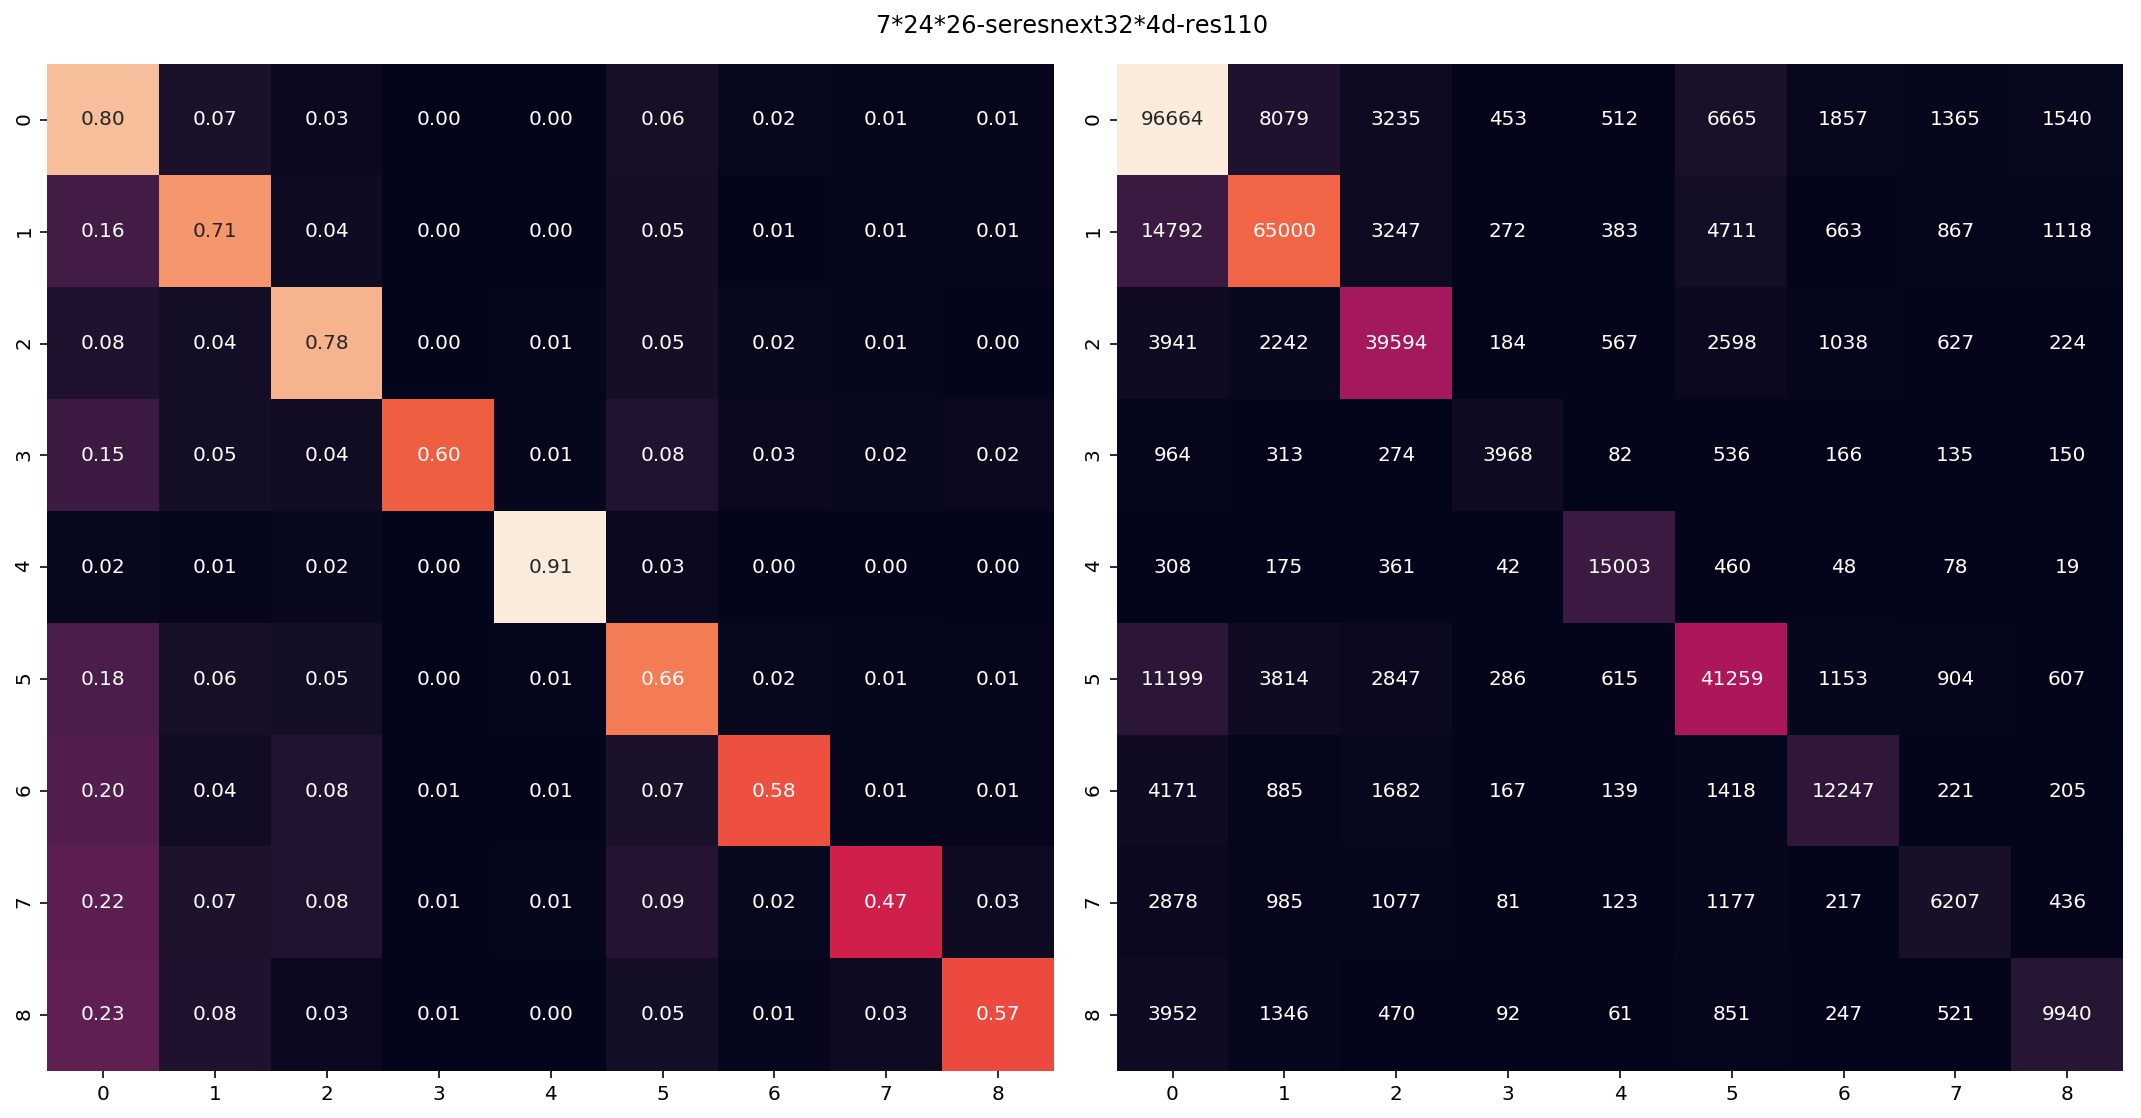

In [102]:
y_pred = np.argmax(train_df.loc[:, features7_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("7*24*26-seresnext32*4d-res110")
f.tight_layout()
plt.show()

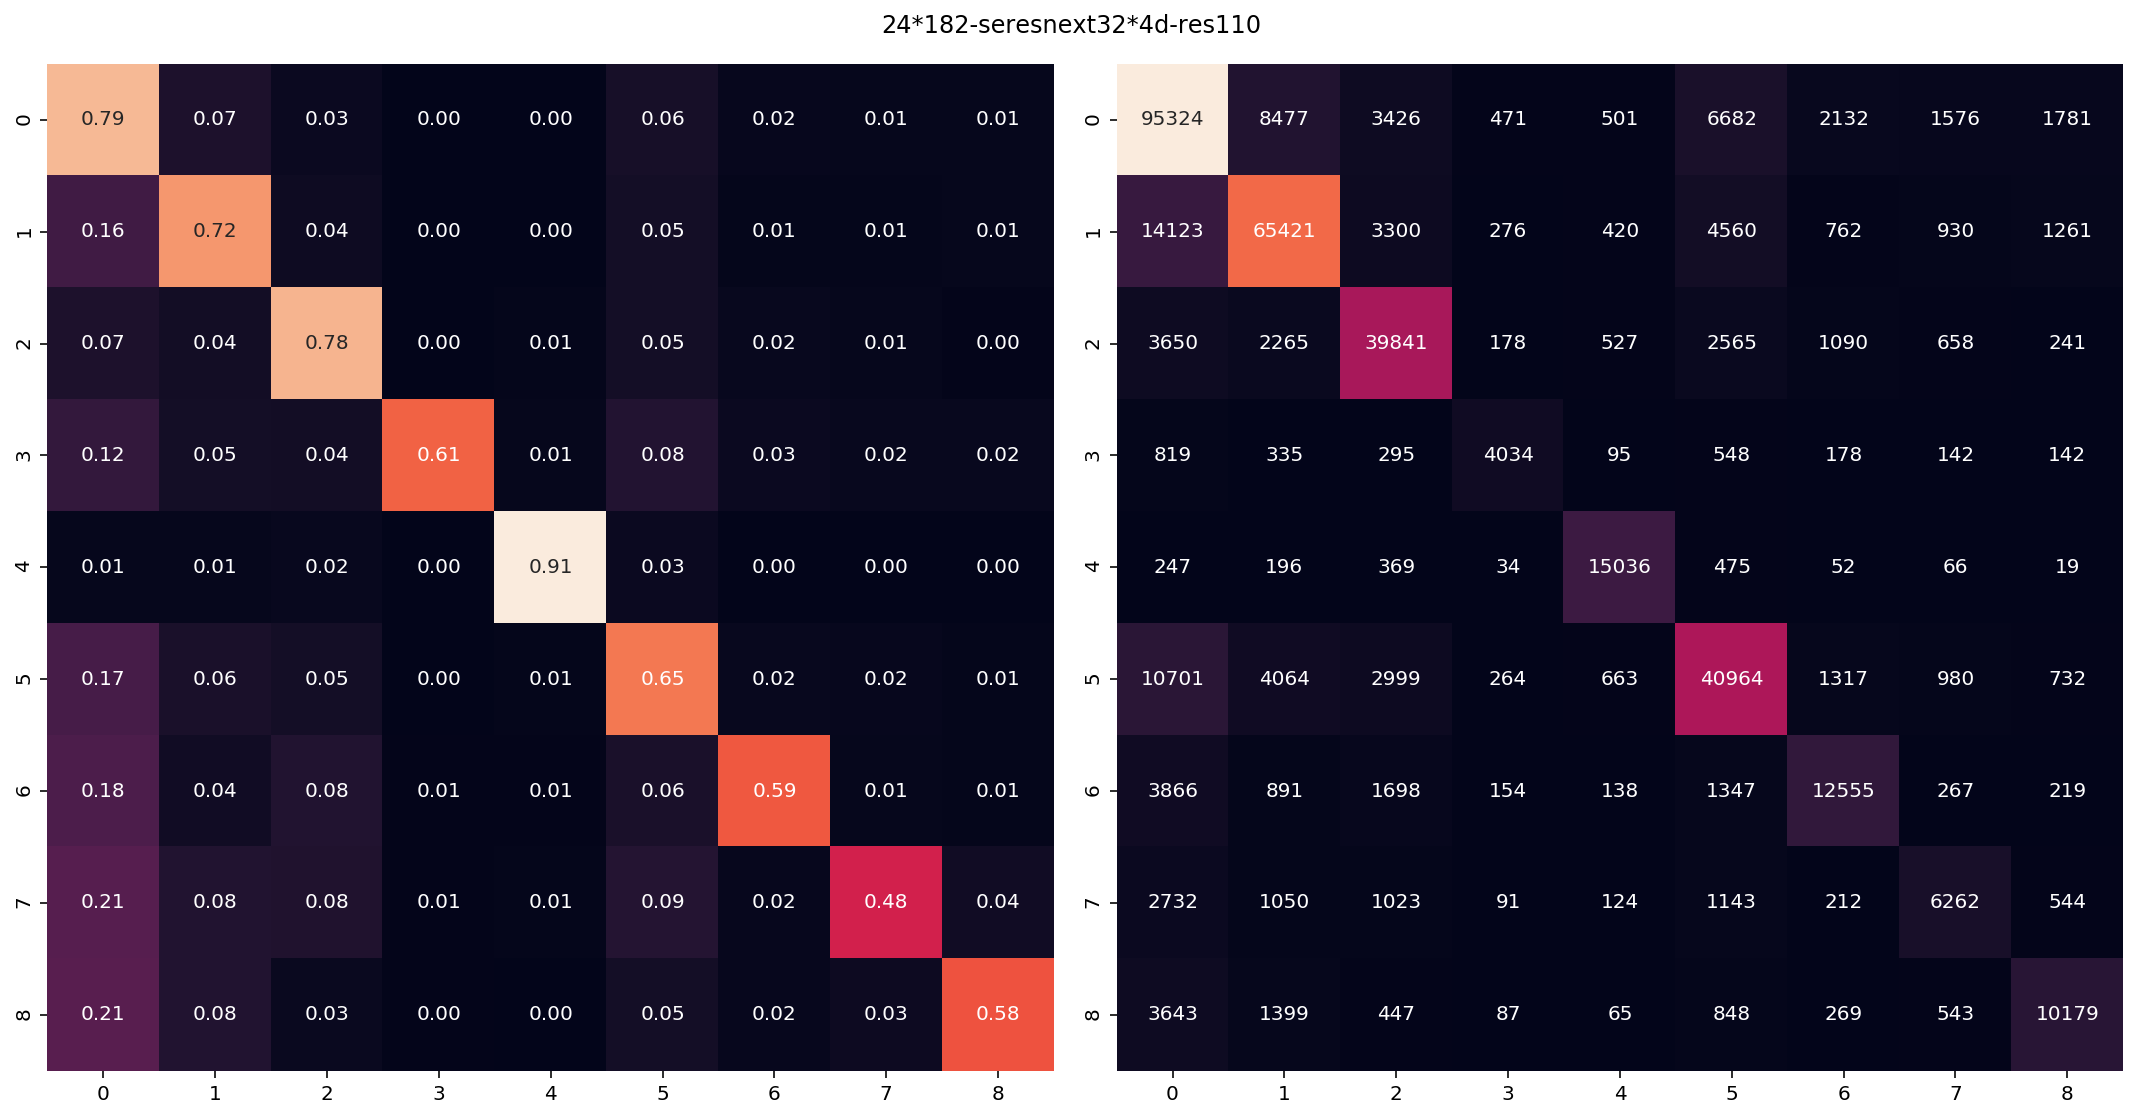

In [103]:
y_pred = np.argmax(train_df.loc[:, features182_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("24*182-seresnext32*4d-res110")
f.tight_layout()
plt.show()

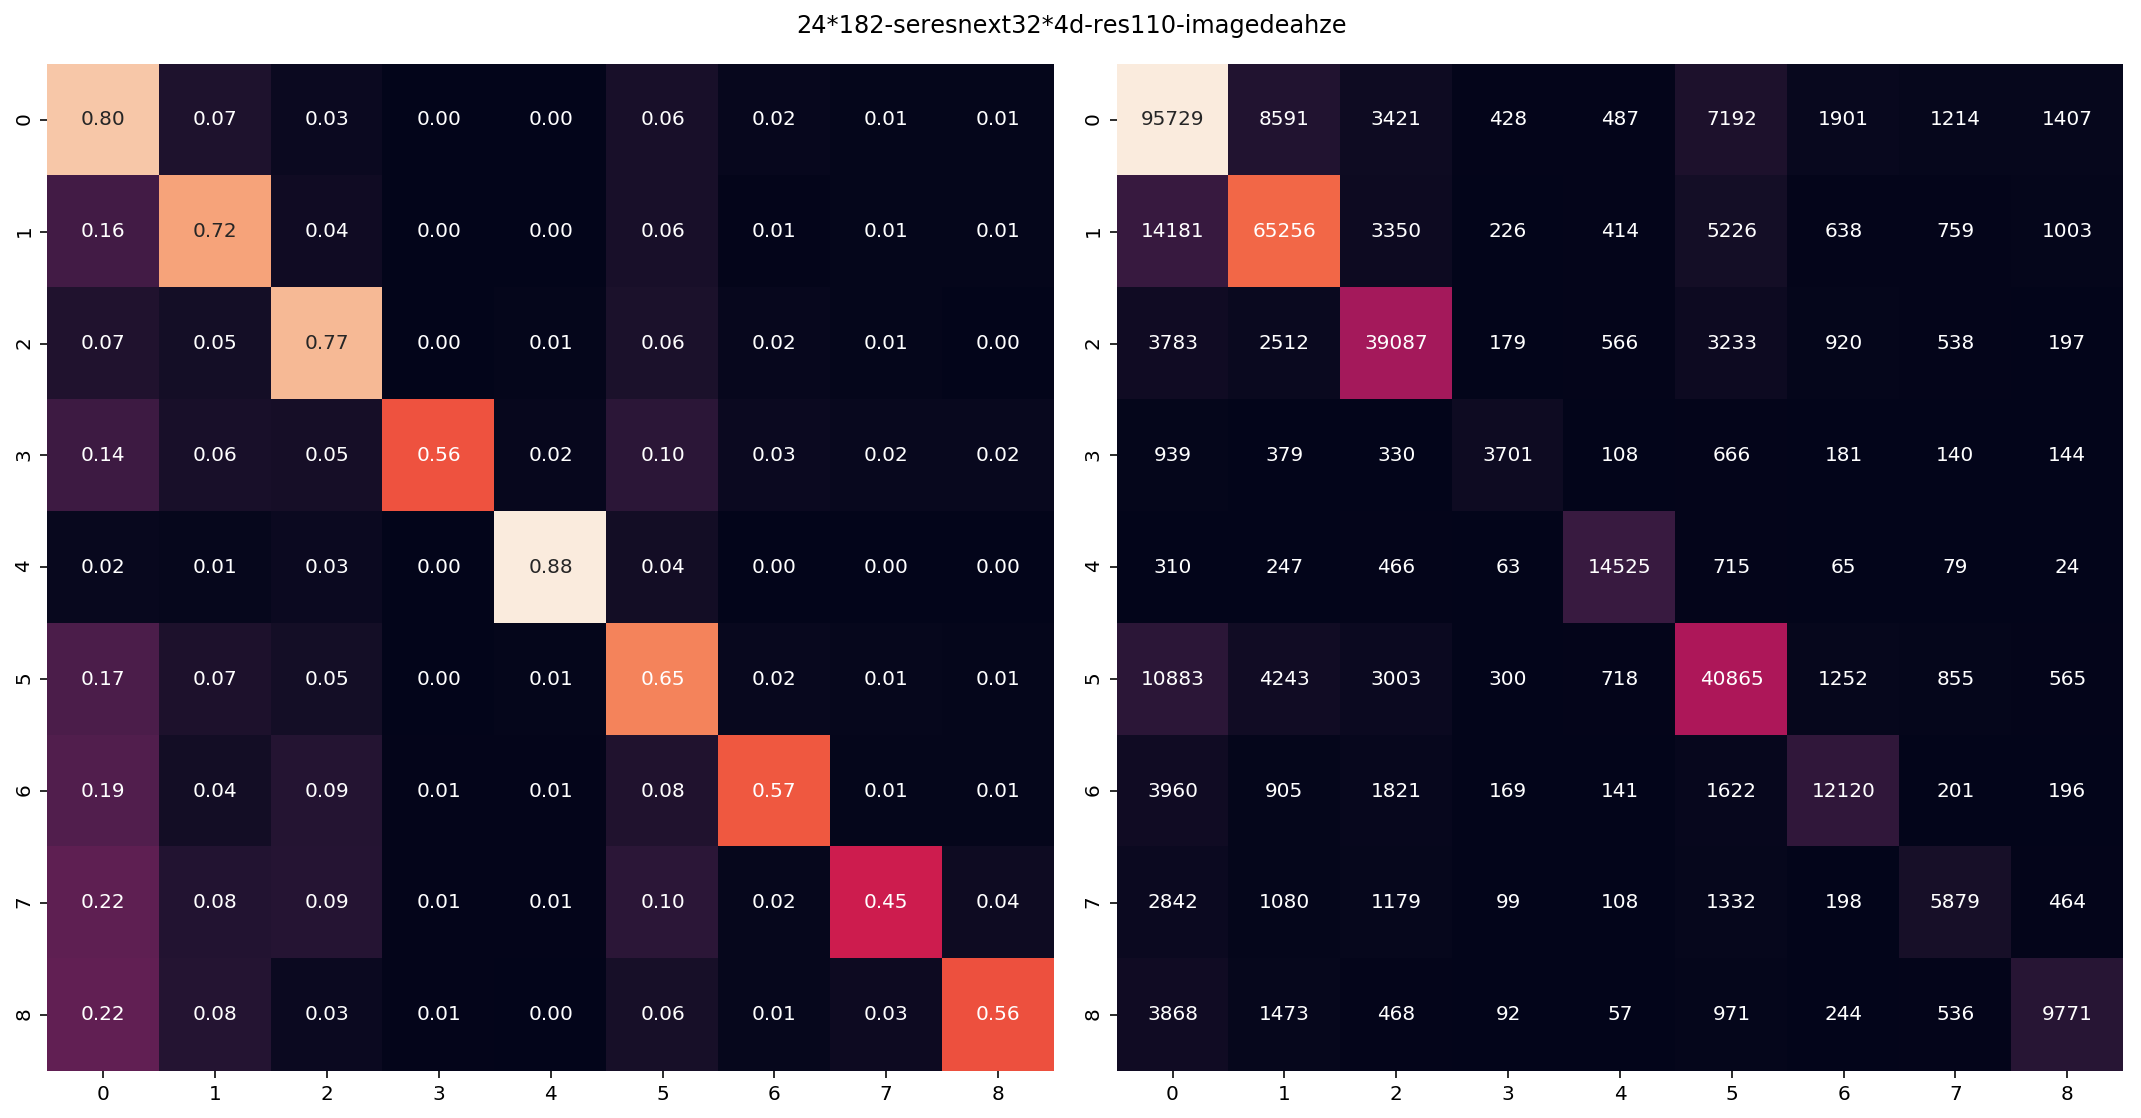

In [109]:
y_pred = np.argmax(train_df.loc[:, features182imgdehaze_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("24*182-seresnext32*4d-res110-imagedeahze")
f.tight_layout()
plt.show()

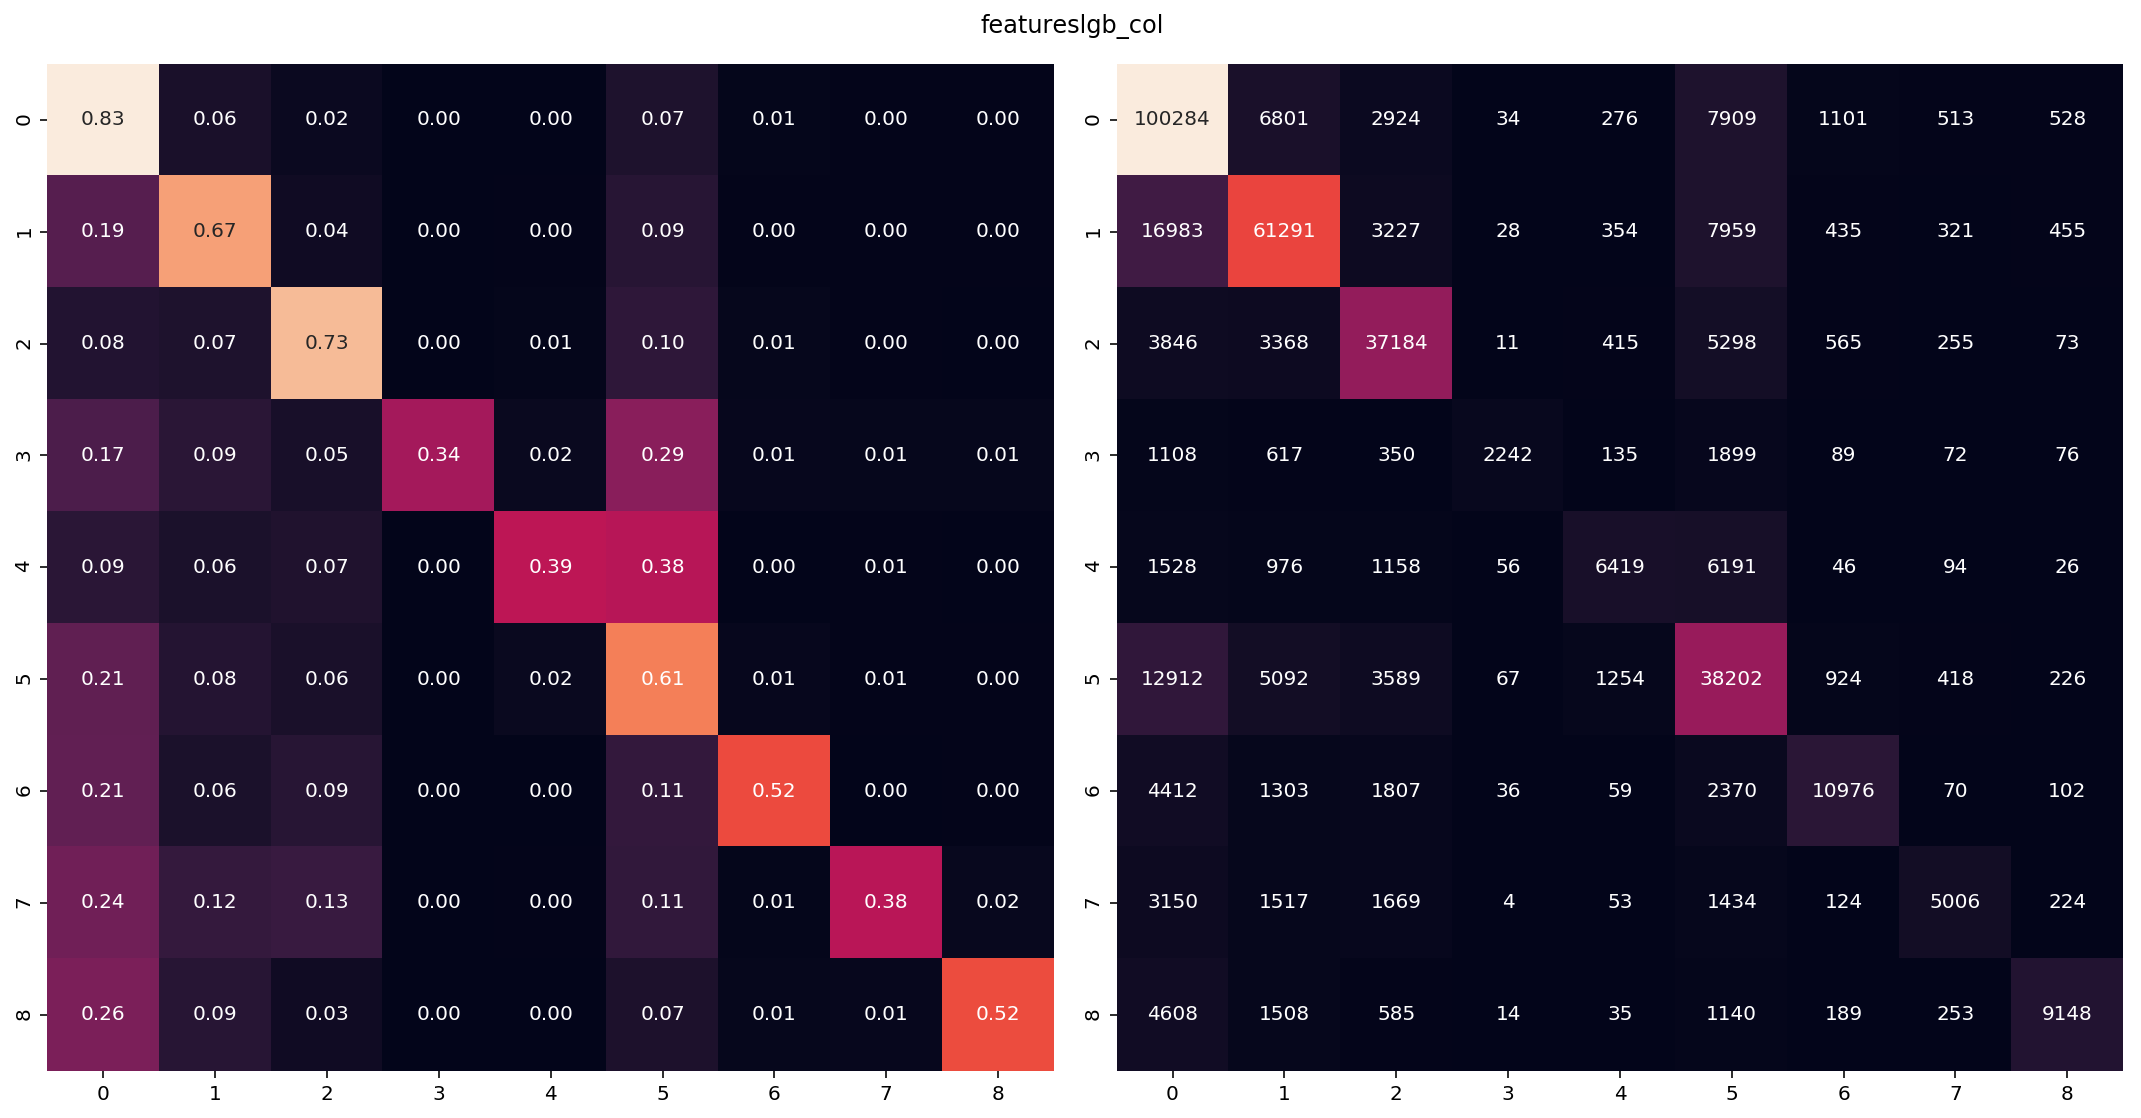

In [104]:
y_pred = np.argmax(train_df.loc[:, featureslgb_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("featureslgb_col")
f.tight_layout()
plt.show()

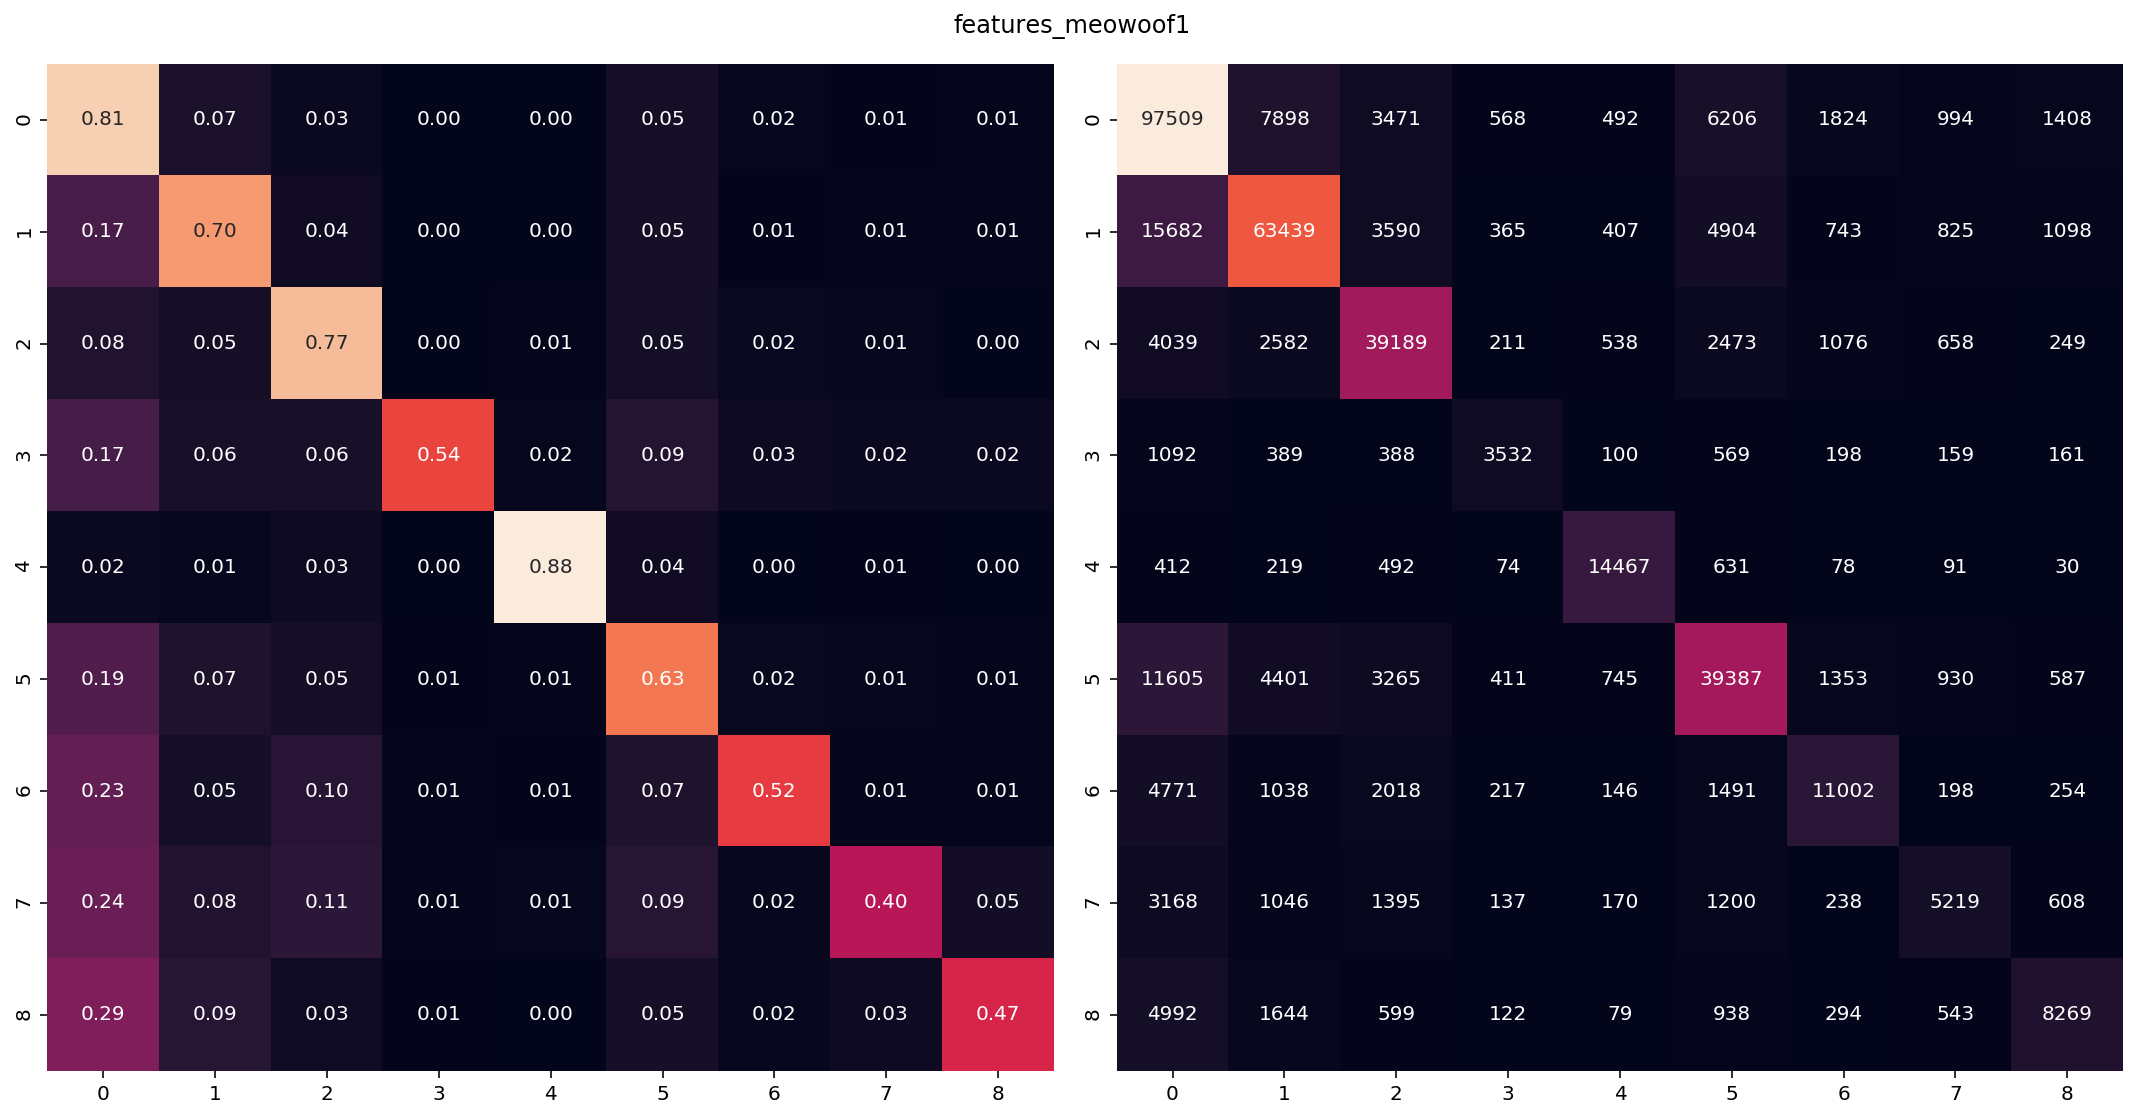

In [106]:
y_pred = np.argmax(train_df.loc[:, featuresmeowoof1_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("features_meowoof1")
f.tight_layout()
plt.show()

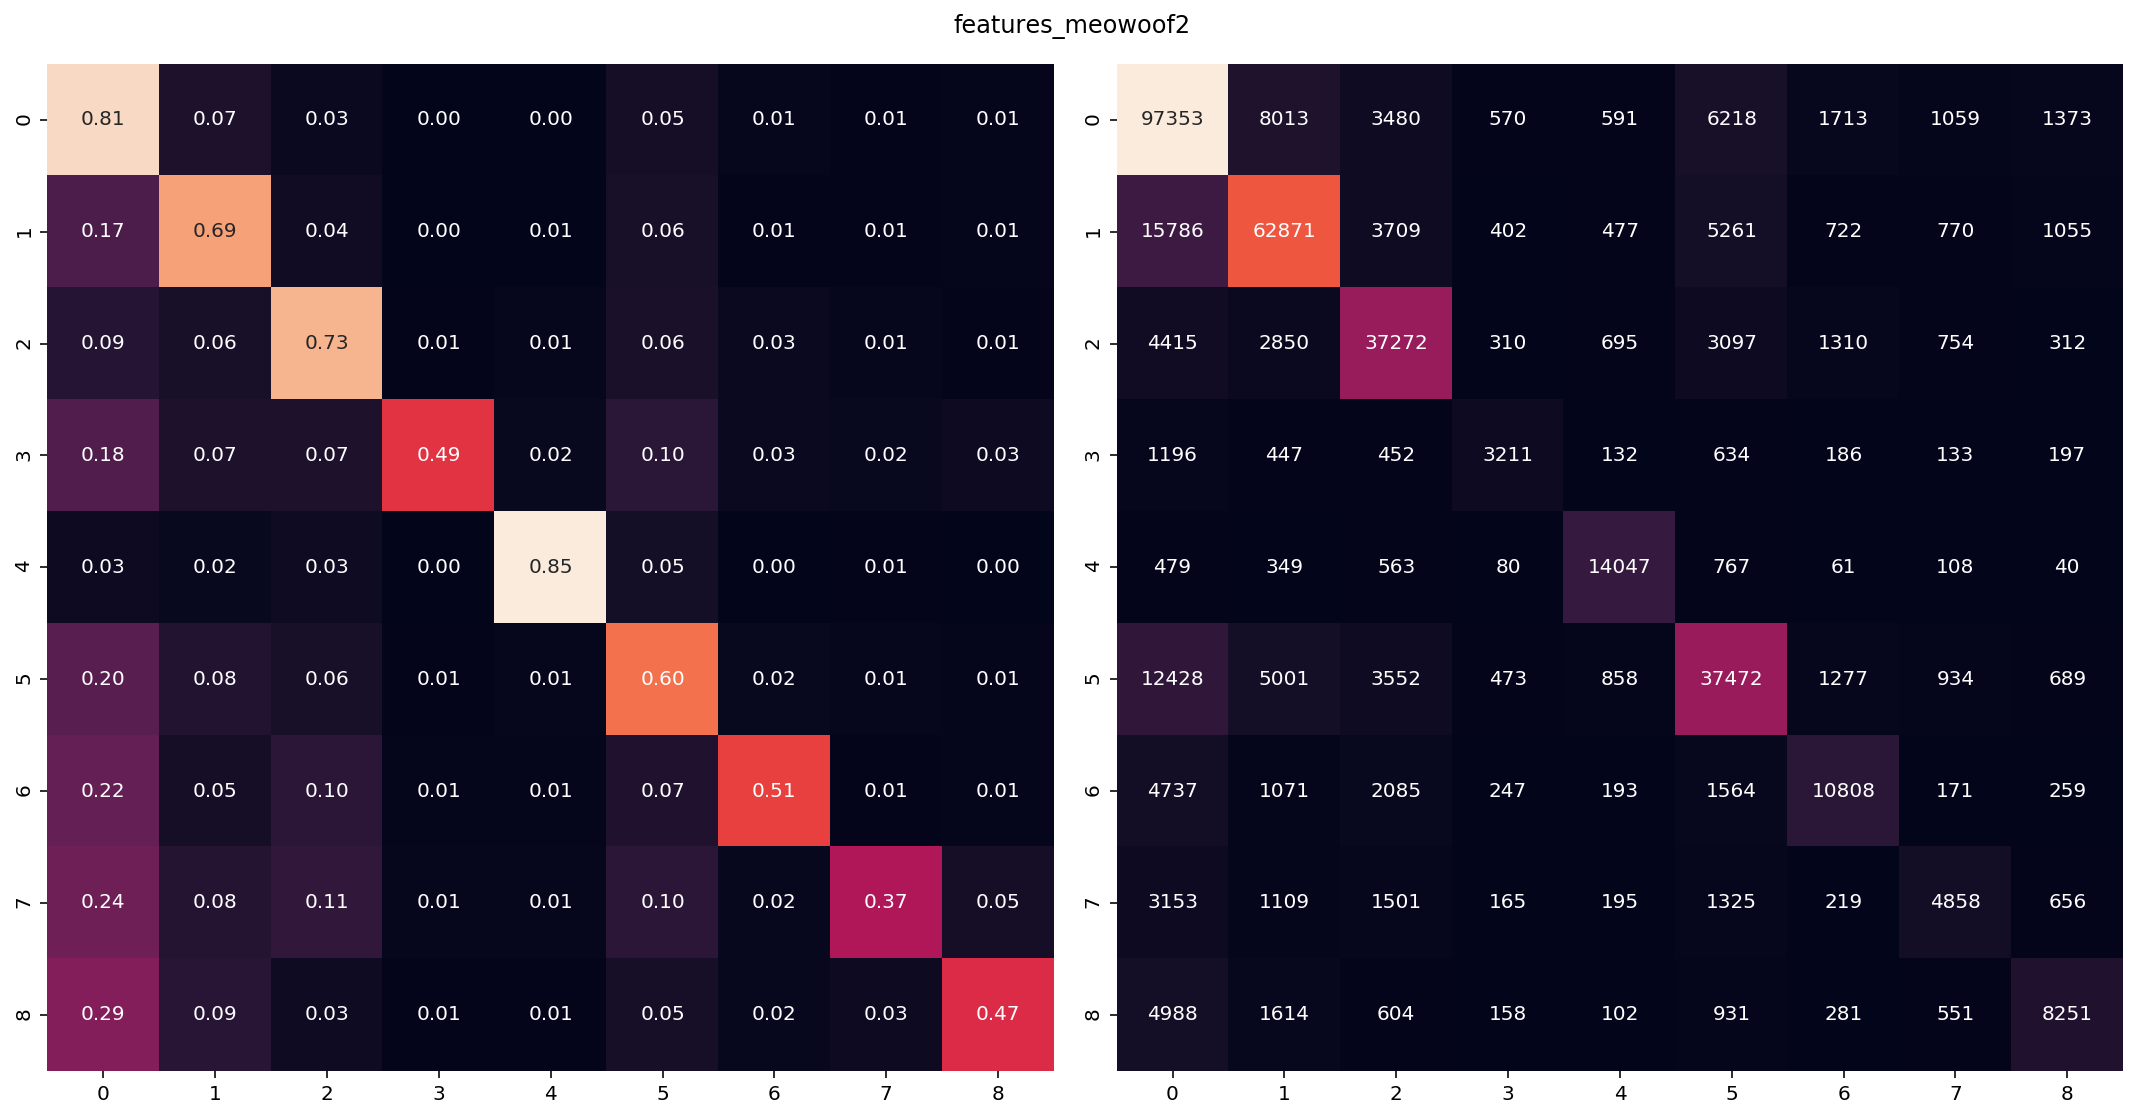

In [107]:
y_pred = np.argmax(train_df.loc[:, featuresmeowoof2_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("features_meowoof2")
f.tight_layout()
plt.show()

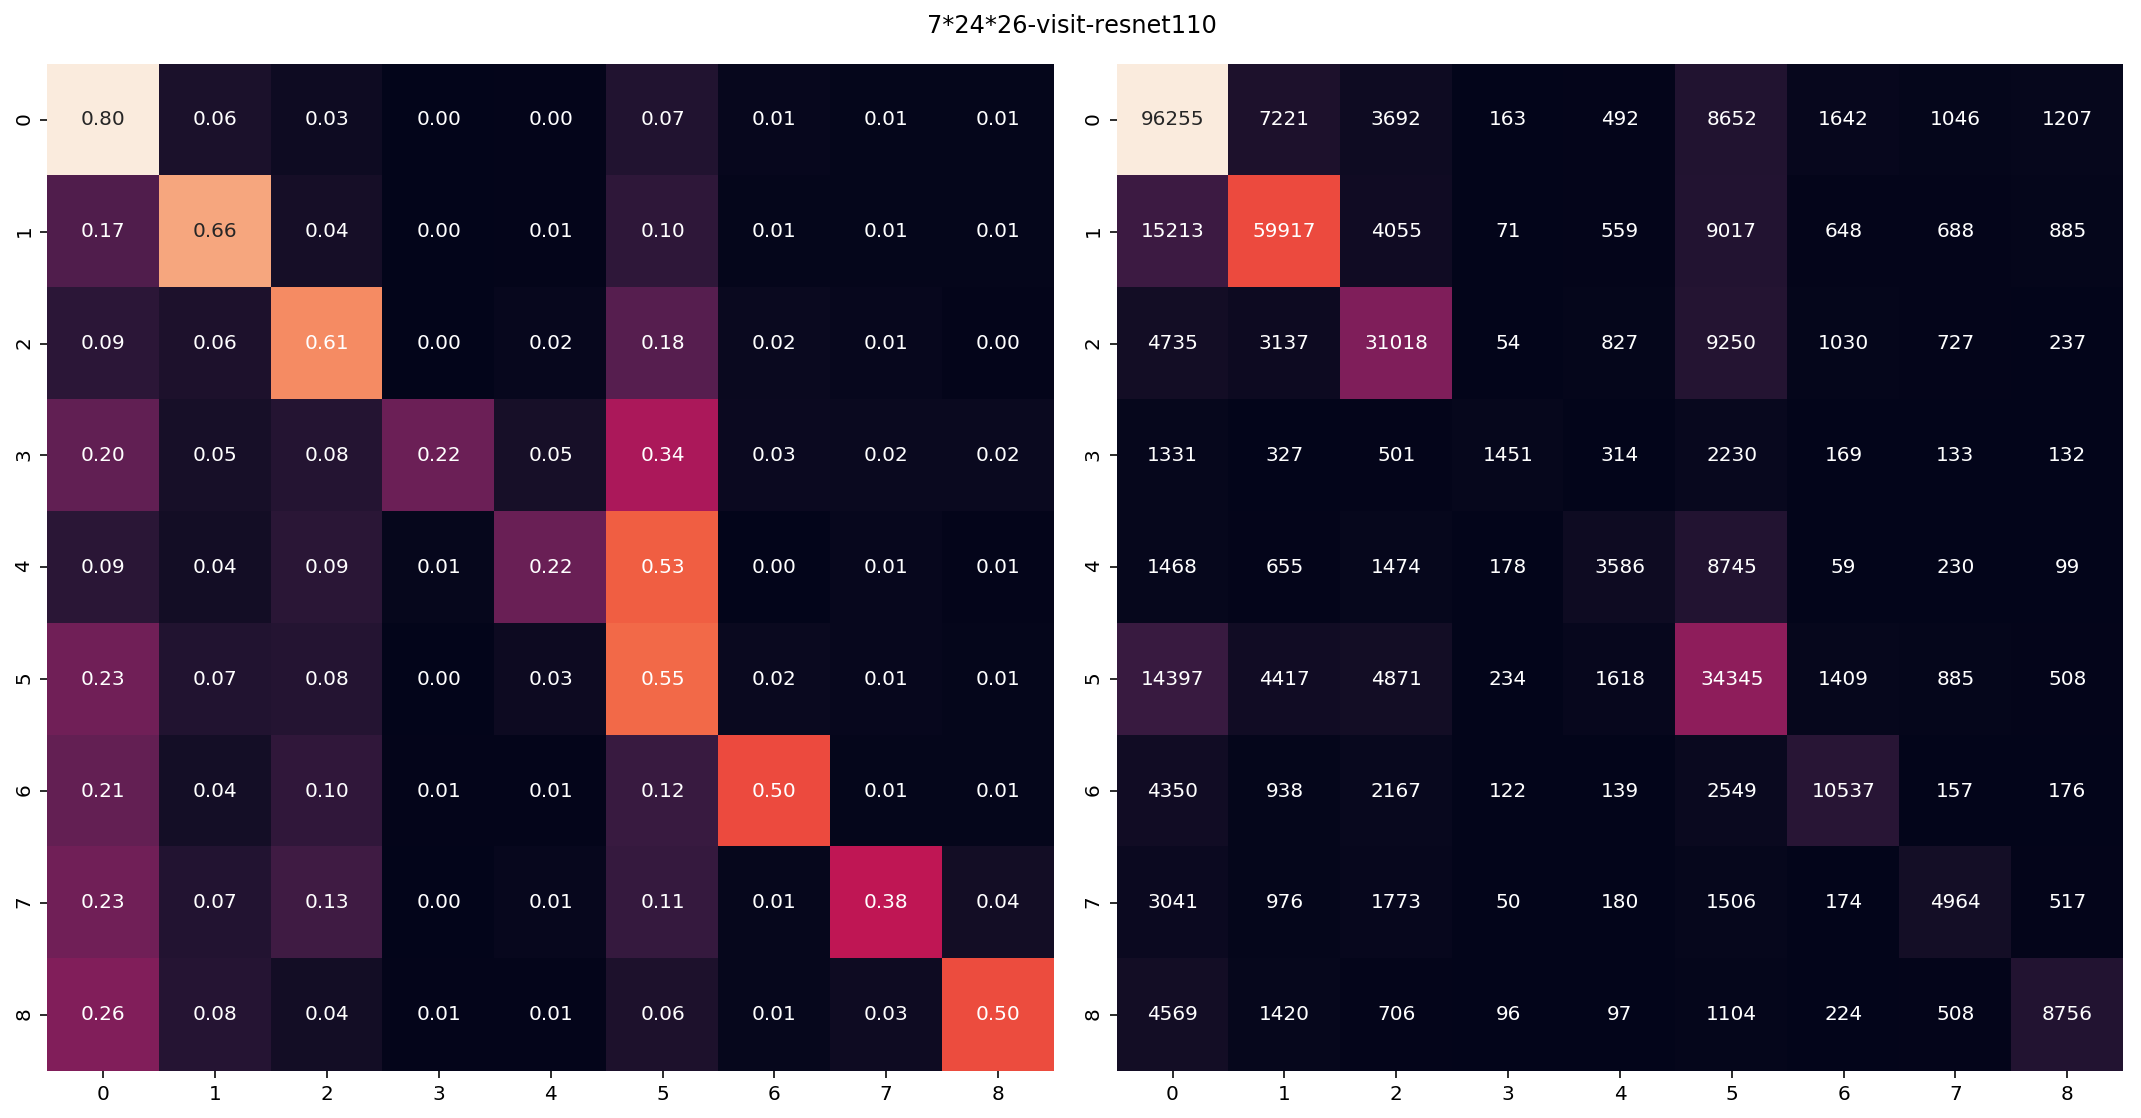

In [108]:
y_pred = np.argmax(train_df.loc[:, features7visit_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("7*24*26-visit-resnet110")
f.tight_layout()
plt.show()

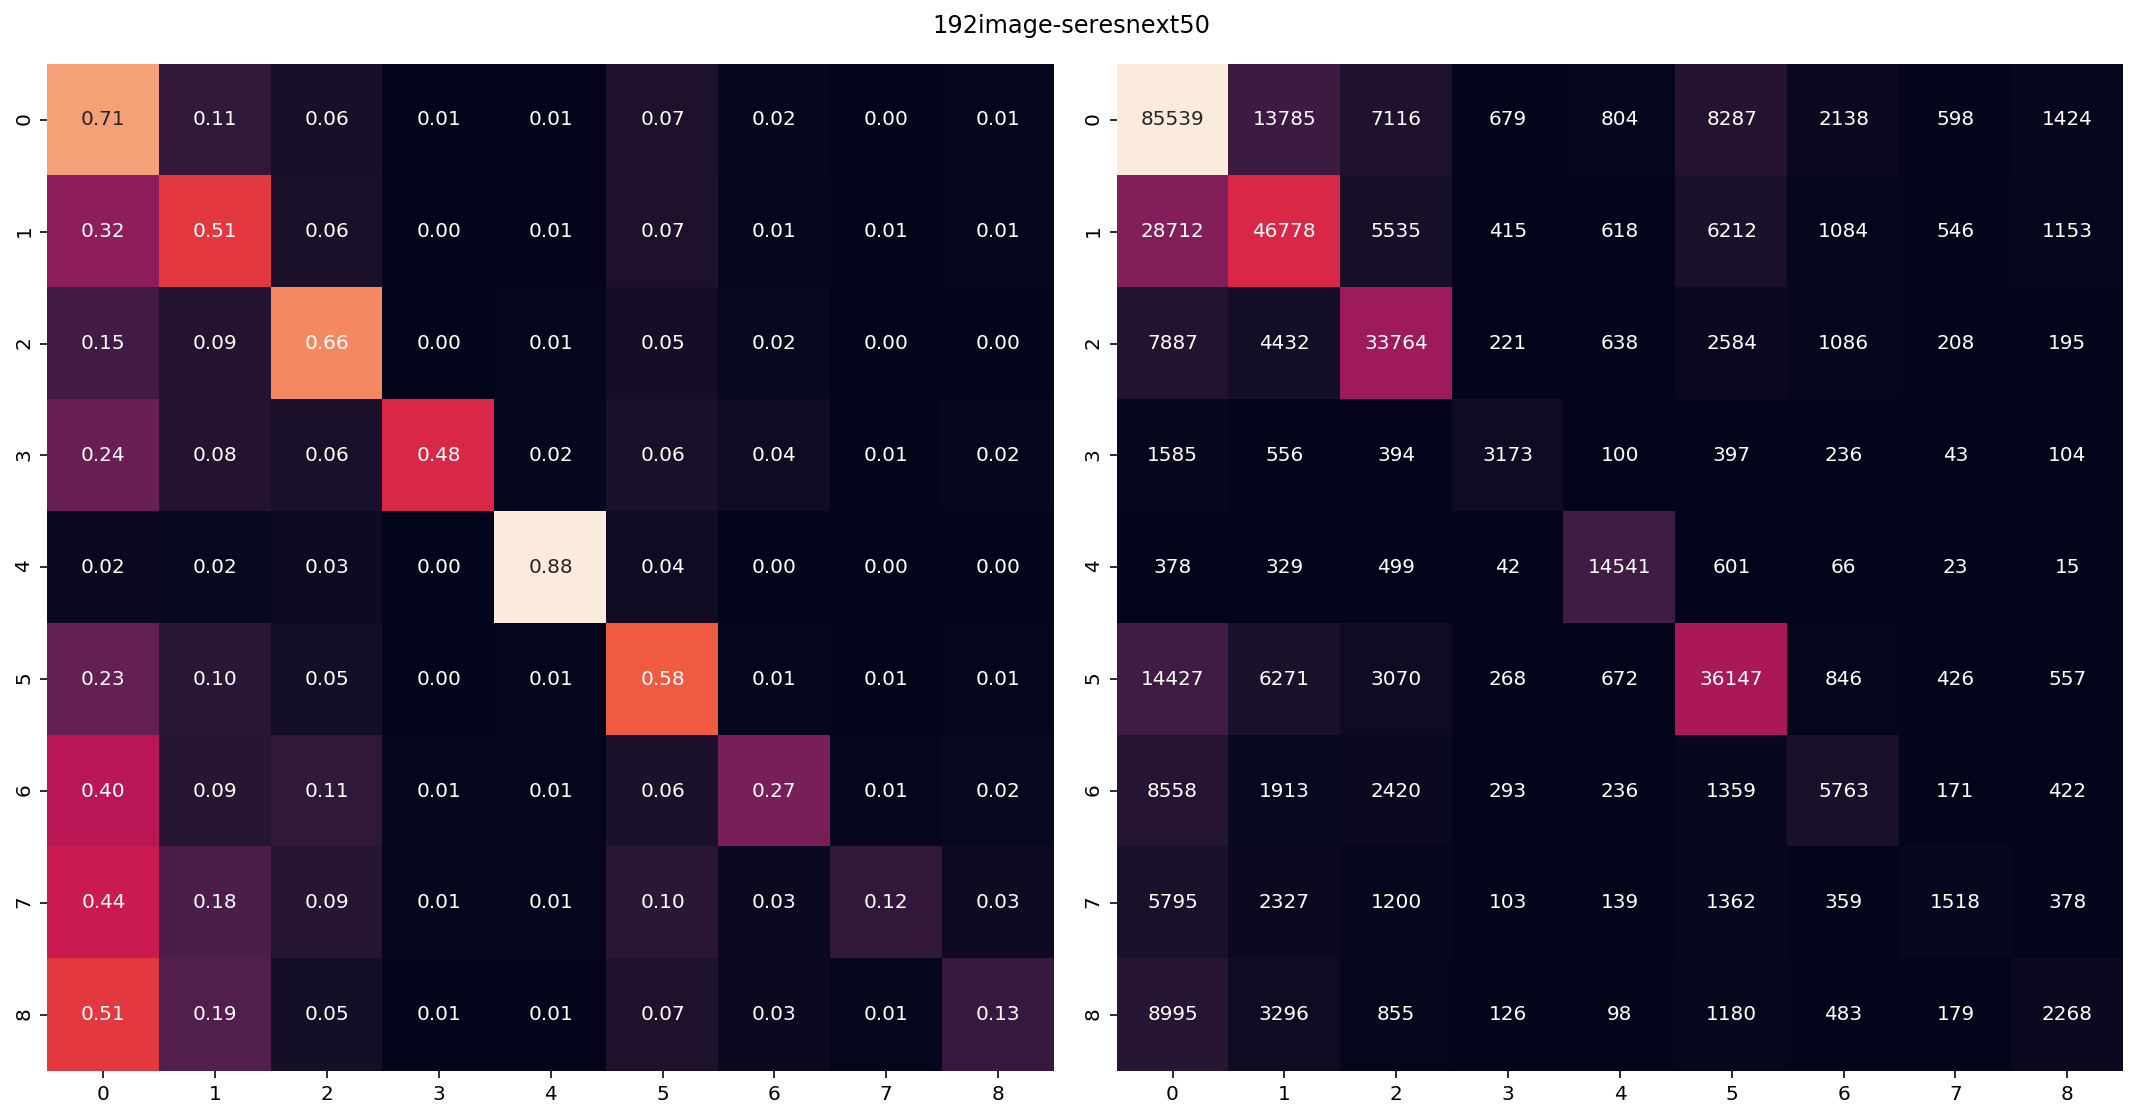

In [71]:
y_pred = np.argmax(train_df.loc[:, featuresimg_col].values, 1)
conf_mat = confusion_matrix(train_df.Target, y_pred)
f, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
# plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.suptitle("192image-seresnext50")
f.tight_layout()
plt.show()

## Add features

In [8]:
np.argmax(train_df.loc[:, features7_col].values, 1)

array([1, 0, 0, ..., 1, 1, 0])

In [34]:
train_df["argmax_7"] = np.argmax(train_df.loc[:, features7_col].values, 1)
train_df["argmax_182"] = np.argmax(train_df.loc[:, features182_col].values, 1)
train_df["argmax_lgb"] = np.argmax(train_df.loc[:, featureslgb_col].values, 1)
train_df["argmax_meow1"] = np.argmax(train_df.loc[:, featuresmeowoof1_col].values, 1)
train_df["argmax_meow2"] = np.argmax(train_df.loc[:, featuresmeowoof2_col].values, 1)

In [36]:
test_df["argmax_7"] = np.argmax(test_df.loc[:, features7_col].values, 1)
test_df["argmax_182"] = np.argmax(test_df.loc[:, features182_col].values, 1)
test_df["argmax_lgb"] = np.argmax(test_df.loc[:, featureslgb_col].values, 1)
test_df["argmax_meow1"] = np.argmax(test_df.loc[:, featuresmeowoof1_col].values, 1)
test_df["argmax_meow2"] = np.argmax(test_df.loc[:, featuresmeowoof2_col].values, 1)

In [ ]:
y_pred_top2 = np.argpartition(-y_pred, 2, axis=1)[:, :2]

In [63]:
train_df["argmax2_7"] = np.argpartition(-train_df.loc[:, features7_col].values, 2, axis=1)[:, 1:2]
train_df["argmax2_182"] = np.argpartition(-train_df.loc[:, features182_col].values, 2, axis=1)[:, 1:2]
train_df["argmax2_lgb"] = np.argpartition(-train_df.loc[:, featureslgb_col].values, 2, axis=1)[:, 1:2]
train_df["argmax2_meow1"] = np.argpartition(-train_df.loc[:, featuresmeowoof1_col].values, 2, axis=1)[:, 1:2]
train_df["argmax2_meow2"] = np.argpartition(-train_df.loc[:, featuresmeowoof2_col].values, 2, axis=1)[:, 1:2]

In [64]:
test_df["argmax2_7"] = np.argpartition(-test_df.loc[:, features7_col].values, 2, axis=1)[:, 1:2]
test_df["argmax2_182"] = np.argpartition(-test_df.loc[:, features182_col].values, 2, axis=1)[:, 1:2]
test_df["argmax2_lgb"] = np.argpartition(-test_df.loc[:, featureslgb_col].values, 2, axis=1)[:, 1:2]
test_df["argmax2_meow1"] = np.argpartition(-test_df.loc[:, featuresmeowoof1_col].values, 2, axis=1)[:, 1:2]
test_df["argmax2_meow2"] = np.argpartition(-test_df.loc[:, featuresmeowoof2_col].values, 2, axis=1)[:, 1:2]

In [65]:
features_argmax_col = ["argmax_7", "argmax_182", "argmax_lgb", "argmax_meow1", "argmax_meow2", "argmax2_7", "argmax2_182", "argmax2_lgb", "argmax2_meow1", "argmax2_meow2"]

In [85]:
bagging_tr = train_df.loc[:, features182_col].values*0.4 + train_df.loc[:, features7_col].values*0.4 +\
            train_df.loc[:, featuresmeowoof1_col].values*0.15 + train_df.loc[:, featureslgb_col].values*0.05

In [87]:
bagging_te = test_df.loc[:, features182_col].values*0.4 + test_df.loc[:, features7_col].values*0.4 +\
            test_df.loc[:, featuresmeowoof1_col].values*0.15 + test_df.loc[:, featureslgb_col].values*0.05

In [73]:
bagging_tr = train_df.loc[:, featuresmeowoof2_col].values*0.25 + train_df.loc[:, features182imgdehaze_col].values*0.75
bagging_te = test_df.loc[:, featuresmeowoof2_col].values*0.25 + test_df.loc[:, features182imgdehaze_col].values*0.75

In [ ]:
bag_dehaze73

In [86]:
test_df.loc[:, featureslgb_col].shape

(100000, 9)

In [88]:
bagging_tr.shape

(400000, 9)

In [74]:
featuresbag_col = ["bag_%s"%i for i in range(9)]
bagging_tr_df = pd.DataFrame(bagging_tr, columns=featuresbag_col)
bagging_te_df = pd.DataFrame(bagging_te, columns=featuresbag_col)

In [75]:
bagging_te_df.isna().any()

bag_0    False
bag_1    False
bag_2    False
bag_3    False
bag_4    False
bag_5    False
bag_6    False
bag_7    False
bag_8    False
dtype: bool

In [76]:
train_df = concat([train_df, bagging_tr_df])
test_df = concat([test_df, bagging_te_df])

['basename', 'Target', 'fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'fold5_182imgdehaze_0', 'fold5_182imgdehaze_1', 'fold5_182imgdehaze_2', 'fold5_182imgdehaze_3', 'fold5_182imgdehaze_4', 'fold5_182imgdehaze_5', 'fold5_182imgdehaze_6', 'fold5_182imgdehaze_7', 'fold5_182imgdehaze_8', 'fold5_lgb_0', 'fold5_lgb_1', 'fold5_lgb_2', 'fold5_lgb_3', 'fold5_lgb_4', 'fold5_lgb_5', 'fold5_lgb_6', 'fold5_lgb_7', 'fold5_lgb_8', 'meow_oof1_0', 'meow_oof1_1', 'meow_oof1_2', 'meow_oof1_3', 'meow_oof1_4', 'meow_oof1_5', 'meow_oof1_6', 'meow_oof1_7', 'meow_oof1_8', 'meow_oof2_0', 'meow_oof2_1', 'meow_oof2_2', 'meow_oof2_3', 'meow_oof2_4', 'meow_oof2_5', 'meow_oof2_6', 'meow_oof2_7', 'meow_oof2_8', 'bag_0', 'bag_1', 'bag_2', 'bag_3', 'bag_4', 'bag_5', 'bag_6', 'bag_7', 'bag_8']
(400000, 65)
['basename

In [77]:
train_df.Target = train_df.Target.apply(lambda x: int(x))

In [147]:
pred_tests = test_df.loc[:, featuresbag_col].values

In [148]:
pred_tests

array([[0.69965779, 0.07307461, 0.00164321, ..., 0.02049361, 0.01775917,
        0.14389266],
       [0.0959613 , 0.02052609, 0.40515266, ..., 0.32793689, 0.00288285,
        0.00353103],
       [0.34683986, 0.07611072, 0.29180216, ..., 0.21050209, 0.00504726,
        0.00857037],
       ...,
       [0.93425741, 0.02697002, 0.00630465, ..., 0.00243817, 0.00191422,
        0.0017036 ],
       [0.84811983, 0.07865221, 0.01956672, ..., 0.01390804, 0.00696123,
        0.00633927],
       [0.8808916 , 0.02288624, 0.00146866, ..., 0.0307261 , 0.00489673,
        0.00579464]])

# Stacking

In [64]:
import swifter

In [24]:
# train_features = train_df.columns.tolist()
# for i in ["index", "basename", "Target"]:
#     train_features.remove(i)
# for i in ['fold5_lgb_0', 'fold5_lgb_1', 'fold5_lgb_2', 'fold5_lgb_3', 'fold5_lgb_4', 'fold5_lgb_5', 'fold5_lgb_6', 'fold5_lgb_7', 'fold5_lgb_8']:
#     train_features.remove(i)
# print(train_features)

In [72]:
train_features = features7_col + features182_col + featuresmeowoof1_col + featureslgb_col + featuresmeowoof2_col + featuresimg_col# + features7visit_col + features182imgdehaze_col# + featuresmeowoof2_col 
print(train_features, len(train_features))

['fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_182_4', 'fold5_182_5', 'fold5_182_6', 'fold5_182_7', 'fold5_182_8', 'meow_oof1_0', 'meow_oof1_1', 'meow_oof1_2', 'meow_oof1_3', 'meow_oof1_4', 'meow_oof1_5', 'meow_oof1_6', 'meow_oof1_7', 'meow_oof1_8', 'fold5_lgb_0', 'fold5_lgb_1', 'fold5_lgb_2', 'fold5_lgb_3', 'fold5_lgb_4', 'fold5_lgb_5', 'fold5_lgb_6', 'fold5_lgb_7', 'fold5_lgb_8', 'meow_oof2_0', 'meow_oof2_1', 'meow_oof2_2', 'meow_oof2_3', 'meow_oof2_4', 'meow_oof2_5', 'meow_oof2_6', 'meow_oof2_7', 'meow_oof2_8', 'fold5_image_0', 'fold5_image_1', 'fold5_image_2', 'fold5_image_3', 'fold5_image_4', 'fold5_image_5', 'fold5_image_6', 'fold5_image_7', 'fold5_image_8'] 54
['fold5_7_0', 'fold5_7_1', 'fold5_7_2', 'fold5_7_3', 'fold5_7_4', 'fold5_7_5', 'fold5_7_6', 'fold5_7_7', 'fold5_7_8', 'fold5_182_0', 'fold5_182_1', 'fold5_182_2', 'fold5_182_3', 'fold5_1

In [73]:
X_train = train_df[train_features]
Y_train = train_df["Target"]
print(X_train.shape, Y_train.shape)

(400000, 54) (400000,)
(400000, 54) (400000,)


In [74]:
X_test = test_df[train_features]
print(X_test.shape)

(100000, 54)
(100000, 54)


In [77]:
print(X_train.shape, Y_train.shape)
print(X_test.shape)

(400000, 54) (400000,)
(100000, 54)
(400000, 54) (400000,)
(100000, 54)


In [64]:
# test_files.to_csv("./dataset/final_test.csv", index=False)

In [75]:
test_files = pd.read_csv("./dataset/final_test.csv")
# test_files.basename = test_files.basename.apply(lambda x: int(x[:-4]))
ID_values = test_files.loc[:, ["basename", "Target"]].values
ID_values

array([[    0,     0],
       [    1,     0],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

array([[    0,     0],
       [    1,     0],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

### Xgboost

In [ ]:
import xgboost as xgb

In [156]:
xgbm = xgb_model

In [179]:
pred_val = xgb_model.predict(xgb_val, ntree_limit=xgb_model.best_ntree_limit)
print("acc:",accuracy_score(y_val, pred_val))

acc: 0.794722763861807


In [94]:
xgb_params = {"objective": "multi:softprob" ,
              "num_class": 9,
              "booster" : "gbtree",
              "eta": 0.03,
              "subsample": 0.8,
              "eval_metric": "merror",# "mlogloss"},
              "colsample_bytree": 0.8,
              "nthread": 16,
              "seed": 2050, 
#               "n_jobs": 20,
#               "num_leaves": 6,
#               "max_depth": 4,
              "gamma": 0.3,
              "lambda": 2,
#               "min_child_weight": 12, 
              }

xgb_pred_te_all = 0
models = []

skf = StratifiedKFold(n_splits=5, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
    print( "\nFold ", fold)
    y_tr, y_val = Y_train.iloc[train_idx].copy(), Y_train.iloc[val_idx].copy()
    X_tr, X_val= X_train.iloc[train_idx,:].copy(), X_train.iloc[val_idx,:].copy()

    xgb_tr = xgb.DMatrix(X_tr, y_tr)
    xgb_val = xgb.DMatrix(X_val, y_val)
    xgb_te = xgb.DMatrix(X_test)

#     print(np.sum(y_tr==0)/np.sum(y_tr==1))
    watchlist = [(xgb_tr, 'train'), (xgb_val, 'eval')]
    xgb_model =xgb.train(xgb_params,
                 xgb_tr,
                 num_boost_round = 20000,
                 evals = watchlist,
                 verbose_eval=50,
                 early_stopping_rounds=500)
    models.append(xgb_model)
    
    pred_val = xgb_model.predict(xgb_val, ntree_limit=xgb_model.best_ntree_limit)
    print("acc:",accuracy_score(y_val, np.argmax(pred_val, axis=1)))
    pred_te = xgb_model.predict(xgb_te, ntree_limit=xgb_model.best_ntree_limit)
    xgb_pred_te_all = xgb_pred_te_all + pred_te / 5


Fold  0


/home/weiqiang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.260974	eval-merror:0.264156
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 500 rounds.
[50]	train-merror:0.247408	eval-merror:0.252269
[100]	train-merror:0.24398	eval-merror:0.250031
[150]	train-merror:0.24058	eval-merror:0.247519
[200]	train-merror:0.236986	eval-merror:0.245219
[250]	train-merror:0.233351	eval-merror:0.243194
[300]	train-merror:0.230092	eval-merror:0.241281
[350]	train-merror:0.227433	eval-merror:0.239982
[400]	train-merror:0.224576	eval-merror:0.239282
[450]	train-merror:0.221989	eval-merror:0.238194
[500]	train-merror:0.219514	eval-merror:0.237732
[550]	train-merror:0.217376	eval-merror:0.237182
[600]	train-merror:0.215151	eval-merror:0.236869
[650]	train-merror:0.213033	eval-merror:0.236282
[700]	train-merror:0.210936	eval-merror:0.235832
[750]	train-merror:0.209029	eval-merror:0.235619
[800]	train-merror:0.206926	eval-merror:0.235144
[850]	train-merror:0.205

[2050]	train-merror:0.164016	eval-merror:0.233747
[2100]	train-merror:0.162513	eval-merror:0.233822
[2150]	train-merror:0.160875	eval-merror:0.233685
[2200]	train-merror:0.159235	eval-merror:0.233472
[2250]	train-merror:0.157663	eval-merror:0.233522
[2300]	train-merror:0.156035	eval-merror:0.233297
[2350]	train-merror:0.154544	eval-merror:0.233322
[2400]	train-merror:0.152888	eval-merror:0.23321
[2450]	train-merror:0.151272	eval-merror:0.232947
[2500]	train-merror:0.149719	eval-merror:0.23296
[2550]	train-merror:0.148172	eval-merror:0.232972
[2600]	train-merror:0.146685	eval-merror:0.23276
[2650]	train-merror:0.145188	eval-merror:0.23266
[2700]	train-merror:0.143572	eval-merror:0.232622
[2750]	train-merror:0.14206	eval-merror:0.232372
[2800]	train-merror:0.140529	eval-merror:0.232397
[2850]	train-merror:0.139132	eval-merror:0.23251
[2900]	train-merror:0.137713	eval-merror:0.232385
[2950]	train-merror:0.136147	eval-merror:0.232672
[3000]	train-merror:0.134716	eval-merror:0.232797
[3050]

[2100]	train-merror:0.161723	eval-merror:0.232596
[2150]	train-merror:0.160064	eval-merror:0.232634
[2200]	train-merror:0.158617	eval-merror:0.232596
[2250]	train-merror:0.157045	eval-merror:0.232484
[2300]	train-merror:0.15548	eval-merror:0.232521
[2350]	train-merror:0.15402	eval-merror:0.232609
[2400]	train-merror:0.152505	eval-merror:0.232546
[2450]	train-merror:0.150977	eval-merror:0.232459
[2500]	train-merror:0.149605	eval-merror:0.232471
[2550]	train-merror:0.14802	eval-merror:0.232521
[2600]	train-merror:0.146524	eval-merror:0.232209
[2650]	train-merror:0.144883	eval-merror:0.232134
[2700]	train-merror:0.143486	eval-merror:0.232196
[2750]	train-merror:0.142099	eval-merror:0.232271
[2800]	train-merror:0.140649	eval-merror:0.232046
[2850]	train-merror:0.139061	eval-merror:0.231996
[2900]	train-merror:0.137655	eval-merror:0.231959
[2950]	train-merror:0.136042	eval-merror:0.232146
[3000]	train-merror:0.134492	eval-merror:0.232009
[3050]	train-merror:0.133152	eval-merror:0.232021
[31

In [198]:
xgb_pred_te_all = 0
xgb_te = xgb.DMatrix(X_test)
for xgb_model in models:
    pred_te = xgb_model.predict(xgb_te, ntree_limit=xgb_model.best_ntree_limit)
    xgb_pred_te_all = xgb_pred_te_all + pred_te / 5

In [95]:
xgb_pred_te_all.shape

(100000, 9)

array([[    0,     0],
       [    1,     0],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

In [98]:
ID_values[:, 1] = np.argmax(xgb_pred_te_all, 1)

In [226]:
ID_values[:, 1] = np.argmax(fusion_te, 1)

In [99]:
ID_values

array([[    0,     0],
       [    1,     2],
       [    2,     2],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

In [100]:
with open("./submit/0715stacking.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

In [113]:
xgb_model.get_score(importance_type='gain')

{'fold5_lgb_0': 29.356663697028612,
 'fold5_182_0': 10.56205369784512,
 'fold5_lgb_4': 3.6762707424437044,
 'fold5_182_4': 19.189303902665284,
 'fold5_182_5': 21.367445960949336,
 'fold5_182_1': 26.101317614346925,
 'fold5_7_8': 2.8837000382329916,
 'fold5_lgb_2': 10.561923881858757,
 'fold5_7_1': 6.0242004678352465,
 'meow_oof1_3': 3.0329132905328593,
 'fold5_lgb_1': 10.631265372800955,
 'fold5_lgb_8': 8.627213433276648,
 'fold5_182_2': 27.043223217096088,
 'fold5_7_0': 4.093761514397562,
 'fold5_lgb_5': 7.112850626050289,
 'fold5_lgb_6': 7.380342644229213,
 'fold5_7_5': 7.81476971487946,
 'fold5_7_2': 5.416905226099682,
 'fold5_7_3': 2.8362938117917995,
 'fold5_182_6': 11.756230427021375,
 'fold5_lgb_7': 7.464616799776473,
 'fold5_182_7': 5.9006914048488275,
 'fold5_7_6': 2.882545867107539,
 'fold5_7_7': 2.5308187325733895,
 'fold5_182_3': 8.257346640517628,
 'fold5_lgb_3': 3.406746968557832,
 'fold5_7_4': 7.382337488459157,
 'meow_oof1_2': 2.8016144427051266,
 'meow_oof2_5': 2.69228

In [125]:
features = pd.DataFrame(_d, index=["importance"]).T

In [75]:
# clf = models[0]
features['features'] = features.index
features['importance'] = features.importance
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

NameError: name 'features' is not defined

### Lightgbm

In [78]:
import lightgbm as lgb

In [79]:
models = []

In [68]:
m_backup = models

In [80]:
len(models)

0

0

In [85]:
for i in models:
    print(i.best_score["valid"], 1-i.best_score["valid"]["multi_error"])

{'multi_error': 0.23526367890568756, 'multi_logloss': 0.7301280831841488} 0.7647363210943124
{'multi_error': 0.23958333333333334, 'multi_logloss': 0.7399139614502992} 0.7604166666666666
{'multi_error': 0.23913874952190248, 'multi_logloss': 0.7367392280413151} 0.7608612504780975
{'multi_error': 0.23341208234897065, 'multi_logloss': 0.7266261335829755} 0.7665879176510293
{'multi_error': 0.2360948609486095, 'multi_logloss': 0.7309014091571397} 0.7639051390513905
{'multi_error': 0.2398577953783498, 'multi_logloss': 0.7385489421784562} 0.7601422046216502
{'multi_error': 0.2375005625309392, 'multi_logloss': 0.7354242130117332} 0.7624994374690608
{'multi_error': 0.23635299941496782, 'multi_logloss': 0.7272768976707943} 0.7636470005850322
{'multi_error': 0.2376184154271956, 'multi_logloss': 0.7337245293598805} 0.7623815845728044


In [70]:
params = {
    "objective": "multiclass",
    'num_leaves': 63,
    "num_class": 9,
    "learning_rate": 0.003,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2050,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_logloss', 'multi_error'},
    'is_unbalance': True
}
pred_tests = []
pred_vals = []
true_vals = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         continue
    train_data_list = train_df.iloc[train_idx]
    val_data_list = train_df.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[train_features].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[train_features].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                feature_name=train_features,
                early_stopping_rounds=1600,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[train_features].values, num_iteration=gbm.best_iteration)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_error: 0.229986	train's multi_logloss: 1.87372	valid's multi_error: 0.231192	valid's multi_logloss: 1.874
[100]	train's multi_error: 0.229148	train's multi_logloss: 1.65435	valid's multi_error: 0.230719	valid's multi_logloss: 1.6552
[150]	train's multi_error: 0.228765	train's multi_logloss: 1.49111	valid's multi_error: 0.230832	valid's multi_logloss: 1.49269
[200]	train's multi_error: 0.22831	train's multi_logloss: 1.36363	valid's multi_error: 0.230989	valid's multi_logloss: 1.36603
[250]	train's multi_error: 0.228017	train's multi_logloss: 1.26139	valid's multi_error: 0.230652	valid's multi_logloss: 1.26465
[300]	train's multi_error: 0.227702	train's multi_logloss: 1.17765	valid's multi_error: 0.230269	valid's multi_logloss: 1.18178
[350]	train's multi_error: 0.227505	train's multi_logloss: 1.10824	valid's multi_error: 0.230134	valid's multi_logloss: 1.11329
[400]	train's multi_error: 0.227233	t

[3200]	train's multi_error: 0.218744	train's multi_logloss: 0.632129	valid's multi_error: 0.228942	valid's multi_logloss: 0.714678
[3250]	train's multi_error: 0.218626	train's multi_logloss: 0.630679	valid's multi_error: 0.229032	valid's multi_logloss: 0.714573
[3300]	train's multi_error: 0.218491	train's multi_logloss: 0.629256	valid's multi_error: 0.229032	valid's multi_logloss: 0.714483
[3350]	train's multi_error: 0.218328	train's multi_logloss: 0.627857	valid's multi_error: 0.228942	valid's multi_logloss: 0.714389
[3400]	train's multi_error: 0.218221	train's multi_logloss: 0.62645	valid's multi_error: 0.228942	valid's multi_logloss: 0.714319
[3450]	train's multi_error: 0.218061	train's multi_logloss: 0.625074	valid's multi_error: 0.228874	valid's multi_logloss: 0.714248
[3500]	train's multi_error: 0.217946	train's multi_logloss: 0.623721	valid's multi_error: 0.228942	valid's multi_logloss: 0.714169
[3550]	train's multi_error: 0.217791	train's multi_logloss: 0.622389	valid's multi_e

[2050]	train's multi_error: 0.221579	train's multi_logloss: 0.673062	valid's multi_error: 0.232339	valid's multi_logloss: 0.72222
[2100]	train's multi_error: 0.221447	train's multi_logloss: 0.670844	valid's multi_error: 0.232294	valid's multi_logloss: 0.721517
[2150]	train's multi_error: 0.221315	train's multi_logloss: 0.66868	valid's multi_error: 0.232361	valid's multi_logloss: 0.720871
[2200]	train's multi_error: 0.221183	train's multi_logloss: 0.666573	valid's multi_error: 0.232204	valid's multi_logloss: 0.720264
[2250]	train's multi_error: 0.221059	train's multi_logloss: 0.664526	valid's multi_error: 0.232181	valid's multi_logloss: 0.719709
[2300]	train's multi_error: 0.220896	train's multi_logloss: 0.662518	valid's multi_error: 0.232114	valid's multi_logloss: 0.7192
[2350]	train's multi_error: 0.220713	train's multi_logloss: 0.660554	valid's multi_error: 0.232136	valid's multi_logloss: 0.718745
[2400]	train's multi_error: 0.220601	train's multi_logloss: 0.658609	valid's multi_erro

[600]	train's multi_error: 0.225499	train's multi_logloss: 0.892986	valid's multi_error: 0.234954	valid's multi_logloss: 0.914926
[650]	train's multi_error: 0.225288	train's multi_logloss: 0.867048	valid's multi_error: 0.234819	valid's multi_logloss: 0.890177
[700]	train's multi_error: 0.22508	train's multi_logloss: 0.844735	valid's multi_error: 0.234796	valid's multi_logloss: 0.869026
[750]	train's multi_error: 0.224808	train's multi_logloss: 0.825472	valid's multi_error: 0.234864	valid's multi_logloss: 0.850947
[800]	train's multi_error: 0.224585	train's multi_logloss: 0.808756	valid's multi_error: 0.234819	valid's multi_logloss: 0.835424
[850]	train's multi_error: 0.224476	train's multi_logloss: 0.794218	valid's multi_error: 0.234774	valid's multi_logloss: 0.822081
[900]	train's multi_error: 0.224329	train's multi_logloss: 0.781496	valid's multi_error: 0.234684	valid's multi_logloss: 0.810581
[950]	train's multi_error: 0.224169	train's multi_logloss: 0.77033	valid's multi_error: 0.2

[600]	train's multi_error: 0.226277	train's multi_logloss: 0.894151	valid's multi_error: 0.230442	valid's multi_logloss: 0.906136
[650]	train's multi_error: 0.226055	train's multi_logloss: 0.86824	valid's multi_error: 0.230465	valid's multi_logloss: 0.881137
[700]	train's multi_error: 0.22581	train's multi_logloss: 0.845947	valid's multi_error: 0.230375	valid's multi_logloss: 0.859813
[750]	train's multi_error: 0.225642	train's multi_logloss: 0.826686	valid's multi_error: 0.230465	valid's multi_logloss: 0.841527
[800]	train's multi_error: 0.225515	train's multi_logloss: 0.809978	valid's multi_error: 0.23042	valid's multi_logloss: 0.825822
[850]	train's multi_error: 0.225284	train's multi_logloss: 0.795456	valid's multi_error: 0.23033	valid's multi_logloss: 0.812332
[900]	train's multi_error: 0.225149	train's multi_logloss: 0.782745	valid's multi_error: 0.230262	valid's multi_logloss: 0.800689
[950]	train's multi_error: 0.224908	train's multi_logloss: 0.771579	valid's multi_error: 0.230

[3750]	train's multi_error: 0.217373	train's multi_logloss: 0.617288	valid's multi_error: 0.229272	valid's multi_logloss: 0.714693
[3800]	train's multi_error: 0.217193	train's multi_logloss: 0.616036	valid's multi_error: 0.229227	valid's multi_logloss: 0.714646
[3850]	train's multi_error: 0.217013	train's multi_logloss: 0.614818	valid's multi_error: 0.229115	valid's multi_logloss: 0.714586
[3900]	train's multi_error: 0.216898	train's multi_logloss: 0.613601	valid's multi_error: 0.229137	valid's multi_logloss: 0.714549
[3950]	train's multi_error: 0.216751	train's multi_logloss: 0.612379	valid's multi_error: 0.22907	valid's multi_logloss: 0.714511
[4000]	train's multi_error: 0.216597	train's multi_logloss: 0.611174	valid's multi_error: 0.229002	valid's multi_logloss: 0.714473
[4050]	train's multi_error: 0.216464	train's multi_logloss: 0.60999	valid's multi_error: 0.229115	valid's multi_logloss: 0.714446
[4100]	train's multi_error: 0.216332	train's multi_logloss: 0.60881	valid's multi_err

[1250]	train's multi_error: 0.223591	train's multi_logloss: 0.725839	valid's multi_error: 0.230717	valid's multi_logloss: 0.756318
[1300]	train's multi_error: 0.223495	train's multi_logloss: 0.720657	valid's multi_error: 0.23056	valid's multi_logloss: 0.75248
[1350]	train's multi_error: 0.223383	train's multi_logloss: 0.715899	valid's multi_error: 0.230537	valid's multi_logloss: 0.749092
[1400]	train's multi_error: 0.223208	train's multi_logloss: 0.71149	valid's multi_error: 0.230582	valid's multi_logloss: 0.746076
[1450]	train's multi_error: 0.223087	train's multi_logloss: 0.707402	valid's multi_error: 0.230537	valid's multi_logloss: 0.743397
[1500]	train's multi_error: 0.222935	train's multi_logloss: 0.703584	valid's multi_error: 0.23056	valid's multi_logloss: 0.74102
[1550]	train's multi_error: 0.222775	train's multi_logloss: 0.700009	valid's multi_error: 0.230672	valid's multi_logloss: 0.738881
[1600]	train's multi_error: 0.222674	train's multi_logloss: 0.696653	valid's multi_error

[1400]	train's multi_error: 0.222822	train's multi_logloss: 0.710776	valid's multi_error: 0.23448	valid's multi_logloss: 0.750446
[1450]	train's multi_error: 0.222676	train's multi_logloss: 0.706692	valid's multi_error: 0.234548	valid's multi_logloss: 0.74778
[1500]	train's multi_error: 0.222563	train's multi_logloss: 0.702883	valid's multi_error: 0.234525	valid's multi_logloss: 0.74542
[1550]	train's multi_error: 0.222454	train's multi_logloss: 0.699313	valid's multi_error: 0.23457	valid's multi_logloss: 0.743306
[1600]	train's multi_error: 0.222299	train's multi_logloss: 0.695962	valid's multi_error: 0.234548	valid's multi_logloss: 0.741392
[1650]	train's multi_error: 0.222144	train's multi_logloss: 0.692796	valid's multi_error: 0.234683	valid's multi_logloss: 0.739686
[1700]	train's multi_error: 0.22206	train's multi_logloss: 0.689779	valid's multi_error: 0.234638	valid's multi_logloss: 0.738139
[1750]	train's multi_error: 0.22195	train's multi_logloss: 0.686912	valid's multi_error:

[4550]	train's multi_error: 0.214255	train's multi_logloss: 0.597427	valid's multi_error: 0.233648	valid's multi_logloss: 0.721426
[4600]	train's multi_error: 0.214101	train's multi_logloss: 0.596337	valid's multi_error: 0.233603	valid's multi_logloss: 0.721393
[4650]	train's multi_error: 0.21385	train's multi_logloss: 0.595239	valid's multi_error: 0.233603	valid's multi_logloss: 0.721366
[4700]	train's multi_error: 0.213662	train's multi_logloss: 0.594167	valid's multi_error: 0.233558	valid's multi_logloss: 0.721342
[4750]	train's multi_error: 0.213479	train's multi_logloss: 0.593087	valid's multi_error: 0.233603	valid's multi_logloss: 0.721319
[4800]	train's multi_error: 0.213308	train's multi_logloss: 0.592035	valid's multi_error: 0.233603	valid's multi_logloss: 0.721296
[4850]	train's multi_error: 0.213105	train's multi_logloss: 0.59097	valid's multi_error: 0.23358	valid's multi_logloss: 0.721271
[4900]	train's multi_error: 0.21288	train's multi_logloss: 0.589919	valid's multi_erro

[1950]	train's multi_error: 0.221843	train's multi_logloss: 0.677485	valid's multi_error: 0.231875	valid's multi_logloss: 0.725443
[2000]	train's multi_error: 0.221767	train's multi_logloss: 0.67512	valid's multi_error: 0.231785	valid's multi_logloss: 0.724564
[2050]	train's multi_error: 0.221671	train's multi_logloss: 0.672829	valid's multi_error: 0.231695	valid's multi_logloss: 0.723762
[2100]	train's multi_error: 0.2215	train's multi_logloss: 0.670625	valid's multi_error: 0.23174	valid's multi_logloss: 0.723048
[2150]	train's multi_error: 0.221351	train's multi_logloss: 0.66847	valid's multi_error: 0.231695	valid's multi_logloss: 0.722398
[2200]	train's multi_error: 0.221255	train's multi_logloss: 0.666354	valid's multi_error: 0.231605	valid's multi_logloss: 0.721788
[2250]	train's multi_error: 0.221134	train's multi_logloss: 0.664284	valid's multi_error: 0.231493	valid's multi_logloss: 0.721238
[2300]	train's multi_error: 0.220996	train's multi_logloss: 0.662284	valid's multi_error

[5100]	train's multi_error: 0.212733	train's multi_logloss: 0.586601	valid's multi_error: 0.230998	valid's multi_logloss: 0.714548
[5150]	train's multi_error: 0.212534	train's multi_logloss: 0.585582	valid's multi_error: 0.230953	valid's multi_logloss: 0.71453
[5200]	train's multi_error: 0.212323	train's multi_logloss: 0.584548	valid's multi_error: 0.23102	valid's multi_logloss: 0.714528
[5250]	train's multi_error: 0.212109	train's multi_logloss: 0.58353	valid's multi_error: 0.231065	valid's multi_logloss: 0.71451
[5300]	train's multi_error: 0.211887	train's multi_logloss: 0.582504	valid's multi_error: 0.230953	valid's multi_logloss: 0.714508
[5350]	train's multi_error: 0.211729	train's multi_logloss: 0.581516	valid's multi_error: 0.230998	valid's multi_logloss: 0.714491
[5400]	train's multi_error: 0.21151	train's multi_logloss: 0.580517	valid's multi_error: 0.23102	valid's multi_logloss: 0.714482
[5450]	train's multi_error: 0.211293	train's multi_logloss: 0.579529	valid's multi_error:

[450]	train's multi_error: 0.226458	train's multi_logloss: 1.00103	valid's multi_error: 0.234148	valid's multi_logloss: 1.01076
[500]	train's multi_error: 0.226191	train's multi_logloss: 0.959519	valid's multi_error: 0.234328	valid's multi_logloss: 0.970246
[550]	train's multi_error: 0.22596	train's multi_logloss: 0.924205	valid's multi_error: 0.23417	valid's multi_logloss: 0.935899
[600]	train's multi_error: 0.225749	train's multi_logloss: 0.894017	valid's multi_error: 0.234193	valid's multi_logloss: 0.906697
[650]	train's multi_error: 0.225541	train's multi_logloss: 0.868103	valid's multi_error: 0.234193	valid's multi_logloss: 0.881787
[700]	train's multi_error: 0.225401	train's multi_logloss: 0.845815	valid's multi_error: 0.234238	valid's multi_logloss: 0.860508
[750]	train's multi_error: 0.225226	train's multi_logloss: 0.826566	valid's multi_error: 0.234238	valid's multi_logloss: 0.842316
[800]	train's multi_error: 0.225018	train's multi_logloss: 0.80986	valid's multi_error: 0.2341

[3600]	train's multi_error: 0.217686	train's multi_logloss: 0.621159	valid's multi_error: 0.231335	valid's multi_logloss: 0.715939
[3650]	train's multi_error: 0.217512	train's multi_logloss: 0.61988	valid's multi_error: 0.231245	valid's multi_logloss: 0.715872
[3700]	train's multi_error: 0.217379	train's multi_logloss: 0.618623	valid's multi_error: 0.231268	valid's multi_logloss: 0.715796
[3750]	train's multi_error: 0.217267	train's multi_logloss: 0.617364	valid's multi_error: 0.231358	valid's multi_logloss: 0.715728
[3800]	train's multi_error: 0.217115	train's multi_logloss: 0.616125	valid's multi_error: 0.231268	valid's multi_logloss: 0.715677
[3850]	train's multi_error: 0.216972	train's multi_logloss: 0.614878	valid's multi_error: 0.231313	valid's multi_logloss: 0.715626
[3900]	train's multi_error: 0.216792	train's multi_logloss: 0.613669	valid's multi_error: 0.231358	valid's multi_logloss: 0.715576
[3950]	train's multi_error: 0.216609	train's multi_logloss: 0.612467	valid's multi_e

[100]	train's multi_error: 0.228862	train's multi_logloss: 1.65398	valid's multi_error: 0.234333	valid's multi_logloss: 1.65974
[150]	train's multi_error: 0.22826	train's multi_logloss: 1.49063	valid's multi_error: 0.234761	valid's multi_logloss: 1.49837
[200]	train's multi_error: 0.22792	train's multi_logloss: 1.36309	valid's multi_error: 0.234536	valid's multi_logloss: 1.3725
[250]	train's multi_error: 0.227656	train's multi_logloss: 1.26078	valid's multi_error: 0.234378	valid's multi_logloss: 1.2717
[300]	train's multi_error: 0.227222	train's multi_logloss: 1.17701	valid's multi_error: 0.234221	valid's multi_logloss: 1.18931
[350]	train's multi_error: 0.226902	train's multi_logloss: 1.10756	valid's multi_error: 0.234356	valid's multi_logloss: 1.12113
[400]	train's multi_error: 0.226609	train's multi_logloss: 1.04937	valid's multi_error: 0.234243	valid's multi_logloss: 1.06415
[450]	train's multi_error: 0.226337	train's multi_logloss: 1.00039	valid's multi_error: 0.234243	valid's mul

[3300]	train's multi_error: 0.21813	train's multi_logloss: 0.628278	valid's multi_error: 0.232083	valid's multi_logloss: 0.72219
[3350]	train's multi_error: 0.217984	train's multi_logloss: 0.626878	valid's multi_error: 0.232015	valid's multi_logloss: 0.722088
[3400]	train's multi_error: 0.217832	train's multi_logloss: 0.625503	valid's multi_error: 0.23197	valid's multi_logloss: 0.721988
[3450]	train's multi_error: 0.217739	train's multi_logloss: 0.624148	valid's multi_error: 0.231993	valid's multi_logloss: 0.721895
[3500]	train's multi_error: 0.21759	train's multi_logloss: 0.622799	valid's multi_error: 0.231948	valid's multi_logloss: 0.721803
[3550]	train's multi_error: 0.217452	train's multi_logloss: 0.621468	valid's multi_error: 0.23197	valid's multi_logloss: 0.721725
[3600]	train's multi_error: 0.217261	train's multi_logloss: 0.620169	valid's multi_error: 0.231903	valid's multi_logloss: 0.721647
[3650]	train's multi_error: 0.217112	train's multi_logloss: 0.618862	valid's multi_error

[6450]	train's multi_error: 0.206874	train's multi_logloss: 0.559804	valid's multi_error: 0.231498	valid's multi_logloss: 0.720241
[6500]	train's multi_error: 0.206675	train's multi_logloss: 0.558894	valid's multi_error: 0.231498	valid's multi_logloss: 0.720234
[6550]	train's multi_error: 0.206436	train's multi_logloss: 0.557982	valid's multi_error: 0.231453	valid's multi_logloss: 0.720236
[6600]	train's multi_error: 0.206202	train's multi_logloss: 0.557055	valid's multi_error: 0.231475	valid's multi_logloss: 0.720226
[6650]	train's multi_error: 0.205986	train's multi_logloss: 0.556168	valid's multi_error: 0.23152	valid's multi_logloss: 0.720233
[6700]	train's multi_error: 0.205755	train's multi_logloss: 0.555278	valid's multi_error: 0.231453	valid's multi_logloss: 0.72023
[6750]	train's multi_error: 0.205476	train's multi_logloss: 0.554369	valid's multi_error: 0.23143	valid's multi_logloss: 0.720221
[6800]	train's multi_error: 0.205235	train's multi_logloss: 0.553476	valid's multi_err

In [181]:
params = {
    "objective": "multiclass",
    'num_leaves': 63,
    "num_class": 9,
    "learning_rate": 0.003,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2050,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_logloss', 'multi_error'},
    'is_unbalance': True
}
pred_tests = []
pred_vals = []
true_vals = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         continue
    train_data_list = train_df.iloc[train_idx]
    val_data_list = train_df.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[train_features].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[train_features].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                feature_name=train_features,
                early_stopping_rounds=1600,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[train_features].values, num_iteration=gbm.best_iteration)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_error: 0.240741	train's multi_logloss: 1.88105	valid's multi_error: 0.243071	valid's multi_logloss: 1.88281
[100]	train's multi_error: 0.239726	train's multi_logloss: 1.66603	valid's multi_error: 0.242463	valid's multi_logloss: 1.66919
[150]	train's multi_error: 0.239093	train's multi_logloss: 1.50582	valid's multi_error: 0.242171	valid's multi_logloss: 1.51023
[200]	train's multi_error: 0.238404	train's multi_logloss: 1.3805	valid's multi_error: 0.241766	valid's multi_logloss: 1.3861
[250]	train's multi_error: 0.237875	train's multi_logloss: 1.27981	valid's multi_error: 0.241721	valid's multi_logloss: 1.28653
[300]	train's multi_error: 0.237552	train's multi_logloss: 1.19727	valid's multi_error: 0.241293	valid's multi_logloss: 1.20502
[350]	train's multi_error: 0.237141	train's multi_logloss: 1.12873	valid's multi_error: 0.241158	valid's multi_logloss: 1.13751
[400]	train's multi_error: 0.236804

[3200]	train's multi_error: 0.225635	train's multi_logloss: 0.653714	valid's multi_error: 0.237513	valid's multi_logloss: 0.737255
[3250]	train's multi_error: 0.225511	train's multi_logloss: 0.652231	valid's multi_error: 0.237469	valid's multi_logloss: 0.737126
[3300]	train's multi_error: 0.225326	train's multi_logloss: 0.650786	valid's multi_error: 0.237513	valid's multi_logloss: 0.737014
[3350]	train's multi_error: 0.225188	train's multi_logloss: 0.649355	valid's multi_error: 0.237513	valid's multi_logloss: 0.7369
[3400]	train's multi_error: 0.225002	train's multi_logloss: 0.647964	valid's multi_error: 0.237446	valid's multi_logloss: 0.736791
[3450]	train's multi_error: 0.224819	train's multi_logloss: 0.646578	valid's multi_error: 0.237424	valid's multi_logloss: 0.736682
[3500]	train's multi_error: 0.224668	train's multi_logloss: 0.645215	valid's multi_error: 0.237469	valid's multi_logloss: 0.736597
[3550]	train's multi_error: 0.224538	train's multi_logloss: 0.643871	valid's multi_er

[6350]	train's multi_error: 0.213817	train's multi_logloss: 0.583181	valid's multi_error: 0.236771	valid's multi_logloss: 0.734983
[6400]	train's multi_error: 0.213581	train's multi_logloss: 0.58226	valid's multi_error: 0.236749	valid's multi_logloss: 0.734972
[6450]	train's multi_error: 0.213381	train's multi_logloss: 0.581353	valid's multi_error: 0.236659	valid's multi_logloss: 0.734974
[6500]	train's multi_error: 0.213077	train's multi_logloss: 0.58044	valid's multi_error: 0.236726	valid's multi_logloss: 0.734968
[6550]	train's multi_error: 0.212894	train's multi_logloss: 0.579537	valid's multi_error: 0.236704	valid's multi_logloss: 0.734963
[6600]	train's multi_error: 0.212712	train's multi_logloss: 0.578602	valid's multi_error: 0.236659	valid's multi_logloss: 0.734956
[6650]	train's multi_error: 0.212475	train's multi_logloss: 0.577677	valid's multi_error: 0.236636	valid's multi_logloss: 0.734954
[6700]	train's multi_error: 0.212278	train's multi_logloss: 0.576769	valid's multi_er

[750]	train's multi_error: 0.233994	train's multi_logloss: 0.849124	valid's multi_error: 0.243386	valid's multi_logloss: 0.866019
[800]	train's multi_error: 0.233741	train's multi_logloss: 0.83241	valid's multi_error: 0.243408	valid's multi_logloss: 0.850339
[850]	train's multi_error: 0.233541	train's multi_logloss: 0.817848	valid's multi_error: 0.243408	valid's multi_logloss: 0.836836
[900]	train's multi_error: 0.233355	train's multi_logloss: 0.805098	valid's multi_error: 0.243408	valid's multi_logloss: 0.825161
[950]	train's multi_error: 0.233066	train's multi_logloss: 0.793893	valid's multi_error: 0.243386	valid's multi_logloss: 0.815049
[1000]	train's multi_error: 0.232821	train's multi_logloss: 0.784013	valid's multi_error: 0.243228	valid's multi_logloss: 0.806293
[1050]	train's multi_error: 0.232647	train's multi_logloss: 0.775259	valid's multi_error: 0.243206	valid's multi_logloss: 0.798674
[1100]	train's multi_error: 0.232422	train's multi_logloss: 0.76744	valid's multi_error: 

[3900]	train's multi_error: 0.223045	train's multi_logloss: 0.634721	valid's multi_error: 0.241586	valid's multi_logloss: 0.737167
[3950]	train's multi_error: 0.222859	train's multi_logloss: 0.63349	valid's multi_error: 0.241563	valid's multi_logloss: 0.737128
[4000]	train's multi_error: 0.222682	train's multi_logloss: 0.632275	valid's multi_error: 0.241563	valid's multi_logloss: 0.737085
[4050]	train's multi_error: 0.222491	train's multi_logloss: 0.63107	valid's multi_error: 0.241586	valid's multi_logloss: 0.737047
[4100]	train's multi_error: 0.222302	train's multi_logloss: 0.629892	valid's multi_error: 0.241586	valid's multi_logloss: 0.737005
[4150]	train's multi_error: 0.222131	train's multi_logloss: 0.628707	valid's multi_error: 0.241586	valid's multi_logloss: 0.736961
[4200]	train's multi_error: 0.221982	train's multi_logloss: 0.627533	valid's multi_error: 0.241473	valid's multi_logloss: 0.736924
[4250]	train's multi_error: 0.221793	train's multi_logloss: 0.626376	valid's multi_er

[500]	train's multi_error: 0.235312	train's multi_logloss: 0.980997	valid's multi_error: 0.245551	valid's multi_logloss: 0.997444
[550]	train's multi_error: 0.235014	train's multi_logloss: 0.945902	valid's multi_error: 0.245101	valid's multi_logloss: 0.963511
[600]	train's multi_error: 0.234772	train's multi_logloss: 0.915859	valid's multi_error: 0.244831	valid's multi_logloss: 0.934599
[650]	train's multi_error: 0.234494	train's multi_logloss: 0.890032	valid's multi_error: 0.244651	valid's multi_logloss: 0.909905
[700]	train's multi_error: 0.234235	train's multi_logloss: 0.867781	valid's multi_error: 0.244426	valid's multi_logloss: 0.888788
[750]	train's multi_error: 0.233909	train's multi_logloss: 0.84852	valid's multi_error: 0.244246	valid's multi_logloss: 0.870653
[800]	train's multi_error: 0.233653	train's multi_logloss: 0.831787	valid's multi_error: 0.244111	valid's multi_logloss: 0.85506
[850]	train's multi_error: 0.233352	train's multi_logloss: 0.817216	valid's multi_error: 0.2

[3650]	train's multi_error: 0.223818	train's multi_logloss: 0.640626	valid's multi_error: 0.241231	valid's multi_logloss: 0.743419
[3700]	train's multi_error: 0.223697	train's multi_logloss: 0.639304	valid's multi_error: 0.241209	valid's multi_logloss: 0.74335
[3750]	train's multi_error: 0.223556	train's multi_logloss: 0.638016	valid's multi_error: 0.241051	valid's multi_logloss: 0.743287
[3800]	train's multi_error: 0.223384	train's multi_logloss: 0.636769	valid's multi_error: 0.241074	valid's multi_logloss: 0.743229
[3850]	train's multi_error: 0.223233	train's multi_logloss: 0.63551	valid's multi_error: 0.241006	valid's multi_logloss: 0.743175
[3900]	train's multi_error: 0.223044	train's multi_logloss: 0.634285	valid's multi_error: 0.240894	valid's multi_logloss: 0.743123
[3950]	train's multi_error: 0.222903	train's multi_logloss: 0.633059	valid's multi_error: 0.240939	valid's multi_logloss: 0.743105
[4000]	train's multi_error: 0.222757	train's multi_logloss: 0.631838	valid's multi_er

[1100]	train's multi_error: 0.23301	train's multi_logloss: 0.767883	valid's multi_error: 0.238137	valid's multi_logloss: 0.788096
[1150]	train's multi_error: 0.232797	train's multi_logloss: 0.760887	valid's multi_error: 0.238092	valid's multi_logloss: 0.782287
[1200]	train's multi_error: 0.232597	train's multi_logloss: 0.754579	valid's multi_error: 0.237912	valid's multi_logloss: 0.777185
[1250]	train's multi_error: 0.232456	train's multi_logloss: 0.74886	valid's multi_error: 0.237957	valid's multi_logloss: 0.772726
[1300]	train's multi_error: 0.232259	train's multi_logloss: 0.743653	valid's multi_error: 0.237912	valid's multi_logloss: 0.768787
[1350]	train's multi_error: 0.232085	train's multi_logloss: 0.738876	valid's multi_error: 0.237687	valid's multi_logloss: 0.765312
[1400]	train's multi_error: 0.231916	train's multi_logloss: 0.734461	valid's multi_error: 0.237687	valid's multi_logloss: 0.762221
[1450]	train's multi_error: 0.231666	train's multi_logloss: 0.730379	valid's multi_er

[4250]	train's multi_error: 0.22266	train's multi_logloss: 0.626905	valid's multi_error: 0.236922	valid's multi_logloss: 0.733339
[4300]	train's multi_error: 0.222435	train's multi_logloss: 0.625765	valid's multi_error: 0.236832	valid's multi_logloss: 0.733306
[4350]	train's multi_error: 0.222267	train's multi_logloss: 0.624621	valid's multi_error: 0.23681	valid's multi_logloss: 0.73328
[4400]	train's multi_error: 0.222036	train's multi_logloss: 0.623486	valid's multi_error: 0.23681	valid's multi_logloss: 0.733257
[4450]	train's multi_error: 0.221817	train's multi_logloss: 0.622357	valid's multi_error: 0.236855	valid's multi_logloss: 0.733219
[4500]	train's multi_error: 0.221653	train's multi_logloss: 0.621254	valid's multi_error: 0.23681	valid's multi_logloss: 0.733191
[4550]	train's multi_error: 0.221448	train's multi_logloss: 0.620157	valid's multi_error: 0.23681	valid's multi_logloss: 0.733172
[4600]	train's multi_error: 0.221299	train's multi_logloss: 0.619068	valid's multi_error:

[7400]	train's multi_error: 0.209183	train's multi_logloss: 0.564896	valid's multi_error: 0.23627	valid's multi_logloss: 0.732492
[7450]	train's multi_error: 0.209014	train's multi_logloss: 0.564033	valid's multi_error: 0.23627	valid's multi_logloss: 0.732478
[7500]	train's multi_error: 0.208806	train's multi_logloss: 0.563179	valid's multi_error: 0.236247	valid's multi_logloss: 0.732482
[7550]	train's multi_error: 0.208634	train's multi_logloss: 0.56231	valid's multi_error: 0.236225	valid's multi_logloss: 0.732495
[7600]	train's multi_error: 0.208415	train's multi_logloss: 0.561445	valid's multi_error: 0.23618	valid's multi_logloss: 0.732499
[7650]	train's multi_error: 0.208221	train's multi_logloss: 0.560584	valid's multi_error: 0.236157	valid's multi_logloss: 0.732492
[7700]	train's multi_error: 0.208013	train's multi_logloss: 0.559737	valid's multi_error: 0.236247	valid's multi_logloss: 0.732494
[7750]	train's multi_error: 0.207751	train's multi_logloss: 0.558883	valid's multi_erro

[850]	train's multi_error: 0.23391	train's multi_logloss: 0.817609	valid's multi_error: 0.24055	valid's multi_logloss: 0.837974
[900]	train's multi_error: 0.233626	train's multi_logloss: 0.804857	valid's multi_error: 0.240347	valid's multi_logloss: 0.826347
[950]	train's multi_error: 0.233316	train's multi_logloss: 0.793651	valid's multi_error: 0.240167	valid's multi_logloss: 0.816298
[1000]	train's multi_error: 0.233148	train's multi_logloss: 0.783765	valid's multi_error: 0.240077	valid's multi_logloss: 0.807573
[1050]	train's multi_error: 0.232827	train's multi_logloss: 0.775006	valid's multi_error: 0.24001	valid's multi_logloss: 0.800015
[1100]	train's multi_error: 0.232602	train's multi_logloss: 0.767188	valid's multi_error: 0.2401	valid's multi_logloss: 0.793407
[1150]	train's multi_error: 0.232352	train's multi_logloss: 0.760186	valid's multi_error: 0.239695	valid's multi_logloss: 0.787645
[1200]	train's multi_error: 0.232124	train's multi_logloss: 0.753879	valid's multi_error: 0

[4000]	train's multi_error: 0.222803	train's multi_logloss: 0.632084	valid's multi_error: 0.239402	valid's multi_logloss: 0.738646
[4050]	train's multi_error: 0.222618	train's multi_logloss: 0.630872	valid's multi_error: 0.239357	valid's multi_logloss: 0.738599
[4100]	train's multi_error: 0.222454	train's multi_logloss: 0.629679	valid's multi_error: 0.23947	valid's multi_logloss: 0.738555
[4150]	train's multi_error: 0.222288	train's multi_logloss: 0.628479	valid's multi_error: 0.239357	valid's multi_logloss: 0.738509
[4200]	train's multi_error: 0.222111	train's multi_logloss: 0.6273	valid's multi_error: 0.23929	valid's multi_logloss: 0.738463
[4250]	train's multi_error: 0.221917	train's multi_logloss: 0.626131	valid's multi_error: 0.239357	valid's multi_logloss: 0.738433
[4300]	train's multi_error: 0.22174	train's multi_logloss: 0.624976	valid's multi_error: 0.239357	valid's multi_logloss: 0.738401
[4350]	train's multi_error: 0.221628	train's multi_logloss: 0.623824	valid's multi_error

[7150]	train's multi_error: 0.209829	train's multi_logloss: 0.56825	valid's multi_error: 0.238885	valid's multi_logloss: 0.737579
[7200]	train's multi_error: 0.20959	train's multi_logloss: 0.567368	valid's multi_error: 0.23893	valid's multi_logloss: 0.737571
[7250]	train's multi_error: 0.209343	train's multi_logloss: 0.566493	valid's multi_error: 0.238952	valid's multi_logloss: 0.737557
[7300]	train's multi_error: 0.209148	train's multi_logloss: 0.565614	valid's multi_error: 0.23893	valid's multi_logloss: 0.737544
[7350]	train's multi_error: 0.208926	train's multi_logloss: 0.564723	valid's multi_error: 0.238975	valid's multi_logloss: 0.737534
[7400]	train's multi_error: 0.208727	train's multi_logloss: 0.563848	valid's multi_error: 0.238885	valid's multi_logloss: 0.737535
[7450]	train's multi_error: 0.208518	train's multi_logloss: 0.562977	valid's multi_error: 0.238817	valid's multi_logloss: 0.737533
[7500]	train's multi_error: 0.208327	train's multi_logloss: 0.562095	valid's multi_erro

[850]	train's multi_error: 0.233434	train's multi_logloss: 0.816696	valid's multi_error: 0.244268	valid's multi_logloss: 0.84393
[900]	train's multi_error: 0.233167	train's multi_logloss: 0.803935	valid's multi_error: 0.24411	valid's multi_logloss: 0.832416
[950]	train's multi_error: 0.232992	train's multi_logloss: 0.792716	valid's multi_error: 0.24393	valid's multi_logloss: 0.822452
[1000]	train's multi_error: 0.232747	train's multi_logloss: 0.782823	valid's multi_error: 0.243773	valid's multi_logloss: 0.813824
[1050]	train's multi_error: 0.232528	train's multi_logloss: 0.77406	valid's multi_error: 0.243593	valid's multi_logloss: 0.806323
[1100]	train's multi_error: 0.232244	train's multi_logloss: 0.766235	valid's multi_error: 0.243593	valid's multi_logloss: 0.799779
[1150]	train's multi_error: 0.231943	train's multi_logloss: 0.759229	valid's multi_error: 0.243615	valid's multi_logloss: 0.794077
[1200]	train's multi_error: 0.231729	train's multi_logloss: 0.752925	valid's multi_error: 

[4000]	train's multi_error: 0.222122	train's multi_logloss: 0.631247	valid's multi_error: 0.24276	valid's multi_logloss: 0.745527
[4050]	train's multi_error: 0.221948	train's multi_logloss: 0.630001	valid's multi_error: 0.24267	valid's multi_logloss: 0.745483
[4100]	train's multi_error: 0.221739	train's multi_logloss: 0.628806	valid's multi_error: 0.24276	valid's multi_logloss: 0.745439
[4150]	train's multi_error: 0.221588	train's multi_logloss: 0.627615	valid's multi_error: 0.242693	valid's multi_logloss: 0.745385
[4200]	train's multi_error: 0.221399	train's multi_logloss: 0.626437	valid's multi_error: 0.242648	valid's multi_logloss: 0.745345
[4250]	train's multi_error: 0.221247	train's multi_logloss: 0.625284	valid's multi_error: 0.242648	valid's multi_logloss: 0.745309
[4300]	train's multi_error: 0.221033	train's multi_logloss: 0.624125	valid's multi_error: 0.242535	valid's multi_logloss: 0.745271
[4350]	train's multi_error: 0.22089	train's multi_logloss: 0.62297	valid's multi_error

[700]	train's multi_error: 0.234488	train's multi_logloss: 0.868223	valid's multi_error: 0.242428	valid's multi_logloss: 0.885961
[750]	train's multi_error: 0.234226	train's multi_logloss: 0.848971	valid's multi_error: 0.242293	valid's multi_logloss: 0.867738
[800]	train's multi_error: 0.233984	train's multi_logloss: 0.832249	valid's multi_error: 0.242361	valid's multi_logloss: 0.85206
[850]	train's multi_error: 0.233667	train's multi_logloss: 0.817695	valid's multi_error: 0.242338	valid's multi_logloss: 0.838572
[900]	train's multi_error: 0.233394	train's multi_logloss: 0.804949	valid's multi_error: 0.242248	valid's multi_logloss: 0.826918
[950]	train's multi_error: 0.233166	train's multi_logloss: 0.793735	valid's multi_error: 0.242271	valid's multi_logloss: 0.816837
[1000]	train's multi_error: 0.232918	train's multi_logloss: 0.783862	valid's multi_error: 0.242226	valid's multi_logloss: 0.808079
[1050]	train's multi_error: 0.23262	train's multi_logloss: 0.775108	valid's multi_error: 0

[3850]	train's multi_error: 0.223401	train's multi_logloss: 0.636055	valid's multi_error: 0.240201	valid's multi_logloss: 0.738404
[3900]	train's multi_error: 0.223218	train's multi_logloss: 0.634808	valid's multi_error: 0.240223	valid's multi_logloss: 0.738356
[3950]	train's multi_error: 0.223086	train's multi_logloss: 0.633584	valid's multi_error: 0.240246	valid's multi_logloss: 0.738312
[4000]	train's multi_error: 0.222917	train's multi_logloss: 0.632363	valid's multi_error: 0.240268	valid's multi_logloss: 0.738265
[4050]	train's multi_error: 0.222715	train's multi_logloss: 0.63115	valid's multi_error: 0.240358	valid's multi_logloss: 0.738213
[4100]	train's multi_error: 0.222557	train's multi_logloss: 0.629974	valid's multi_error: 0.240246	valid's multi_logloss: 0.738172
[4150]	train's multi_error: 0.222352	train's multi_logloss: 0.628767	valid's multi_error: 0.240246	valid's multi_logloss: 0.738134
[4200]	train's multi_error: 0.222124	train's multi_logloss: 0.627599	valid's multi_e

[650]	train's multi_error: 0.234963	train's multi_logloss: 0.890973	valid's multi_error: 0.241978	valid's multi_logloss: 0.902422
[700]	train's multi_error: 0.234671	train's multi_logloss: 0.868735	valid's multi_error: 0.241776	valid's multi_logloss: 0.881179
[750]	train's multi_error: 0.234339	train's multi_logloss: 0.849481	valid's multi_error: 0.241821	valid's multi_logloss: 0.862946
[800]	train's multi_error: 0.234091	train's multi_logloss: 0.832748	valid's multi_error: 0.241821	valid's multi_logloss: 0.847256
[850]	train's multi_error: 0.233748	train's multi_logloss: 0.818182	valid's multi_error: 0.241708	valid's multi_logloss: 0.833758
[900]	train's multi_error: 0.233517	train's multi_logloss: 0.805435	valid's multi_error: 0.241663	valid's multi_logloss: 0.822108
[950]	train's multi_error: 0.233329	train's multi_logloss: 0.794226	valid's multi_error: 0.241438	valid's multi_logloss: 0.812023
[1000]	train's multi_error: 0.233008	train's multi_logloss: 0.784339	valid's multi_error: 

[3800]	train's multi_error: 0.223741	train's multi_logloss: 0.637983	valid's multi_error: 0.239796	valid's multi_logloss: 0.734424
[3850]	train's multi_error: 0.223556	train's multi_logloss: 0.636724	valid's multi_error: 0.239796	valid's multi_logloss: 0.734369
[3900]	train's multi_error: 0.223401	train's multi_logloss: 0.635471	valid's multi_error: 0.239773	valid's multi_logloss: 0.734325
[3950]	train's multi_error: 0.223238	train's multi_logloss: 0.634242	valid's multi_error: 0.239751	valid's multi_logloss: 0.734275
[4000]	train's multi_error: 0.223069	train's multi_logloss: 0.633024	valid's multi_error: 0.239751	valid's multi_logloss: 0.734221
[4050]	train's multi_error: 0.222886	train's multi_logloss: 0.631819	valid's multi_error: 0.239728	valid's multi_logloss: 0.734181
[4100]	train's multi_error: 0.222729	train's multi_logloss: 0.630619	valid's multi_error: 0.239751	valid's multi_logloss: 0.734147
[4150]	train's multi_error: 0.222538	train's multi_logloss: 0.629426	valid's multi_

[6950]	train's multi_error: 0.210888	train's multi_logloss: 0.572847	valid's multi_error: 0.239503	valid's multi_logloss: 0.733613
[7000]	train's multi_error: 0.210658	train's multi_logloss: 0.571962	valid's multi_error: 0.239571	valid's multi_logloss: 0.733617
[7050]	train's multi_error: 0.210441	train's multi_logloss: 0.571079	valid's multi_error: 0.239548	valid's multi_logloss: 0.733625
[7100]	train's multi_error: 0.210208	train's multi_logloss: 0.570205	valid's multi_error: 0.239638	valid's multi_logloss: 0.733629
[7150]	train's multi_error: 0.209957	train's multi_logloss: 0.569329	valid's multi_error: 0.239638	valid's multi_logloss: 0.733641
[7200]	train's multi_error: 0.209721	train's multi_logloss: 0.568441	valid's multi_error: 0.239548	valid's multi_logloss: 0.733652
[7250]	train's multi_error: 0.209499	train's multi_logloss: 0.567563	valid's multi_error: 0.239526	valid's multi_logloss: 0.733661
[7300]	train's multi_error: 0.209288	train's multi_logloss: 0.566702	valid's multi_

[2100]	train's multi_error: 0.228443	train's multi_logloss: 0.692384	valid's multi_error: 0.242119	valid's multi_logloss: 0.7499
[2150]	train's multi_error: 0.228288	train's multi_logloss: 0.690225	valid's multi_error: 0.242141	valid's multi_logloss: 0.749237
[2200]	train's multi_error: 0.228108	train's multi_logloss: 0.688108	valid's multi_error: 0.241939	valid's multi_logloss: 0.748639
[2250]	train's multi_error: 0.227926	train's multi_logloss: 0.686057	valid's multi_error: 0.241939	valid's multi_logloss: 0.748091
[2300]	train's multi_error: 0.22776	train's multi_logloss: 0.684045	valid's multi_error: 0.241916	valid's multi_logloss: 0.74759
[2350]	train's multi_error: 0.227619	train's multi_logloss: 0.682068	valid's multi_error: 0.241849	valid's multi_logloss: 0.747128
[2400]	train's multi_error: 0.227453	train's multi_logloss: 0.68013	valid's multi_error: 0.241916	valid's multi_logloss: 0.746715
[2450]	train's multi_error: 0.227251	train's multi_logloss: 0.678254	valid's multi_error

[5250]	train's multi_error: 0.217753	train's multi_logloss: 0.604213	valid's multi_error: 0.241039	valid's multi_logloss: 0.740854
[5300]	train's multi_error: 0.21757	train's multi_logloss: 0.603193	valid's multi_error: 0.240994	valid's multi_logloss: 0.740827
[5350]	train's multi_error: 0.21737	train's multi_logloss: 0.602174	valid's multi_error: 0.240926	valid's multi_logloss: 0.740818
[5400]	train's multi_error: 0.217137	train's multi_logloss: 0.601157	valid's multi_error: 0.241016	valid's multi_logloss: 0.740784
[5450]	train's multi_error: 0.216926	train's multi_logloss: 0.600144	valid's multi_error: 0.241039	valid's multi_logloss: 0.740777
[5500]	train's multi_error: 0.216746	train's multi_logloss: 0.599134	valid's multi_error: 0.240994	valid's multi_logloss: 0.740763
[5550]	train's multi_error: 0.216541	train's multi_logloss: 0.59813	valid's multi_error: 0.240904	valid's multi_logloss: 0.740742
[5600]	train's multi_error: 0.216335	train's multi_logloss: 0.597119	valid's multi_err

In [131]:
models

In [124]:
models[1:2]

[]

In [119]:
models = models[1:2]

In [128]:
models[0].best_score

defaultdict(dict,
            {'train': {'multi_error': 0.21462964629646297,
              'multi_logloss': 0.6050068319892434},
             'valid': {'multi_error': 0.22691684665226783,
              'multi_logloss': 0.7109057725156518}})

In [85]:
_iter = 3000
2600<_iter<3500

False

In [109]:
exp_decay(0.003, 0.000005, 4000-3600)

0.016161613743018055

In [84]:
models = []
models.append(gbm)

In [132]:
# def adjust_lr(_iter):
#     if _iter <= 1500:
#         return 0.007
#     elif 1500<_iter:
#         return 0.003
#     elif _iter >= 3200:
#         return 0.001

In [81]:
params = {
    "objective": "multiclass",
    'num_leaves': 63,
    "num_class": 9,
    "learning_rate": 0.003,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2050,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_logloss', 'multi_error'},
    'is_unbalance': True
}
pred_tests = []
pred_vals = []
true_vals = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
    train_data_list = train_df.iloc[train_idx]
    val_data_list = train_df.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[train_features].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[train_features].values, val_data_list['Target'].values, reference=lgb_train)
#     if fold in [0]:
#         gbm = models[fold]
#         pred_val = gbm.predict(val_data_list[train_features].values, num_iteration=gbm.best_iteration)
#         print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
#         pred_vals.append(pred_val)
#         true_vals.append(val_data_list['Target'].values)
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         print(np.array(pred_tests).shape, pred_test.shape)
#         continue
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
#                 learning_rates=adjust_lr,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                feature_name=train_features,
                early_stopping_rounds=1600,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[train_features].values, num_iteration=gbm.best_iteration)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
#     pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#     pred_tests.append(pred_test)
#     print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86667	train's multi_error: 0.219597	valid's multi_logloss: 1.86758	valid's multi_error: 0.222935
[100]	train's multi_logloss: 1.64279	train's multi_error: 0.218758	valid's multi_logloss: 1.64474	valid's multi_error: 0.222732
[150]	train's multi_logloss: 1.47649	train's multi_error: 0.21828	valid's multi_logloss: 1.47945	valid's multi_error: 0.222417
[200]	train's multi_logloss: 1.34658	train's multi_error: 0.217782	valid's multi_logloss: 1.35056	valid's multi_error: 0.221652
[250]	train's multi_logloss: 1.24225	train's multi_error: 0.217386	valid's multi_logloss: 1.24721	valid's multi_error: 0.22127
[300]	train's multi_logloss: 1.15687	train's multi_error: 0.217023	valid's multi_logloss: 1.16281	valid's multi_error: 0.220977
[350]	train's multi_logloss: 1.08602	train's multi_error: 0.216807	valid's multi_logloss: 1.09295	valid's multi_error: 0.221067
[400]	train's multi_logloss: 1.0267

[3200]	train's multi_logloss: 0.597476	train's multi_error: 0.207244	valid's multi_logloss: 0.683273	valid's multi_error: 0.2201
[3250]	train's multi_logloss: 0.595979	train's multi_error: 0.207103	valid's multi_logloss: 0.683139	valid's multi_error: 0.220055
[3300]	train's multi_logloss: 0.594508	train's multi_error: 0.206957	valid's multi_logloss: 0.683019	valid's multi_error: 0.220055
[3350]	train's multi_logloss: 0.593044	train's multi_error: 0.206847	valid's multi_logloss: 0.68291	valid's multi_error: 0.22001
[3400]	train's multi_logloss: 0.591604	train's multi_error: 0.206712	valid's multi_logloss: 0.682792	valid's multi_error: 0.220032
[3450]	train's multi_logloss: 0.590177	train's multi_error: 0.20658	valid's multi_logloss: 0.682674	valid's multi_error: 0.219942
Early stopping, best iteration is:
[1873]	train's multi_logloss: 0.648442	train's multi_error: 0.210956	valid's multi_logloss: 0.694793	valid's multi_error: 0.219605
acc: 0.7803950683945284
fold: 1
Training until valida

[2850]	train's multi_logloss: 0.608487	train's multi_error: 0.208211	valid's multi_logloss: 0.684083	valid's multi_error: 0.22064
[2900]	train's multi_logloss: 0.606836	train's multi_error: 0.208076	valid's multi_logloss: 0.683866	valid's multi_error: 0.220617
[2950]	train's multi_logloss: 0.605212	train's multi_error: 0.207947	valid's multi_logloss: 0.683673	valid's multi_error: 0.22064
[3000]	train's multi_logloss: 0.603605	train's multi_error: 0.207812	valid's multi_logloss: 0.683489	valid's multi_error: 0.220572
[3050]	train's multi_logloss: 0.602011	train's multi_error: 0.207702	valid's multi_logloss: 0.683327	valid's multi_error: 0.220415
[3100]	train's multi_logloss: 0.60044	train's multi_error: 0.207576	valid's multi_logloss: 0.683161	valid's multi_error: 0.220415
[3150]	train's multi_logloss: 0.598904	train's multi_error: 0.207444	valid's multi_logloss: 0.683017	valid's multi_error: 0.22046
[3200]	train's multi_logloss: 0.597378	train's multi_error: 0.207295	valid's multi_logl

[600]	train's multi_logloss: 0.866344	train's multi_error: 0.214893	valid's multi_logloss: 0.883309	valid's multi_error: 0.22429
[650]	train's multi_logloss: 0.839801	train's multi_error: 0.214691	valid's multi_logloss: 0.858061	valid's multi_error: 0.224177
[700]	train's multi_logloss: 0.816883	train's multi_error: 0.214432	valid's multi_logloss: 0.836458	valid's multi_error: 0.224132
[750]	train's multi_logloss: 0.797115	train's multi_error: 0.214275	valid's multi_logloss: 0.817998	valid's multi_error: 0.224222
[800]	train's multi_logloss: 0.779958	train's multi_error: 0.214112	valid's multi_logloss: 0.802149	valid's multi_error: 0.224065
[850]	train's multi_logloss: 0.764992	train's multi_error: 0.213948	valid's multi_logloss: 0.788524	valid's multi_error: 0.223975
[900]	train's multi_logloss: 0.751916	train's multi_error: 0.213701	valid's multi_logloss: 0.776796	valid's multi_error: 0.223885
[950]	train's multi_logloss: 0.74044	train's multi_error: 0.213583	valid's multi_logloss: 0

[3750]	train's multi_logloss: 0.580883	train's multi_error: 0.20519	valid's multi_logloss: 0.690363	valid's multi_error: 0.222715
[3800]	train's multi_logloss: 0.579599	train's multi_error: 0.205036	valid's multi_logloss: 0.690321	valid's multi_error: 0.222647
Early stopping, best iteration is:
[2224]	train's multi_logloss: 0.630849	train's multi_error: 0.209606	valid's multi_logloss: 0.696575	valid's multi_error: 0.222625
acc: 0.7773753009201971
fold: 3
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86685	train's multi_error: 0.219373	valid's multi_logloss: 1.86717	valid's multi_error: 0.220542
[100]	train's multi_logloss: 1.64305	train's multi_error: 0.218773	valid's multi_logloss: 1.64394	valid's multi_error: 0.220497
[150]	train's multi_logloss: 1.47679	train's multi_error: 0.218315	valid's multi_logloss: 1.47843	valid's multi_error: 0.220385
[200]	train's multi_logloss: 1.34691	train's multi_error: 0.21784	valid's multi_logloss: 1.349

[3050]	train's multi_logloss: 0.602266	train's multi_error: 0.207917	valid's multi_logloss: 0.68193	valid's multi_error: 0.218945
[3100]	train's multi_logloss: 0.600717	train's multi_error: 0.20774	valid's multi_logloss: 0.681791	valid's multi_error: 0.2189
[3150]	train's multi_logloss: 0.599178	train's multi_error: 0.207591	valid's multi_logloss: 0.68166	valid's multi_error: 0.218832
[3200]	train's multi_logloss: 0.59767	train's multi_error: 0.207476	valid's multi_logloss: 0.681528	valid's multi_error: 0.218697
[3250]	train's multi_logloss: 0.596175	train's multi_error: 0.207315	valid's multi_logloss: 0.681419	valid's multi_error: 0.218675
[3300]	train's multi_logloss: 0.594697	train's multi_error: 0.207186	valid's multi_logloss: 0.681313	valid's multi_error: 0.218787
[3350]	train's multi_logloss: 0.593244	train's multi_error: 0.207014	valid's multi_logloss: 0.681215	valid's multi_error: 0.218765
[3400]	train's multi_logloss: 0.591821	train's multi_error: 0.206877	valid's multi_loglos

[2500]	train's multi_logloss: 0.620568	train's multi_error: 0.209025	valid's multi_logloss: 0.688913	valid's multi_error: 0.220255
[2550]	train's multi_logloss: 0.6187	train's multi_error: 0.208859	valid's multi_logloss: 0.688568	valid's multi_error: 0.220255
[2600]	train's multi_logloss: 0.61688	train's multi_error: 0.208743	valid's multi_logloss: 0.688242	valid's multi_error: 0.220367
[2650]	train's multi_logloss: 0.615058	train's multi_error: 0.208623	valid's multi_logloss: 0.687942	valid's multi_error: 0.220322
[2700]	train's multi_logloss: 0.61329	train's multi_error: 0.208459	valid's multi_logloss: 0.687654	valid's multi_error: 0.220322
[2750]	train's multi_logloss: 0.61154	train's multi_error: 0.208344	valid's multi_logloss: 0.687399	valid's multi_error: 0.22021
[2800]	train's multi_logloss: 0.609817	train's multi_error: 0.208195	valid's multi_logloss: 0.687165	valid's multi_error: 0.220255
[2850]	train's multi_logloss: 0.608123	train's multi_error: 0.208052	valid's multi_loglos

[2350]	train's multi_logloss: 0.625477	train's multi_error: 0.209162	valid's multi_logloss: 0.699742	valid's multi_error: 0.22404
[2400]	train's multi_logloss: 0.623502	train's multi_error: 0.209021	valid's multi_logloss: 0.699267	valid's multi_error: 0.223972
[2450]	train's multi_logloss: 0.621547	train's multi_error: 0.208892	valid's multi_logloss: 0.69884	valid's multi_error: 0.223905
[2500]	train's multi_logloss: 0.619665	train's multi_error: 0.208751	valid's multi_logloss: 0.698455	valid's multi_error: 0.22395
[2550]	train's multi_logloss: 0.617801	train's multi_error: 0.208602	valid's multi_logloss: 0.698097	valid's multi_error: 0.223927
[2600]	train's multi_logloss: 0.615976	train's multi_error: 0.208417	valid's multi_logloss: 0.697756	valid's multi_error: 0.223927
[2650]	train's multi_logloss: 0.61416	train's multi_error: 0.208307	valid's multi_logloss: 0.697444	valid's multi_error: 0.223905
[2700]	train's multi_logloss: 0.61239	train's multi_error: 0.208203	valid's multi_loglo

[5500]	train's multi_logloss: 0.541243	train's multi_error: 0.198039	valid's multi_logloss: 0.692704	valid's multi_error: 0.223635
[5550]	train's multi_logloss: 0.540248	train's multi_error: 0.197839	valid's multi_logloss: 0.692682	valid's multi_error: 0.223702
[5600]	train's multi_logloss: 0.539258	train's multi_error: 0.197676	valid's multi_logloss: 0.692665	valid's multi_error: 0.22359
[5650]	train's multi_logloss: 0.538256	train's multi_error: 0.197434	valid's multi_logloss: 0.692646	valid's multi_error: 0.223567
[5700]	train's multi_logloss: 0.537261	train's multi_error: 0.197198	valid's multi_logloss: 0.692625	valid's multi_error: 0.223545
[5750]	train's multi_logloss: 0.53628	train's multi_error: 0.19702	valid's multi_logloss: 0.692607	valid's multi_error: 0.2235
[5800]	train's multi_logloss: 0.535322	train's multi_error: 0.196849	valid's multi_logloss: 0.692591	valid's multi_error: 0.2235
[5850]	train's multi_logloss: 0.534363	train's multi_error: 0.196599	valid's multi_logloss

[8650]	train's multi_logloss: 0.485578	train's multi_error: 0.184187	valid's multi_logloss: 0.692241	valid's multi_error: 0.2235
[8700]	train's multi_logloss: 0.484795	train's multi_error: 0.183951	valid's multi_logloss: 0.692242	valid's multi_error: 0.223522
[8750]	train's multi_logloss: 0.484	train's multi_error: 0.183748	valid's multi_logloss: 0.69224	valid's multi_error: 0.223567
[8800]	train's multi_logloss: 0.483223	train's multi_error: 0.183566	valid's multi_logloss: 0.692243	valid's multi_error: 0.2235
[8850]	train's multi_logloss: 0.482442	train's multi_error: 0.18338	valid's multi_logloss: 0.69225	valid's multi_error: 0.2235
[8900]	train's multi_logloss: 0.481651	train's multi_error: 0.183138	valid's multi_logloss: 0.692246	valid's multi_error: 0.22359
[8950]	train's multi_logloss: 0.480876	train's multi_error: 0.182888	valid's multi_logloss: 0.692243	valid's multi_error: 0.2235
[9000]	train's multi_logloss: 0.480094	train's multi_error: 0.182682	valid's multi_logloss: 0.6922

[1150]	train's multi_logloss: 0.706607	train's multi_error: 0.213006	valid's multi_logloss: 0.737931	valid's multi_error: 0.222965
[1200]	train's multi_logloss: 0.700144	train's multi_error: 0.212877	valid's multi_logloss: 0.73272	valid's multi_error: 0.222942
[1250]	train's multi_logloss: 0.694272	train's multi_error: 0.212719	valid's multi_logloss: 0.728111	valid's multi_error: 0.222987
[1300]	train's multi_logloss: 0.68892	train's multi_error: 0.212491	valid's multi_logloss: 0.724099	valid's multi_error: 0.222987
[1350]	train's multi_logloss: 0.684021	train's multi_error: 0.212286	valid's multi_logloss: 0.720528	valid's multi_error: 0.222875
[1400]	train's multi_logloss: 0.679489	train's multi_error: 0.212137	valid's multi_logloss: 0.717378	valid's multi_error: 0.222672
[1450]	train's multi_logloss: 0.675277	train's multi_error: 0.21205	valid's multi_logloss: 0.714541	valid's multi_error: 0.222582
[1500]	train's multi_logloss: 0.671347	train's multi_error: 0.211892	valid's multi_log

[4300]	train's multi_logloss: 0.567883	train's multi_error: 0.203401	valid's multi_logloss: 0.686274	valid's multi_error: 0.221592
[4350]	train's multi_logloss: 0.566717	train's multi_error: 0.203171	valid's multi_logloss: 0.686234	valid's multi_error: 0.221547
[4400]	train's multi_logloss: 0.565562	train's multi_error: 0.203019	valid's multi_logloss: 0.686192	valid's multi_error: 0.221525
[4450]	train's multi_logloss: 0.564412	train's multi_error: 0.20289	valid's multi_logloss: 0.686154	valid's multi_error: 0.221367
[4500]	train's multi_logloss: 0.563276	train's multi_error: 0.202679	valid's multi_logloss: 0.686123	valid's multi_error: 0.221367
[4550]	train's multi_logloss: 0.562138	train's multi_error: 0.202518	valid's multi_logloss: 0.686097	valid's multi_error: 0.221525
[4600]	train's multi_logloss: 0.561023	train's multi_error: 0.202321	valid's multi_logloss: 0.686069	valid's multi_error: 0.22166
[4650]	train's multi_logloss: 0.559914	train's multi_error: 0.202108	valid's multi_lo

[1350]	train's multi_logloss: 0.684329	train's multi_error: 0.212297	valid's multi_logloss: 0.716252	valid's multi_error: 0.221052
[1400]	train's multi_logloss: 0.679796	train's multi_error: 0.21214	valid's multi_logloss: 0.713208	valid's multi_error: 0.22121
[1450]	train's multi_logloss: 0.675593	train's multi_error: 0.211965	valid's multi_logloss: 0.710478	valid's multi_error: 0.221277
[1500]	train's multi_logloss: 0.671675	train's multi_error: 0.211828	valid's multi_logloss: 0.70807	valid's multi_error: 0.221277
[1550]	train's multi_logloss: 0.667995	train's multi_error: 0.21169	valid's multi_logloss: 0.705901	valid's multi_error: 0.221412
[1600]	train's multi_logloss: 0.664527	train's multi_error: 0.211515	valid's multi_logloss: 0.703969	valid's multi_error: 0.221412
[1650]	train's multi_logloss: 0.661252	train's multi_error: 0.211403	valid's multi_logloss: 0.702249	valid's multi_error: 0.221345
[1700]	train's multi_logloss: 0.658135	train's multi_error: 0.211299	valid's multi_logl

[4500]	train's multi_logloss: 0.563875	train's multi_error: 0.202867	valid's multi_logloss: 0.68373	valid's multi_error: 0.220445
[4550]	train's multi_logloss: 0.562725	train's multi_error: 0.20269	valid's multi_logloss: 0.6837	valid's multi_error: 0.22049
[4600]	train's multi_logloss: 0.561596	train's multi_error: 0.20244	valid's multi_logloss: 0.68368	valid's multi_error: 0.22049
[4650]	train's multi_logloss: 0.560478	train's multi_error: 0.202237	valid's multi_logloss: 0.683663	valid's multi_error: 0.220422
[4700]	train's multi_logloss: 0.559352	train's multi_error: 0.202032	valid's multi_logloss: 0.683637	valid's multi_error: 0.2204
[4750]	train's multi_logloss: 0.558246	train's multi_error: 0.201891	valid's multi_logloss: 0.683616	valid's multi_error: 0.220377
[4800]	train's multi_logloss: 0.557154	train's multi_error: 0.201686	valid's multi_logloss: 0.683593	valid's multi_error: 0.220445
[4850]	train's multi_logloss: 0.556067	train's multi_error: 0.201478	valid's multi_logloss: 0

[200]	train's multi_logloss: 1.34625	train's multi_error: 0.217593	valid's multi_logloss: 1.35353	valid's multi_error: 0.222632
[250]	train's multi_logloss: 1.2419	train's multi_error: 0.217252	valid's multi_logloss: 1.25049	valid's multi_error: 0.22243
[300]	train's multi_logloss: 1.15651	train's multi_error: 0.216904	valid's multi_logloss: 1.16633	valid's multi_error: 0.222227
[350]	train's multi_logloss: 1.08563	train's multi_error: 0.216555	valid's multi_logloss: 1.09665	valid's multi_error: 0.22216
[400]	train's multi_logloss: 1.02628	train's multi_error: 0.216195	valid's multi_logloss: 1.03849	valid's multi_error: 0.222362
[450]	train's multi_logloss: 0.976217	train's multi_error: 0.215916	valid's multi_logloss: 0.98959	valid's multi_error: 0.22216
[500]	train's multi_logloss: 0.933741	train's multi_error: 0.215613	valid's multi_logloss: 0.948269	valid's multi_error: 0.221867
[550]	train's multi_logloss: 0.897542	train's multi_error: 0.215374	valid's multi_logloss: 0.913222	valid

[3400]	train's multi_logloss: 0.590878	train's multi_error: 0.206556	valid's multi_logloss: 0.688451	valid's multi_error: 0.220517
[3450]	train's multi_logloss: 0.589461	train's multi_error: 0.206427	valid's multi_logloss: 0.68837	valid's multi_error: 0.220495
[3500]	train's multi_logloss: 0.588056	train's multi_error: 0.206253	valid's multi_logloss: 0.688283	valid's multi_error: 0.22045
[3550]	train's multi_logloss: 0.586683	train's multi_error: 0.20609	valid's multi_logloss: 0.68821	valid's multi_error: 0.22036
[3600]	train's multi_logloss: 0.585318	train's multi_error: 0.205918	valid's multi_logloss: 0.688137	valid's multi_error: 0.220337
[3650]	train's multi_logloss: 0.58397	train's multi_error: 0.205738	valid's multi_logloss: 0.688044	valid's multi_error: 0.22036
[3700]	train's multi_logloss: 0.582652	train's multi_error: 0.205611	valid's multi_logloss: 0.687973	valid's multi_error: 0.22036
[3750]	train's multi_logloss: 0.581346	train's multi_error: 0.205437	valid's multi_logloss:

[6550]	train's multi_logloss: 0.521799	train's multi_error: 0.194153	valid's multi_logloss: 0.686768	valid's multi_error: 0.220135
[6600]	train's multi_logloss: 0.520873	train's multi_error: 0.193945	valid's multi_logloss: 0.686768	valid's multi_error: 0.219977
[6650]	train's multi_logloss: 0.519972	train's multi_error: 0.193717	valid's multi_logloss: 0.686761	valid's multi_error: 0.219977
[6700]	train's multi_logloss: 0.519075	train's multi_error: 0.193467	valid's multi_logloss: 0.68675	valid's multi_error: 0.220045
[6750]	train's multi_logloss: 0.518174	train's multi_error: 0.19327	valid's multi_logloss: 0.686755	valid's multi_error: 0.220112
[6800]	train's multi_logloss: 0.517298	train's multi_error: 0.193068	valid's multi_logloss: 0.686752	valid's multi_error: 0.220157
[6850]	train's multi_logloss: 0.516398	train's multi_error: 0.19286	valid's multi_logloss: 0.686753	valid's multi_error: 0.22009
[6900]	train's multi_logloss: 0.515515	train's multi_error: 0.192618	valid's multi_logl

In [127]:
pred_tests.shape

AttributeError: 'list' object has no attribute 'shape'

In [128]:
pseudo_df = test_df.loc[pesudo5_idx].copy()

In [129]:
pseudo_df.shape#, train_data_list.shape

(21252, 74)

In [130]:
pseudo_df = test_df.loc[pesudo5_idx].copy()
pseudo_df["Target"] = y_pred_pe[pesudo5_idx]

# pseudo_df = pseudo_df.loc[pseudo_df.Target!=0]
k = 9
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2050)
# pseudo_df["Target"] = y_pred_pe
train_index_pse, test_index_pse = [], []
for fold, (train_index, test_index) in enumerate(kf.split(pseudo_df, pseudo_df.Target)):
    train_index_pse.append(train_index)
    test_index_pse.append(test_index)

In [131]:
params = {
    "objective": "multiclass",
    'num_leaves': 63,
    "num_class": 9,
    "learning_rate": 0.003,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'seed': 2050,
    "iterations": 88888,
    "num_threads ": 16,
    'n_jobs': 20,
    "metrics":  {'multi_logloss', 'multi_error'},
    'is_unbalance': True
}
pred_tests = []
pred_vals = []
true_vals = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         continue
    train_data_list = train_df.iloc[train_idx]
    pseudo_data_list = pseudo_df.iloc[train_index_pse[fold]]
    print(pseudo_data_list.shape)
    train_data_list = pd.concat([train_data_list, pseudo_data_list], sort=False)
    print(train_data_list.shape)
    val_data_list = train_df.iloc[val_idx]
    lgb_train = lgb.Dataset(train_data_list[train_features].values, train_data_list['Target'].values)
    lgb_eval = lgb.Dataset(val_data_list[train_features].values, val_data_list['Target'].values, reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=88888,
                valid_sets=[lgb_train, lgb_eval],
                valid_names=["train",'valid'],
                feature_name=train_features,
                early_stopping_rounds=1600,
                verbose_eval=50,)
    models.append(gbm)
    pred_val = gbm.predict(val_data_list[train_features].values, num_iteration=gbm.best_iteration)
    print("acc:",accuracy_score(val_data_list['Target'].values,np.argmax(pred_val,axis=1)))
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
    pred_tests.append(pred_test)
    print(np.array(pred_tests).shape, pred_test.shape)
pred_tests = np.array(pred_tests)

fold: 0
(18885, 74)
(374437, 75)
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86179	train's multi_error: 0.213777	valid's multi_logloss: 1.87171	valid's multi_error: 0.227929
[100]	train's multi_logloss: 1.63518	train's multi_error: 0.2132	valid's multi_logloss: 1.65147	valid's multi_error: 0.228042
[150]	train's multi_logloss: 1.46691	train's multi_error: 0.212717	valid's multi_logloss: 1.48799	valid's multi_error: 0.227479
[200]	train's multi_logloss: 1.33553	train's multi_error: 0.212231	valid's multi_logloss: 1.36048	valid's multi_error: 0.226849
[250]	train's multi_logloss: 1.23009	train's multi_error: 0.211843	valid's multi_logloss: 1.25827	valid's multi_error: 0.226872
[300]	train's multi_logloss: 1.1438	train's multi_error: 0.211477	valid's multi_logloss: 1.17478	valid's multi_error: 0.226489
[350]	train's multi_logloss: 1.07218	train's multi_error: 0.211176	valid's multi_logloss: 1.10563	valid's multi_error: 0.226354
[400]	train

[3200]	train's multi_logloss: 0.583324	train's multi_error: 0.201892	valid's multi_logloss: 0.701171	valid's multi_error: 0.22469
[3250]	train's multi_logloss: 0.581896	train's multi_error: 0.201746	valid's multi_logloss: 0.701041	valid's multi_error: 0.22469
[3300]	train's multi_logloss: 0.580485	train's multi_error: 0.201577	valid's multi_logloss: 0.70093	valid's multi_error: 0.224712
[3350]	train's multi_logloss: 0.579089	train's multi_error: 0.201449	valid's multi_logloss: 0.700819	valid's multi_error: 0.22469
[3400]	train's multi_logloss: 0.577704	train's multi_error: 0.201297	valid's multi_logloss: 0.700715	valid's multi_error: 0.224577
[3450]	train's multi_logloss: 0.576341	train's multi_error: 0.201139	valid's multi_logloss: 0.700608	valid's multi_error: 0.224532
[3500]	train's multi_logloss: 0.575004	train's multi_error: 0.201019	valid's multi_logloss: 0.700519	valid's multi_error: 0.224442
[3550]	train's multi_logloss: 0.573689	train's multi_error: 0.200886	valid's multi_logl

acc: 0.7758729301655868
(1, 100000, 9) (100000, 9)
fold: 1
(18888, 74)
(374440, 75)
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86182	train's multi_error: 0.21365	valid's multi_logloss: 1.87186	valid's multi_error: 0.230787
[100]	train's multi_logloss: 1.63526	train's multi_error: 0.213078	valid's multi_logloss: 1.65163	valid's multi_error: 0.230202
[150]	train's multi_logloss: 1.46702	train's multi_error: 0.212533	valid's multi_logloss: 1.48804	valid's multi_error: 0.229549
[200]	train's multi_logloss: 1.33566	train's multi_error: 0.212135	valid's multi_logloss: 1.36039	valid's multi_error: 0.229054
[250]	train's multi_logloss: 1.23025	train's multi_error: 0.211647	valid's multi_logloss: 1.2581	valid's multi_error: 0.228649
[300]	train's multi_logloss: 1.14397	train's multi_error: 0.211382	valid's multi_logloss: 1.1745	valid's multi_error: 0.228537
[350]	train's multi_logloss: 1.07237	train's multi_error: 0.211131	valid's multi_logloss

[3150]	train's multi_logloss: 0.584937	train's multi_error: 0.201915	valid's multi_logloss: 0.699176	valid's multi_error: 0.226984
[3200]	train's multi_logloss: 0.583494	train's multi_error: 0.201835	valid's multi_logloss: 0.699044	valid's multi_error: 0.226962
[3250]	train's multi_logloss: 0.582078	train's multi_error: 0.201715	valid's multi_logloss: 0.698917	valid's multi_error: 0.226917
[3300]	train's multi_logloss: 0.580678	train's multi_error: 0.201565	valid's multi_logloss: 0.698804	valid's multi_error: 0.227007
[3350]	train's multi_logloss: 0.579297	train's multi_error: 0.201447	valid's multi_logloss: 0.698692	valid's multi_error: 0.227097
[3400]	train's multi_logloss: 0.57793	train's multi_error: 0.20129	valid's multi_logloss: 0.698587	valid's multi_error: 0.226962
[3450]	train's multi_logloss: 0.576576	train's multi_error: 0.201151	valid's multi_logloss: 0.698501	valid's multi_error: 0.226872
[3500]	train's multi_logloss: 0.575252	train's multi_error: 0.200991	valid's multi_lo

[6300]	train's multi_logloss: 0.515625	train's multi_error: 0.19061	valid's multi_logloss: 0.697062	valid's multi_error: 0.226804
[6350]	train's multi_logloss: 0.514727	train's multi_error: 0.190396	valid's multi_logloss: 0.697062	valid's multi_error: 0.226849
[6400]	train's multi_logloss: 0.513822	train's multi_error: 0.190159	valid's multi_logloss: 0.697067	valid's multi_error: 0.226782
[6450]	train's multi_logloss: 0.512916	train's multi_error: 0.189942	valid's multi_logloss: 0.697062	valid's multi_error: 0.226782
[6500]	train's multi_logloss: 0.51202	train's multi_error: 0.189683	valid's multi_logloss: 0.697076	valid's multi_error: 0.226782
[6550]	train's multi_logloss: 0.511116	train's multi_error: 0.189443	valid's multi_logloss: 0.697071	valid's multi_error: 0.226782
[6600]	train's multi_logloss: 0.510238	train's multi_error: 0.189285	valid's multi_logloss: 0.697073	valid's multi_error: 0.226737
[6650]	train's multi_logloss: 0.509362	train's multi_error: 0.189056	valid's multi_lo

[2300]	train's multi_logloss: 0.612584	train's multi_error: 0.203813	valid's multi_logloss: 0.712095	valid's multi_error: 0.228654
[2350]	train's multi_logloss: 0.610627	train's multi_error: 0.203642	valid's multi_logloss: 0.711642	valid's multi_error: 0.228699
[2400]	train's multi_logloss: 0.608727	train's multi_error: 0.203517	valid's multi_logloss: 0.711205	valid's multi_error: 0.228654
[2450]	train's multi_logloss: 0.606855	train's multi_error: 0.203413	valid's multi_logloss: 0.710814	valid's multi_error: 0.228789
[2500]	train's multi_logloss: 0.605036	train's multi_error: 0.203242	valid's multi_logloss: 0.710456	valid's multi_error: 0.228812
[2550]	train's multi_logloss: 0.603255	train's multi_error: 0.203108	valid's multi_logloss: 0.710126	valid's multi_error: 0.228857
[2600]	train's multi_logloss: 0.6015	train's multi_error: 0.203007	valid's multi_logloss: 0.709811	valid's multi_error: 0.228789
[2650]	train's multi_logloss: 0.599765	train's multi_error: 0.20286	valid's multi_log

[1650]	train's multi_logloss: 0.644837	train's multi_error: 0.20618	valid's multi_logloss: 0.717361	valid's multi_error: 0.225897
[1700]	train's multi_logloss: 0.641814	train's multi_error: 0.206031	valid's multi_logloss: 0.715801	valid's multi_error: 0.225942
[1750]	train's multi_logloss: 0.638931	train's multi_error: 0.205825	valid's multi_logloss: 0.714395	valid's multi_error: 0.225987
[1800]	train's multi_logloss: 0.636169	train's multi_error: 0.205766	valid's multi_logloss: 0.713117	valid's multi_error: 0.225897
[1850]	train's multi_logloss: 0.633527	train's multi_error: 0.205609	valid's multi_logloss: 0.71196	valid's multi_error: 0.225987
[1900]	train's multi_logloss: 0.630994	train's multi_error: 0.205438	valid's multi_logloss: 0.710918	valid's multi_error: 0.225965
[1950]	train's multi_logloss: 0.628545	train's multi_error: 0.205318	valid's multi_logloss: 0.709964	valid's multi_error: 0.225852
[2000]	train's multi_logloss: 0.626177	train's multi_error: 0.205171	valid's multi_lo

[4800]	train's multi_logloss: 0.544737	train's multi_error: 0.196927	valid's multi_logloss: 0.698998	valid's multi_error: 0.2252
[4850]	train's multi_logloss: 0.543687	train's multi_error: 0.196769	valid's multi_logloss: 0.698974	valid's multi_error: 0.225177
[4900]	train's multi_logloss: 0.542656	train's multi_error: 0.196579	valid's multi_logloss: 0.698955	valid's multi_error: 0.225245
[4950]	train's multi_logloss: 0.54163	train's multi_error: 0.196371	valid's multi_logloss: 0.698939	valid's multi_error: 0.225177
[5000]	train's multi_logloss: 0.540577	train's multi_error: 0.196171	valid's multi_logloss: 0.698918	valid's multi_error: 0.2252
[5050]	train's multi_logloss: 0.53956	train's multi_error: 0.195944	valid's multi_logloss: 0.698905	valid's multi_error: 0.225155
[5100]	train's multi_logloss: 0.538519	train's multi_error: 0.19572	valid's multi_logloss: 0.698901	valid's multi_error: 0.225177
[5150]	train's multi_logloss: 0.537499	train's multi_error: 0.19549	valid's multi_logloss:

[2250]	train's multi_logloss: 0.614797	train's multi_error: 0.204055	valid's multi_logloss: 0.71096	valid's multi_error: 0.226622
[2300]	train's multi_logloss: 0.612801	train's multi_error: 0.203948	valid's multi_logloss: 0.710418	valid's multi_error: 0.226532
[2350]	train's multi_logloss: 0.610846	train's multi_error: 0.203799	valid's multi_logloss: 0.709945	valid's multi_error: 0.226577
[2400]	train's multi_logloss: 0.608927	train's multi_error: 0.203633	valid's multi_logloss: 0.709495	valid's multi_error: 0.226712
[2450]	train's multi_logloss: 0.607062	train's multi_error: 0.203494	valid's multi_logloss: 0.709078	valid's multi_error: 0.226712
[2500]	train's multi_logloss: 0.605225	train's multi_error: 0.203334	valid's multi_logloss: 0.708691	valid's multi_error: 0.226825
[2550]	train's multi_logloss: 0.603441	train's multi_error: 0.203192	valid's multi_logloss: 0.708322	valid's multi_error: 0.226645
[2600]	train's multi_logloss: 0.601663	train's multi_error: 0.203062	valid's multi_l

[5400]	train's multi_logloss: 0.532003	train's multi_error: 0.193875	valid's multi_logloss: 0.703236	valid's multi_error: 0.225745
[5450]	train's multi_logloss: 0.531018	train's multi_error: 0.19365	valid's multi_logloss: 0.703224	valid's multi_error: 0.2257
[5500]	train's multi_logloss: 0.530045	train's multi_error: 0.193487	valid's multi_logloss: 0.703204	valid's multi_error: 0.225655
[5550]	train's multi_logloss: 0.529086	train's multi_error: 0.193298	valid's multi_logloss: 0.703183	valid's multi_error: 0.2257
[5600]	train's multi_logloss: 0.528134	train's multi_error: 0.193071	valid's multi_logloss: 0.703166	valid's multi_error: 0.225655
[5650]	train's multi_logloss: 0.527178	train's multi_error: 0.192879	valid's multi_logloss: 0.703143	valid's multi_error: 0.225587
[5700]	train's multi_logloss: 0.526225	train's multi_error: 0.192705	valid's multi_logloss: 0.703125	valid's multi_error: 0.22552
[5750]	train's multi_logloss: 0.525299	train's multi_error: 0.192518	valid's multi_loglos

acc: 0.7747052470524706
(5, 100000, 9) (100000, 9)
fold: 5
(18892, 74)
(374449, 75)
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86151	train's multi_error: 0.213159	valid's multi_logloss: 1.87345	valid's multi_error: 0.23286
[100]	train's multi_logloss: 1.6347	train's multi_error: 0.212606	valid's multi_logloss: 1.65431	valid's multi_error: 0.23295
[150]	train's multi_logloss: 1.46632	train's multi_error: 0.212005	valid's multi_logloss: 1.49168	valid's multi_error: 0.23232
[200]	train's multi_logloss: 1.33488	train's multi_error: 0.211545	valid's multi_logloss: 1.36483	valid's multi_error: 0.232478
[250]	train's multi_logloss: 1.22937	train's multi_error: 0.211166	valid's multi_logloss: 1.26316	valid's multi_error: 0.232343
[300]	train's multi_logloss: 1.14301	train's multi_error: 0.210768	valid's multi_logloss: 1.18015	valid's multi_error: 0.23232
[350]	train's multi_logloss: 1.07135	train's multi_error: 0.210493	valid's multi_logloss: 

[3150]	train's multi_logloss: 0.583826	train's multi_error: 0.201347	valid's multi_logloss: 0.709215	valid's multi_error: 0.229912
[3200]	train's multi_logloss: 0.582361	train's multi_error: 0.201245	valid's multi_logloss: 0.709092	valid's multi_error: 0.229935
[3250]	train's multi_logloss: 0.580929	train's multi_error: 0.201045	valid's multi_logloss: 0.708978	valid's multi_error: 0.22998
[3300]	train's multi_logloss: 0.57953	train's multi_error: 0.200911	valid's multi_logloss: 0.708866	valid's multi_error: 0.230002
[3350]	train's multi_logloss: 0.578136	train's multi_error: 0.200778	valid's multi_logloss: 0.70877	valid's multi_error: 0.22998
[3400]	train's multi_logloss: 0.576758	train's multi_error: 0.200631	valid's multi_logloss: 0.708674	valid's multi_error: 0.230047
Early stopping, best iteration is:
[1833]	train's multi_logloss: 0.633335	train's multi_error: 0.20485	valid's multi_logloss: 0.721072	valid's multi_error: 0.229575
acc: 0.7704250388137615
(6, 100000, 9) (100000, 9)
fo

[2800]	train's multi_logloss: 0.595647	train's multi_error: 0.202902	valid's multi_logloss: 0.700881	valid's multi_error: 0.224945
[2850]	train's multi_logloss: 0.594042	train's multi_error: 0.202798	valid's multi_logloss: 0.700664	valid's multi_error: 0.224855
[2900]	train's multi_logloss: 0.59246	train's multi_error: 0.202645	valid's multi_logloss: 0.70047	valid's multi_error: 0.2249
[2950]	train's multi_logloss: 0.590888	train's multi_error: 0.202469	valid's multi_logloss: 0.700275	valid's multi_error: 0.224877
[3000]	train's multi_logloss: 0.589343	train's multi_error: 0.202386	valid's multi_logloss: 0.700113	valid's multi_error: 0.224967
[3050]	train's multi_logloss: 0.587822	train's multi_error: 0.202242	valid's multi_logloss: 0.699947	valid's multi_error: 0.224922
[3100]	train's multi_logloss: 0.586307	train's multi_error: 0.202119	valid's multi_logloss: 0.699788	valid's multi_error: 0.224832
[3150]	train's multi_logloss: 0.584837	train's multi_error: 0.202005	valid's multi_logl

Early stopping, best iteration is:
[4309]	train's multi_logloss: 0.555415	train's multi_error: 0.198423	valid's multi_logloss: 0.698005	valid's multi_error: 0.224472
acc: 0.7755276540209711
(7, 100000, 9) (100000, 9)
fold: 7
(18894, 74)
(374452, 75)
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86193	train's multi_error: 0.213424	valid's multi_logloss: 1.87061	valid's multi_error: 0.228478
[100]	train's multi_logloss: 1.63536	train's multi_error: 0.212831	valid's multi_logloss: 1.64969	valid's multi_error: 0.229153
[150]	train's multi_logloss: 1.46716	train's multi_error: 0.212468	valid's multi_logloss: 1.48576	valid's multi_error: 0.228388
[200]	train's multi_logloss: 1.33587	train's multi_error: 0.21211	valid's multi_logloss: 1.35796	valid's multi_error: 0.22778
[250]	train's multi_logloss: 1.23045	train's multi_error: 0.211715	valid's multi_logloss: 1.25549	valid's multi_error: 0.227713
[300]	train's multi_logloss: 1.14419	train's mult

[3100]	train's multi_logloss: 0.586679	train's multi_error: 0.201999	valid's multi_logloss: 0.698586	valid's multi_error: 0.225957
[3150]	train's multi_logloss: 0.585209	train's multi_error: 0.201876	valid's multi_logloss: 0.698448	valid's multi_error: 0.225957
[3200]	train's multi_logloss: 0.583751	train's multi_error: 0.201727	valid's multi_logloss: 0.698333	valid's multi_error: 0.225935
[3250]	train's multi_logloss: 0.582328	train's multi_error: 0.201615	valid's multi_logloss: 0.698223	valid's multi_error: 0.225912
Early stopping, best iteration is:
[1683]	train's multi_logloss: 0.643146	train's multi_error: 0.205831	valid's multi_logloss: 0.713538	valid's multi_error: 0.225462
acc: 0.7745375995679762
(8, 100000, 9) (100000, 9)
fold: 8
(18894, 74)
(374453, 75)
Training until validation scores don't improve for 1600 rounds.
[50]	train's multi_logloss: 1.86173	train's multi_error: 0.213383	valid's multi_logloss: 1.87215	valid's multi_error: 0.22972
[100]	train's multi_logloss: 1.63504

[2900]	train's multi_logloss: 0.591936	train's multi_error: 0.202324	valid's multi_logloss: 0.704312	valid's multi_error: 0.226435
[2950]	train's multi_logloss: 0.590376	train's multi_error: 0.202242	valid's multi_logloss: 0.70412	valid's multi_error: 0.22648
[3000]	train's multi_logloss: 0.588844	train's multi_error: 0.202132	valid's multi_logloss: 0.703944	valid's multi_error: 0.226593
[3050]	train's multi_logloss: 0.587334	train's multi_error: 0.201969	valid's multi_logloss: 0.703796	valid's multi_error: 0.226525
[3100]	train's multi_logloss: 0.585829	train's multi_error: 0.201852	valid's multi_logloss: 0.703659	valid's multi_error: 0.226548
[3150]	train's multi_logloss: 0.584352	train's multi_error: 0.201724	valid's multi_logloss: 0.703516	valid's multi_error: 0.226548
[3200]	train's multi_logloss: 0.582902	train's multi_error: 0.201606	valid's multi_logloss: 0.703393	valid's multi_error: 0.22648
[3250]	train's multi_logloss: 0.581472	train's multi_error: 0.201462	valid's multi_log

In [228]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7571525


In [79]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7599825


In [172]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7601625


In [182]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.760465


In [72]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7627975


In [71]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7687975


In [134]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.769895


In [159]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7696725


In [60]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.769475


In [86]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7697325


In [73]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.77052


In [88]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7711825


In [115]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.76849


In [80]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.77192


In [80]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7738475


In [98]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.7752725


In [132]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.773885


In [84]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))

0.779395
0.779395


In [85]:
c = 0
for gbm in models[:9]:
    gbm.save_model("./models/lgb_stacking_9fold63leaves003lr_local779_%s.txt"%c)
    c += 1

In [96]:
c

9

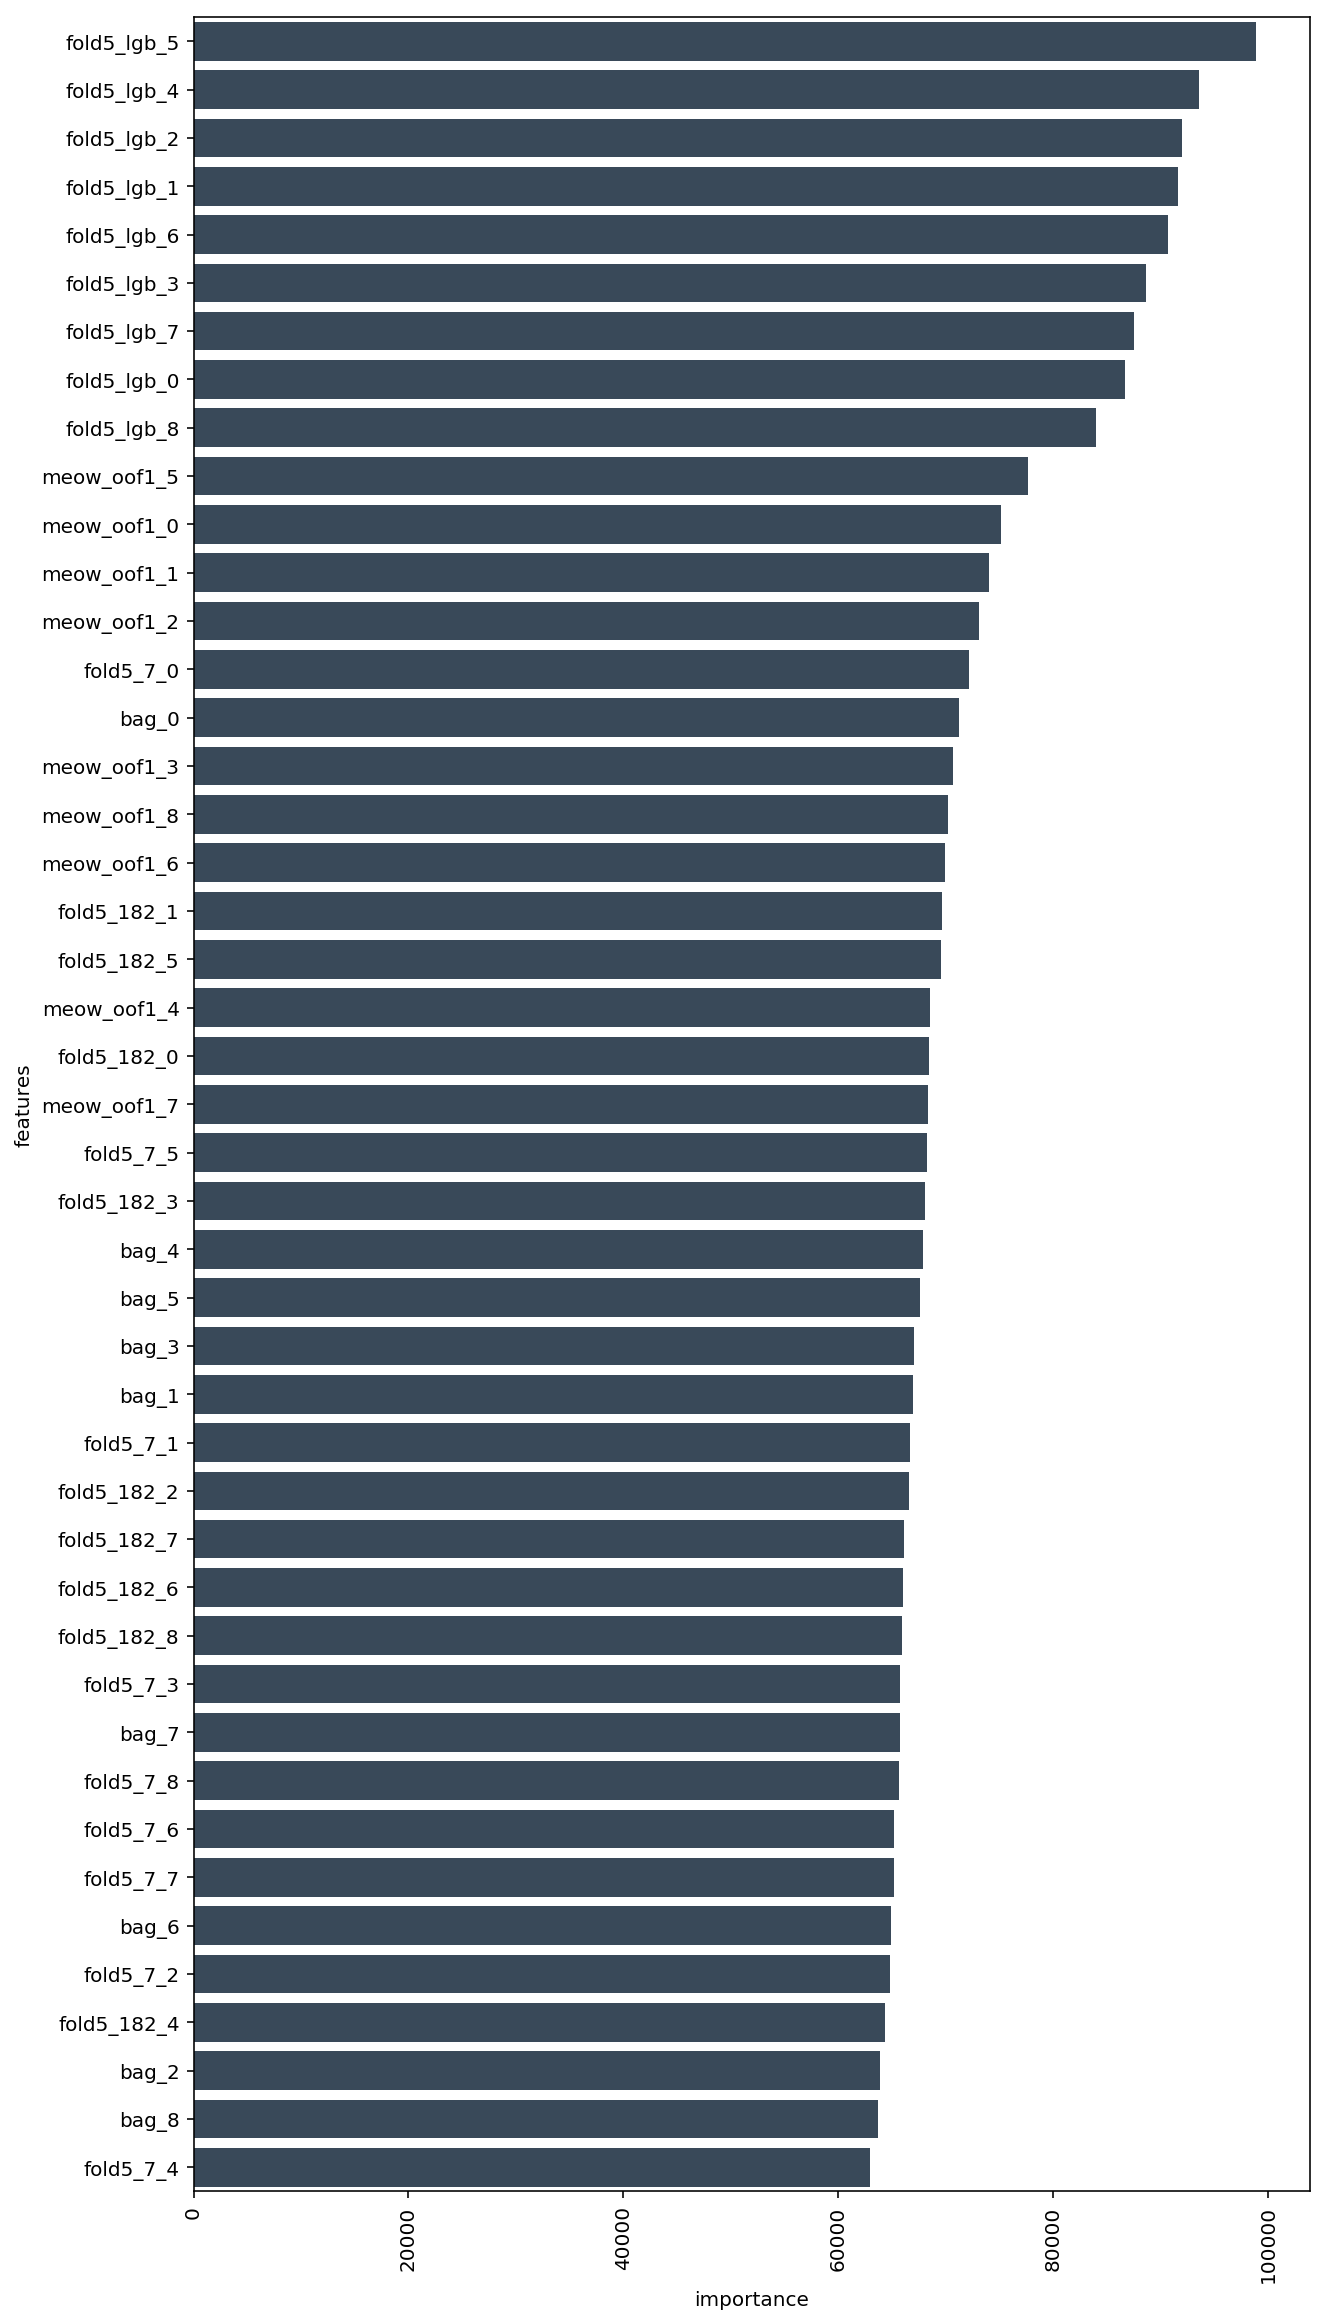

In [87]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

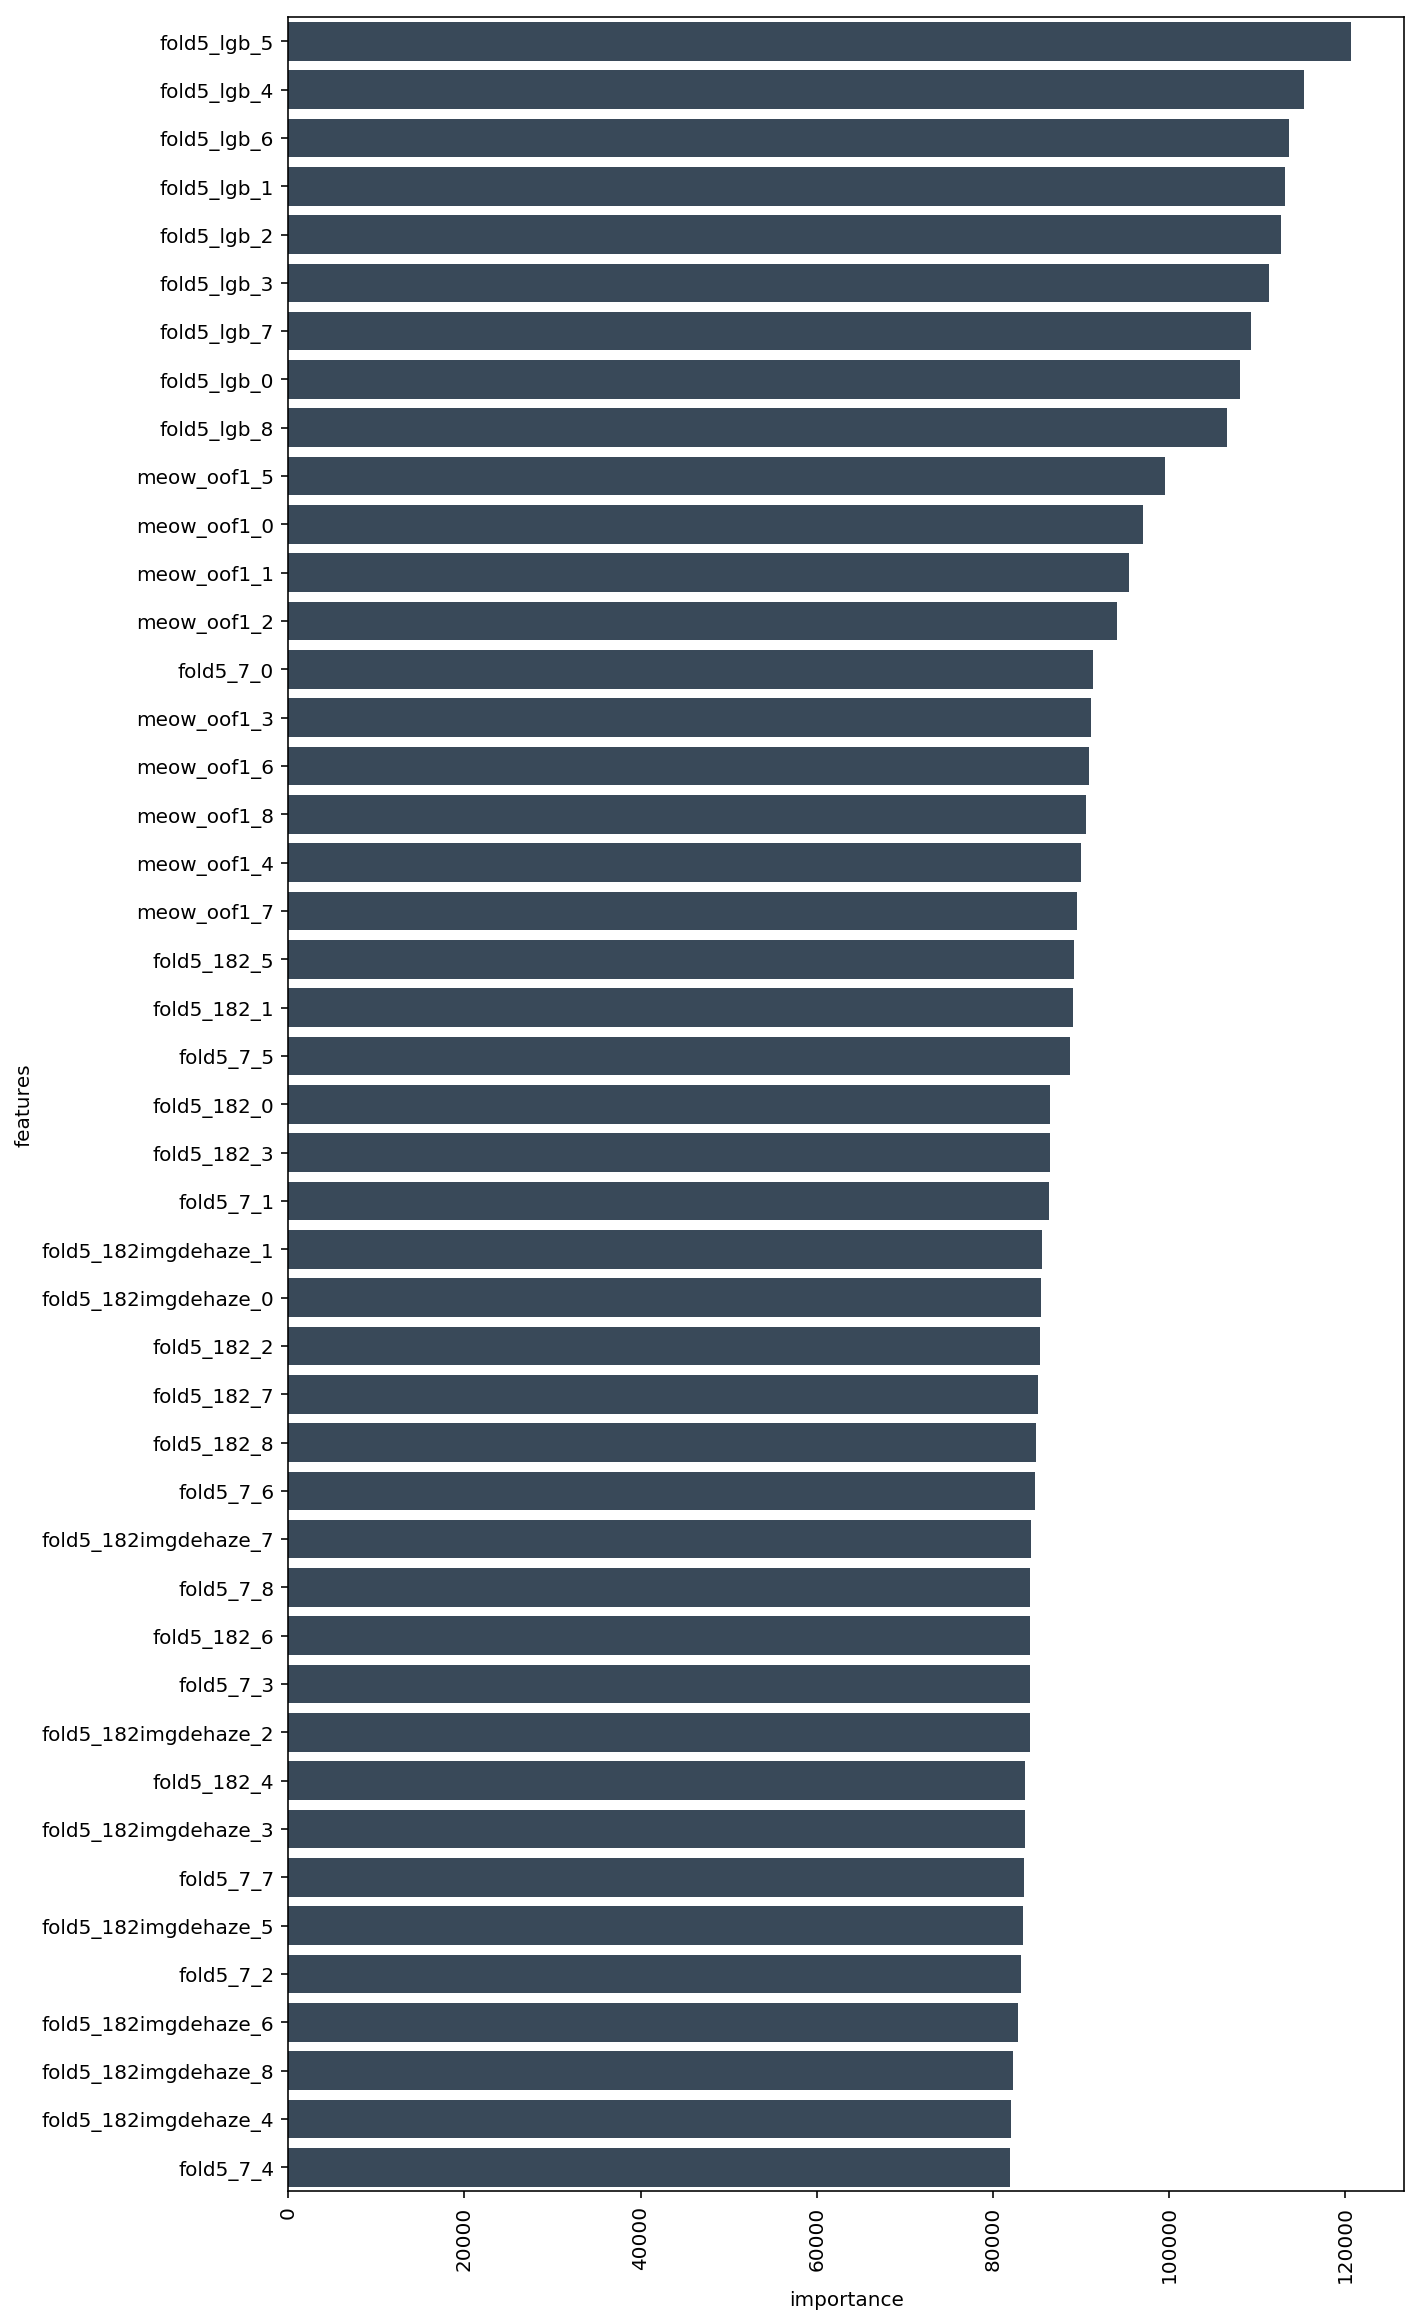

In [64]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

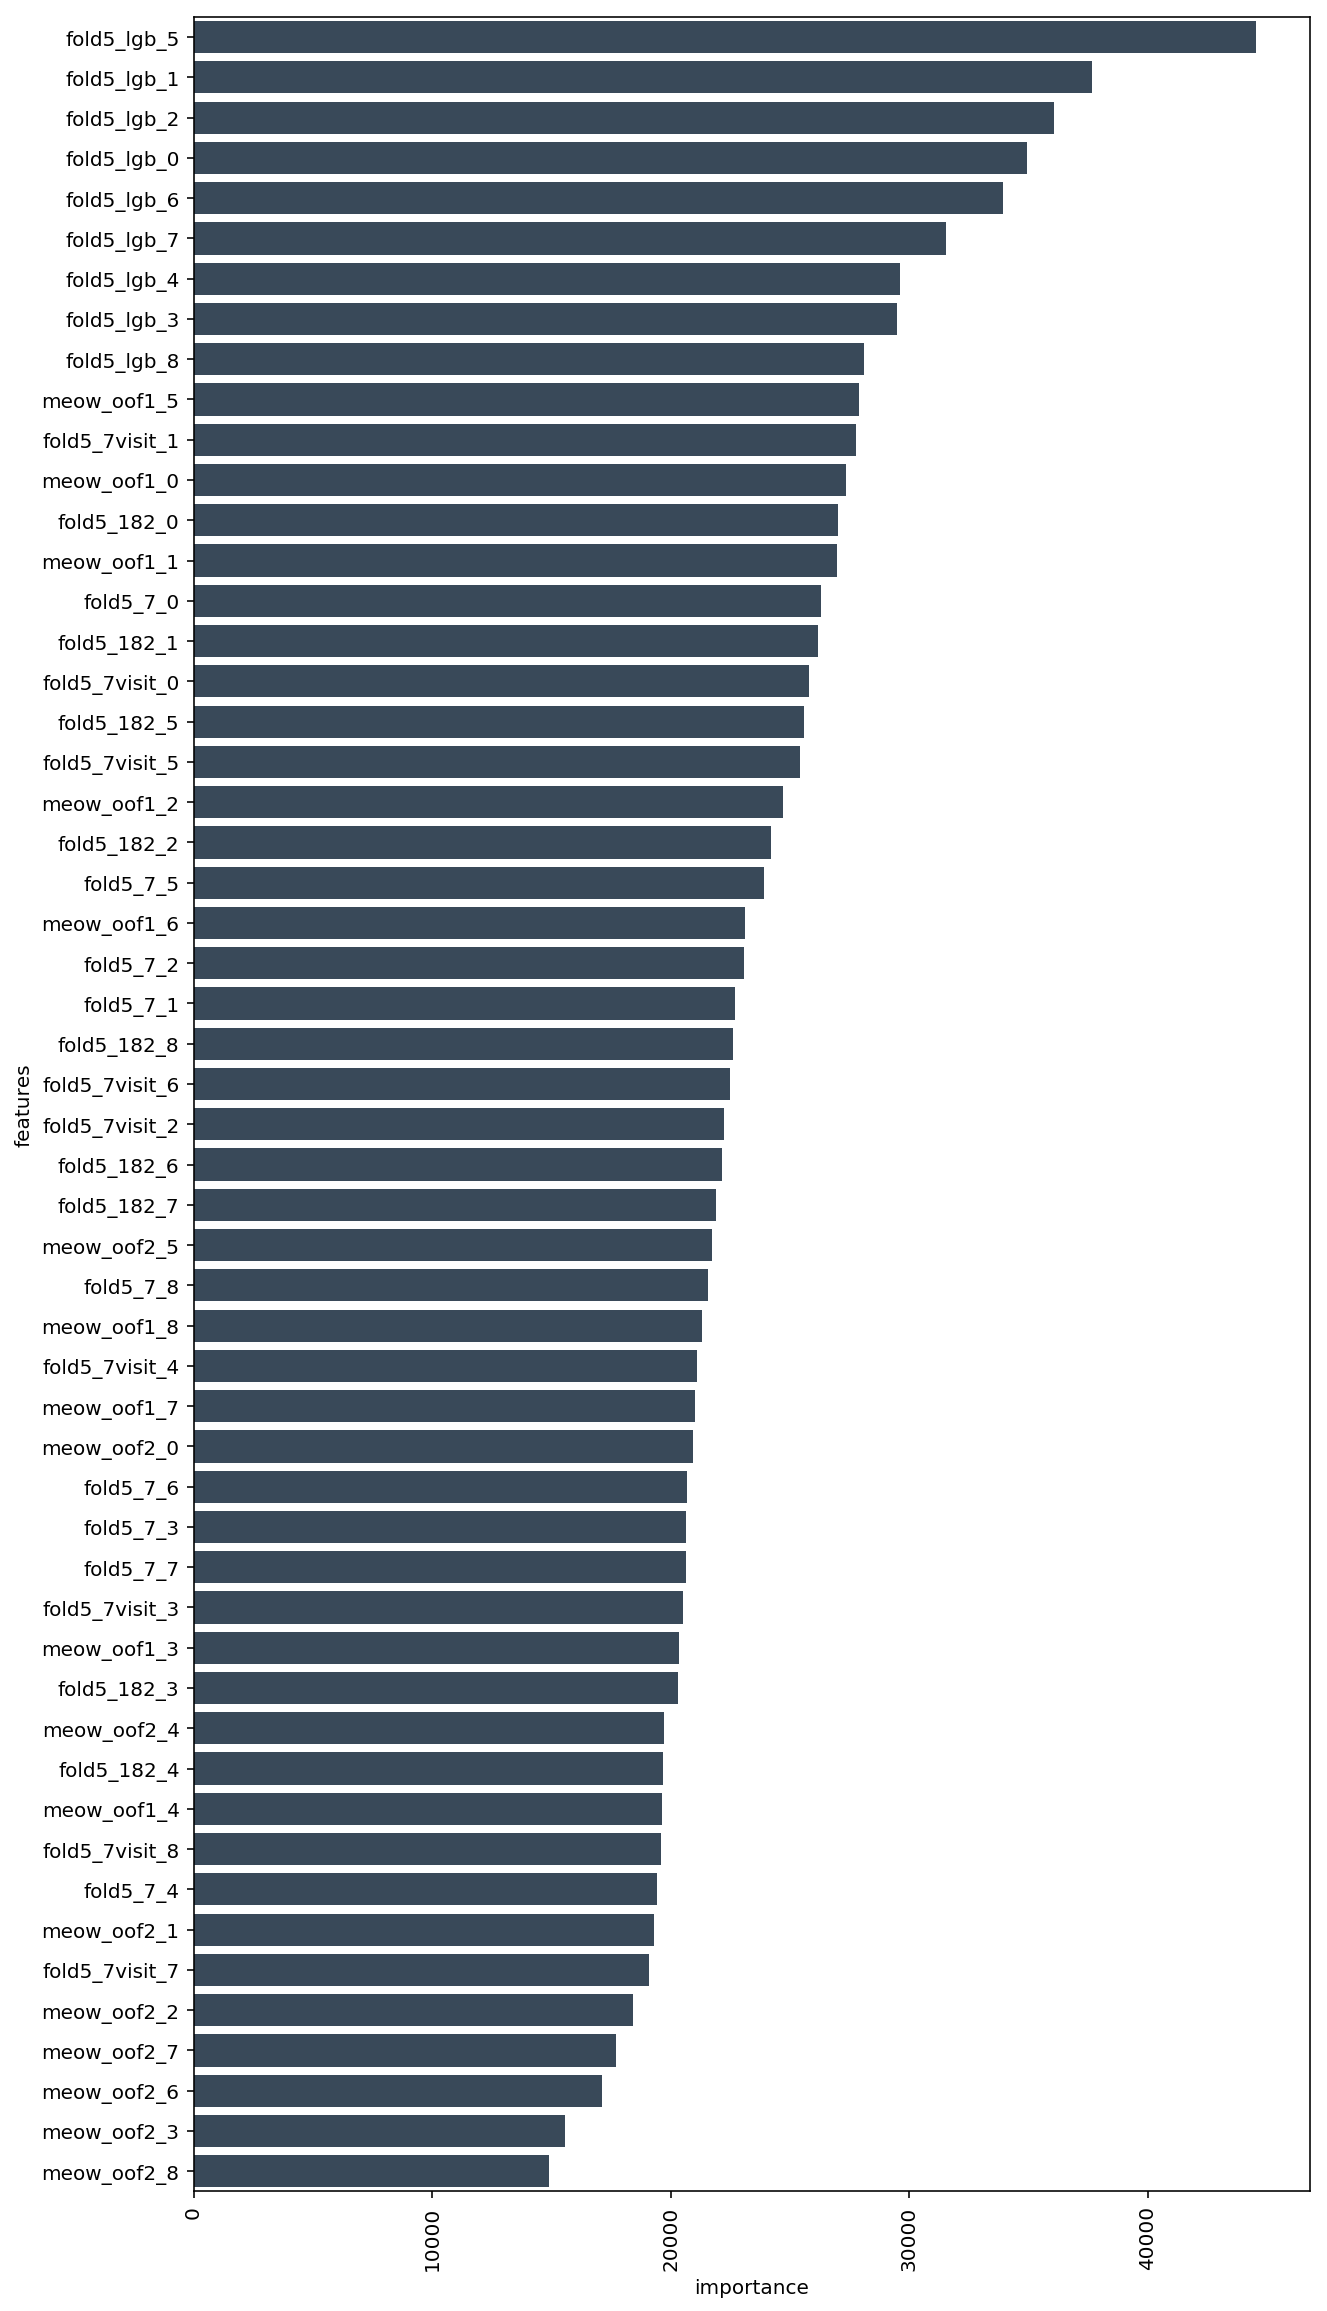

In [83]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

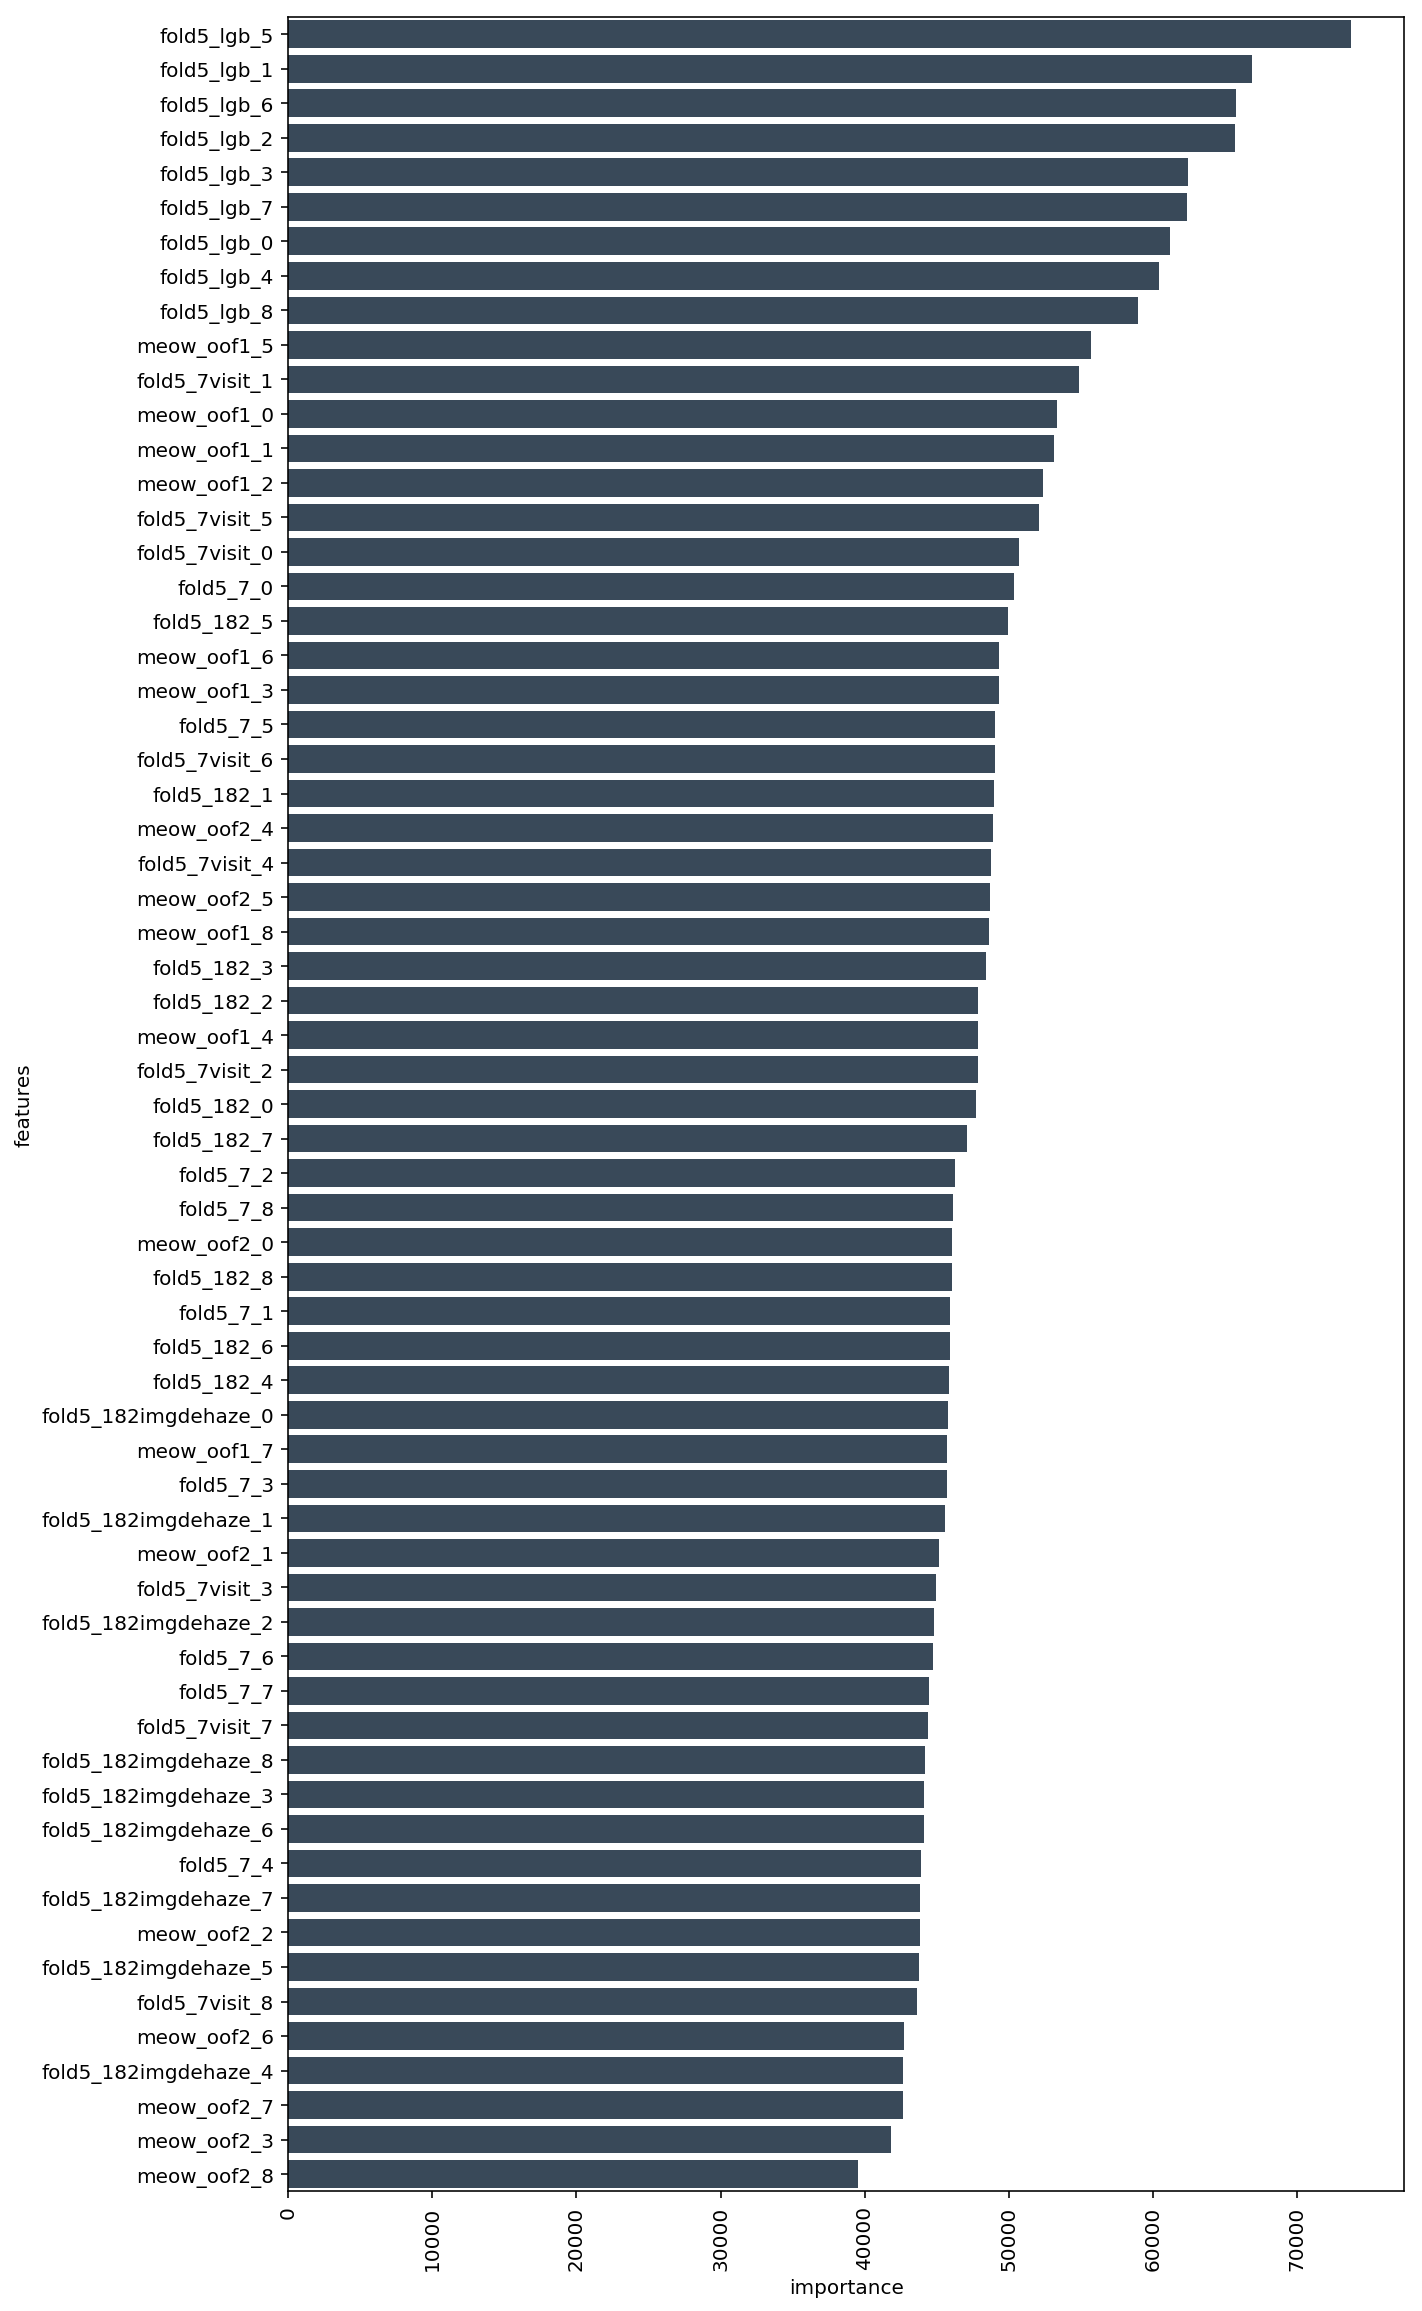

In [89]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

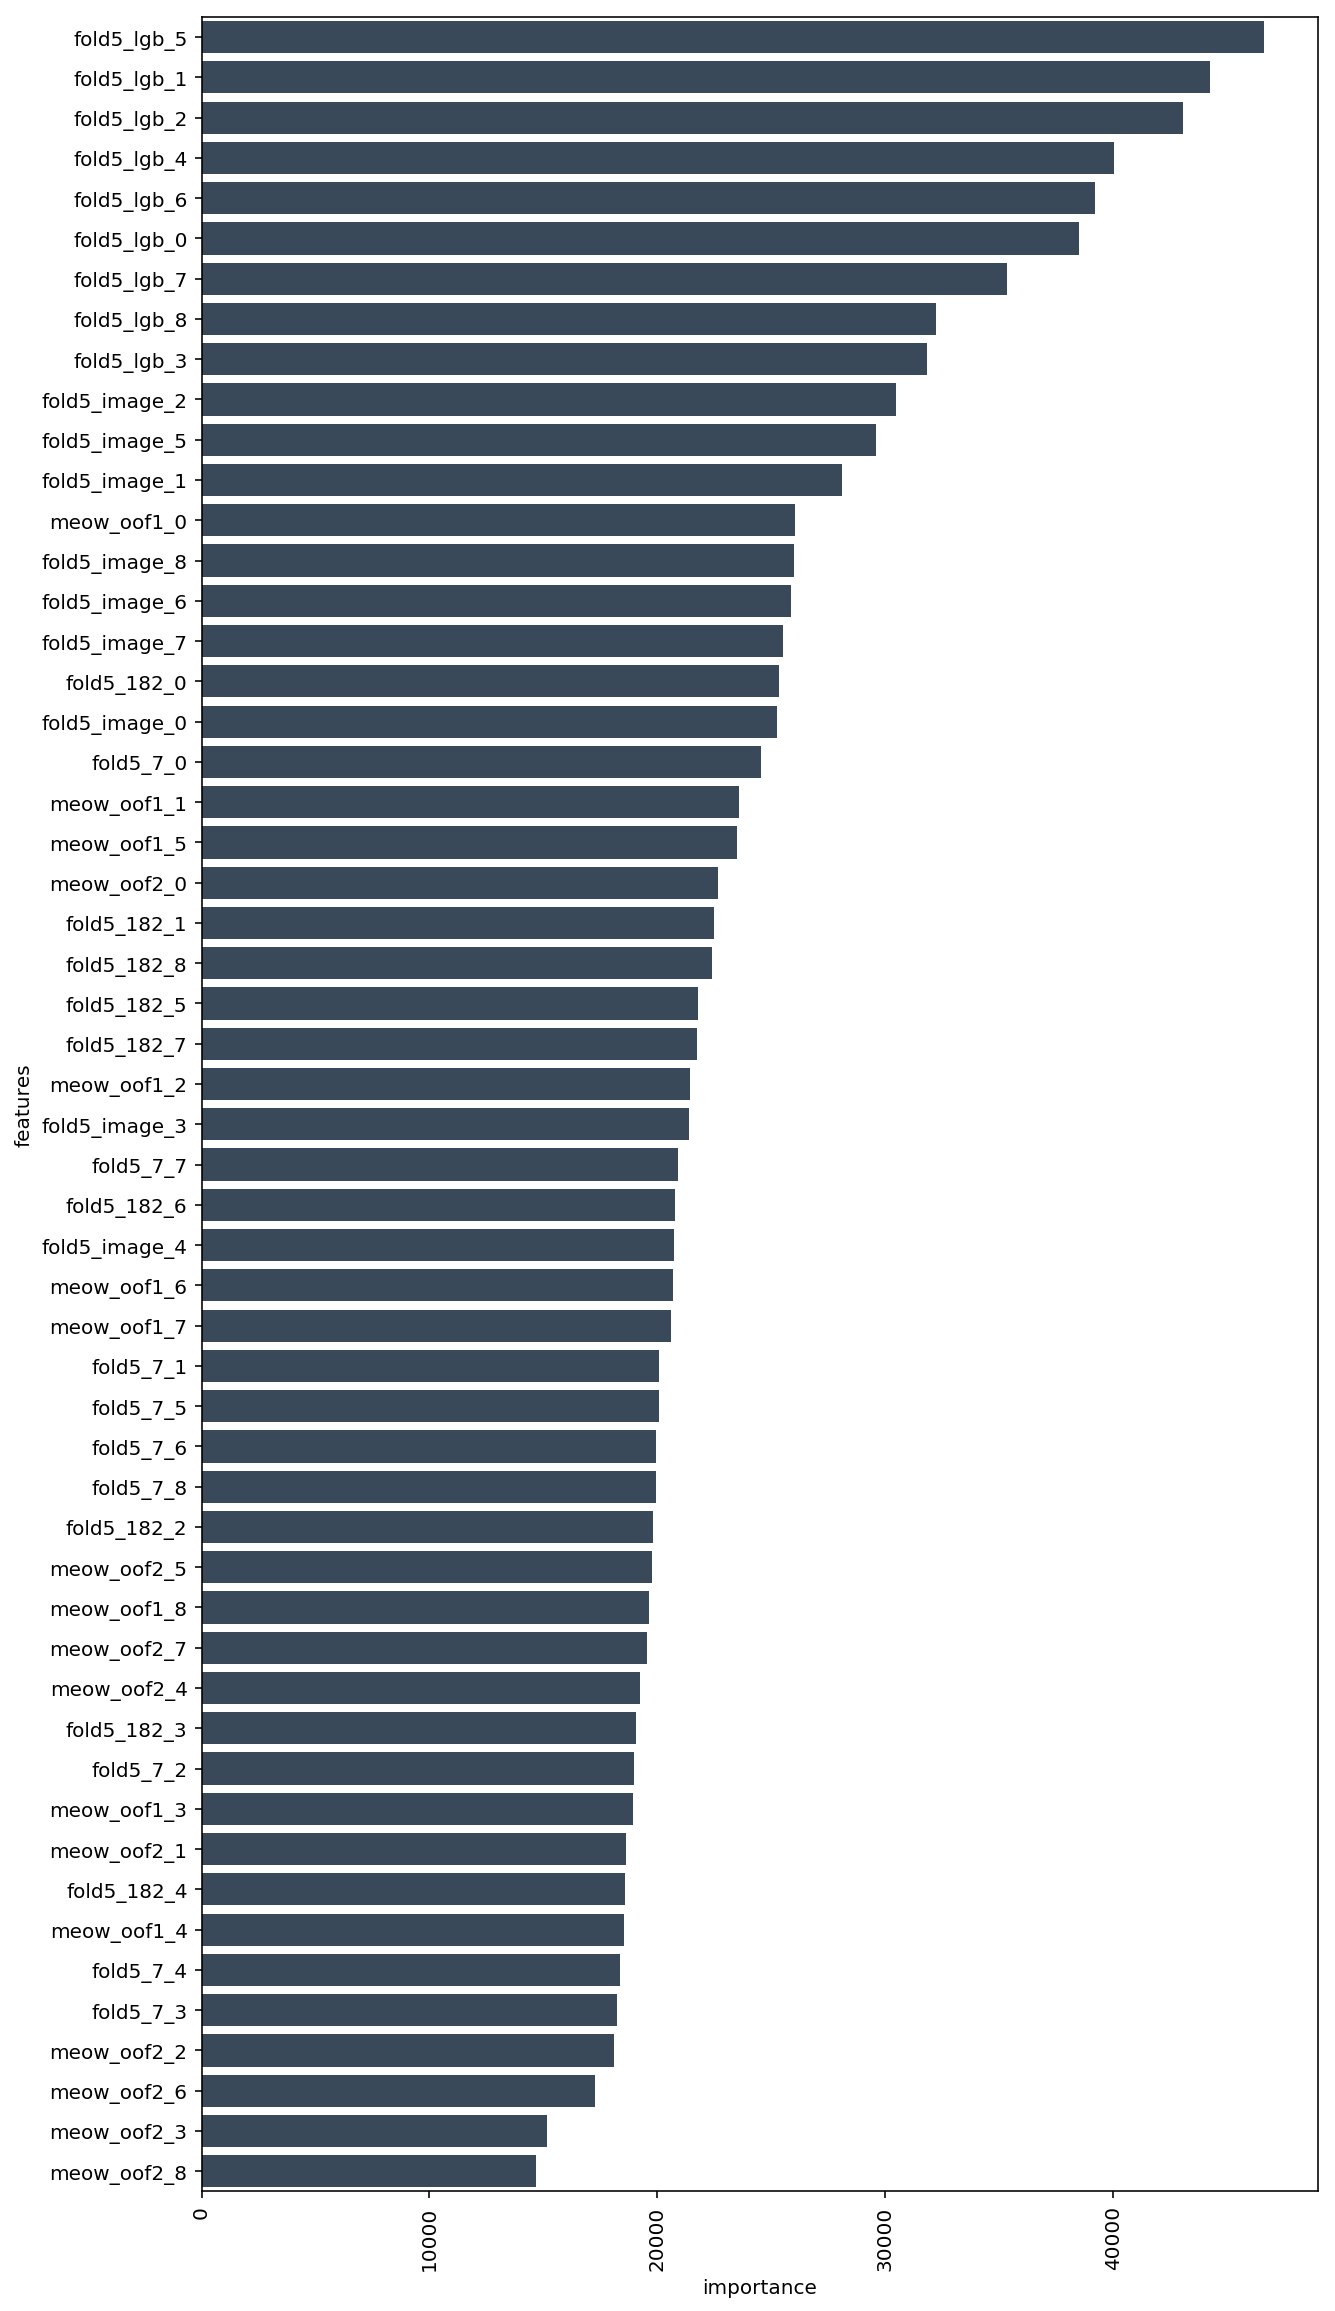

In [90]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

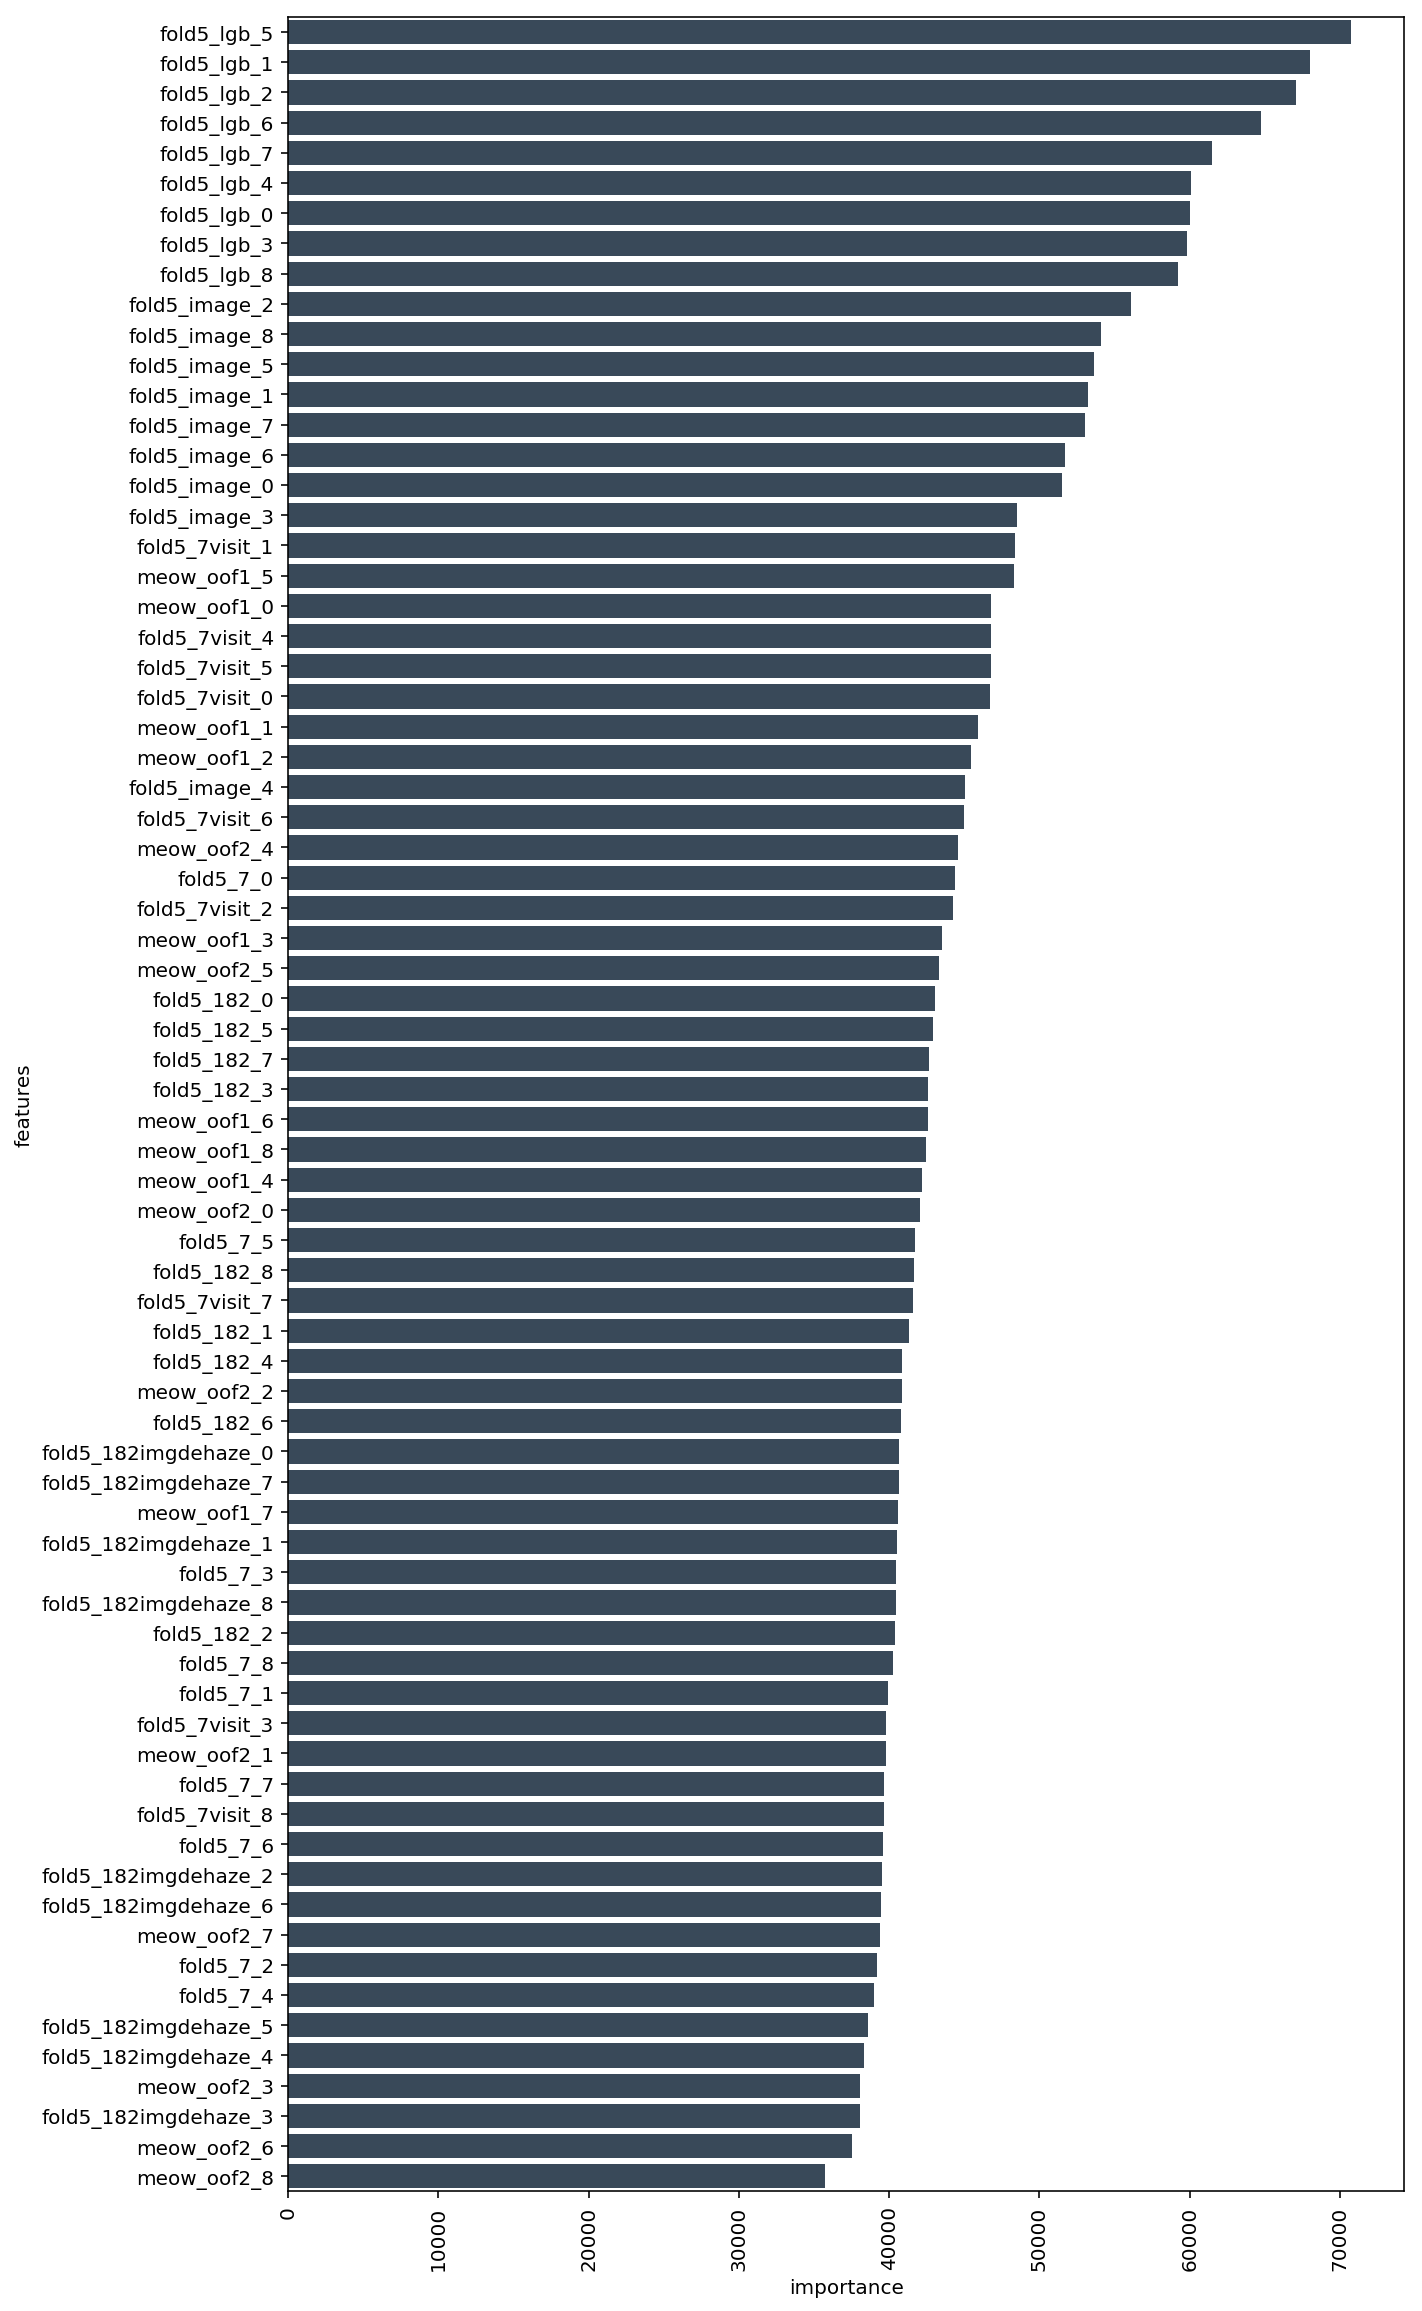

In [99]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

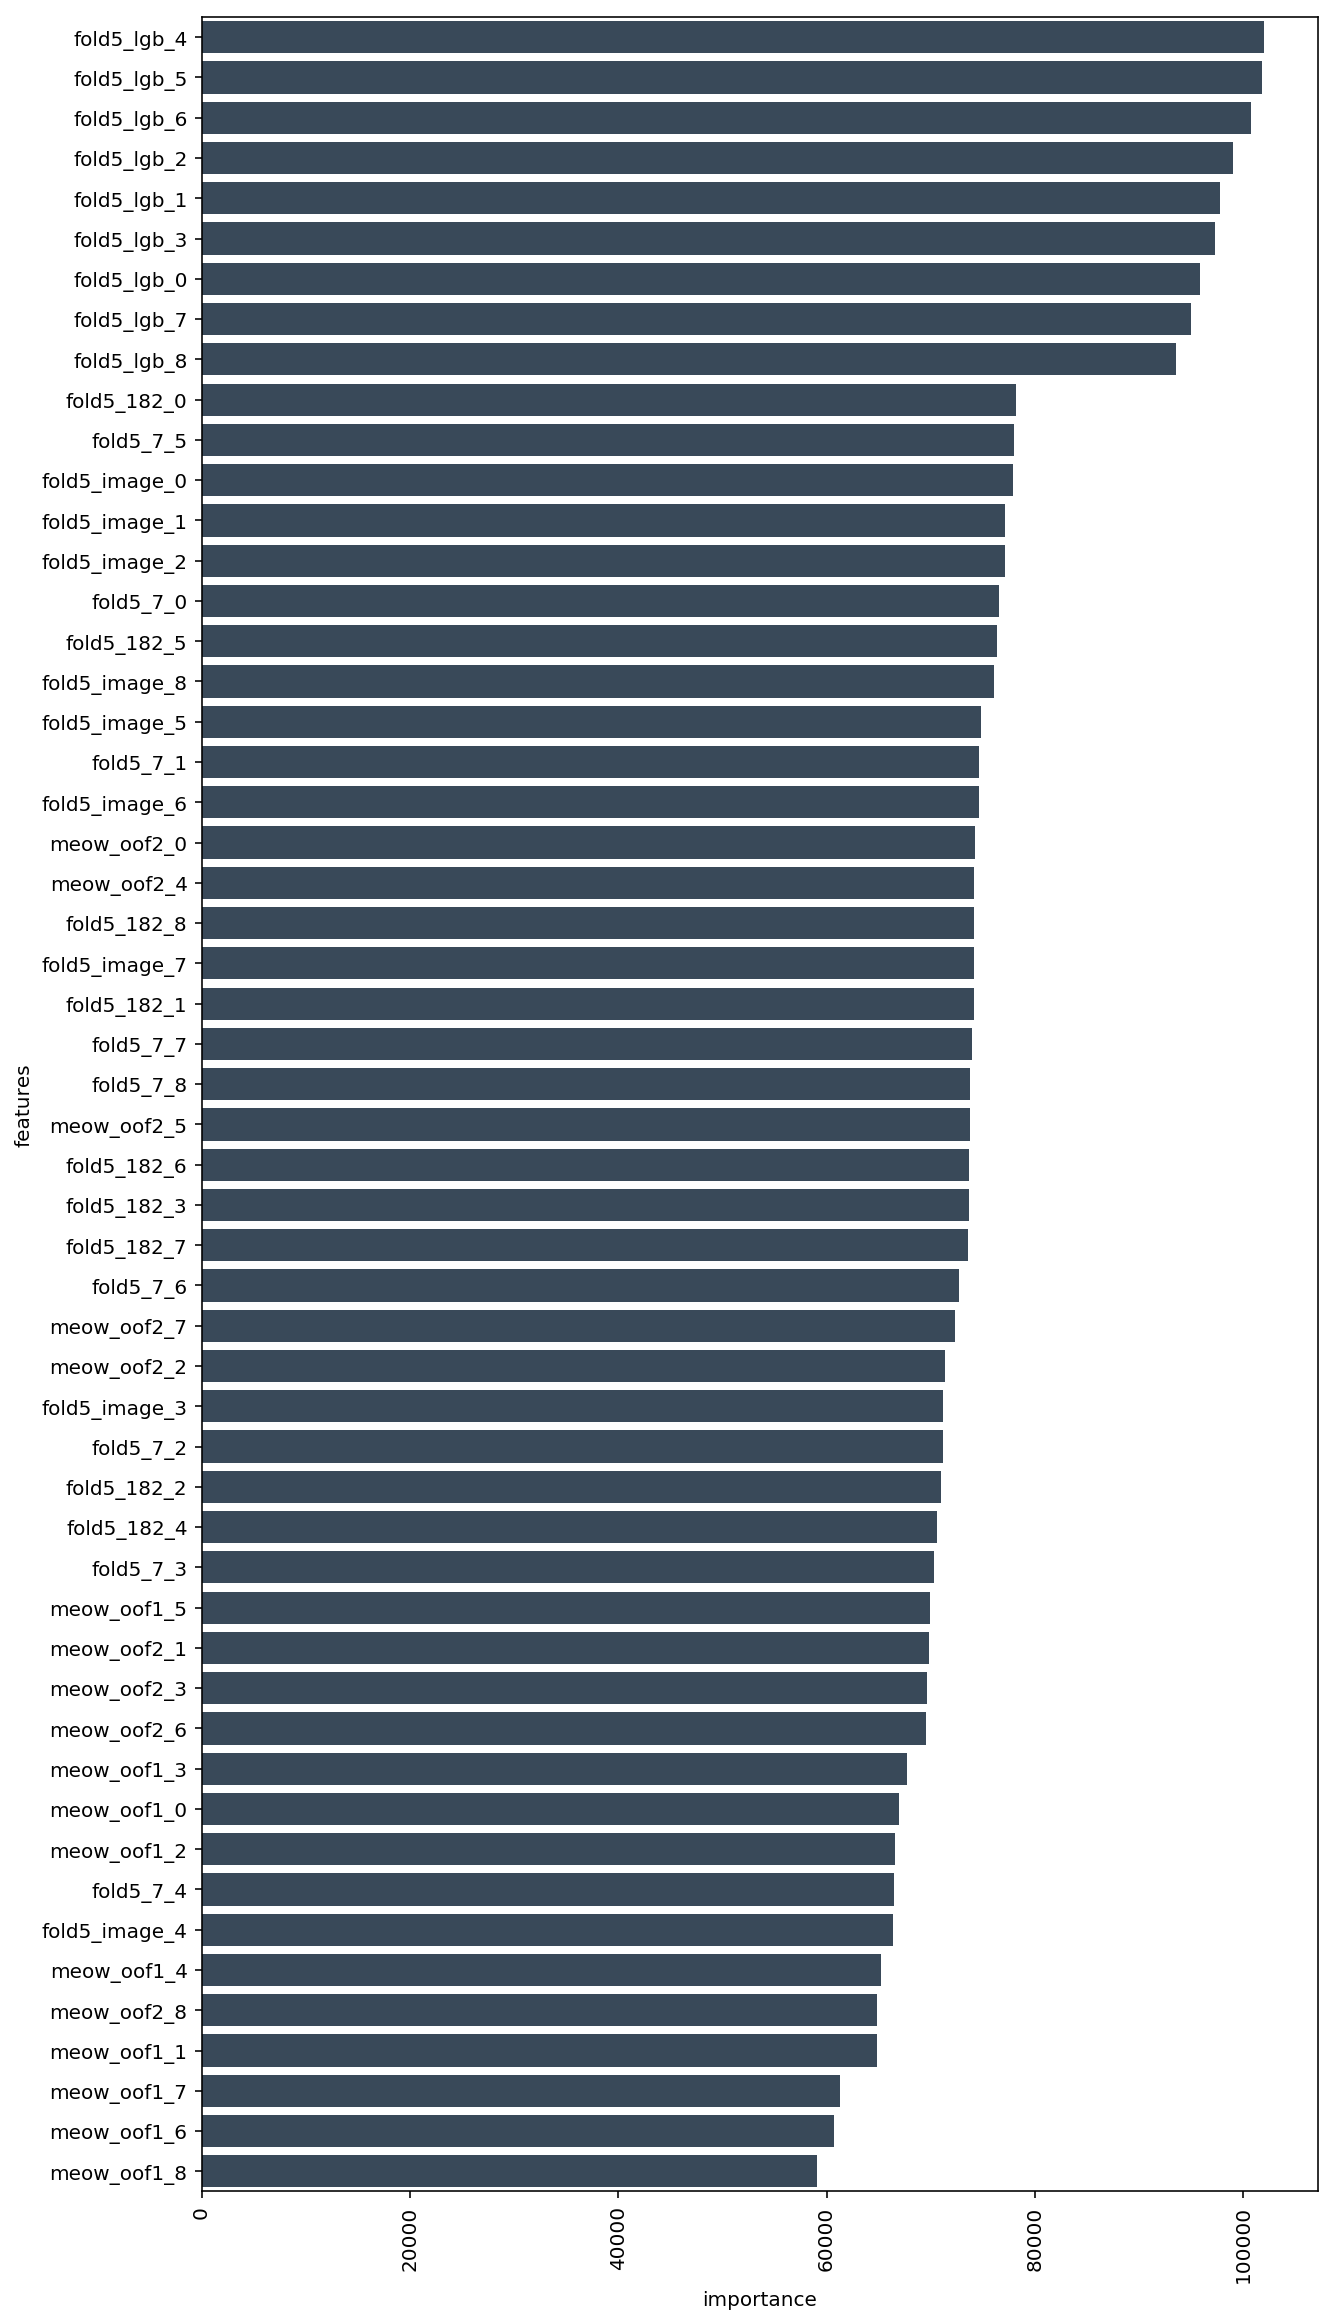

In [83]:
# clf = models[0]
features = pd.DataFrame()
features['features'] = gbm.feature_name()
features['importance'] = gbm.feature_importance()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [31]:
result_tr = []
for im in range(9):
    print("Loading model ", im)
    gbm = lgb.Booster(model_file="./models/lgb/lgb_stacking_9fold63leaves_%s.txt"%im)
    pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
    result_tr.append(pred_test)

Loading model  0
Loading model  1
Loading model  2
Loading model  3
Loading model  4
Loading model  5
Loading model  6
Loading model  7
Loading model  8


In [188]:
pred_tests.shape

(9, 100000, 9)

In [ ]:
pred_tests = []
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    val_data_list = train_df.iloc[val_idx]
    m = lgb.lo[fold]
    pred_test = m.predict(val_data_list[train_features].values, num_iteration=m.best_iteration)
    pred_tests.append(pred_test)
    print("acc:",accuracy_score(val_data_list['Target'].values, np.argmax(pred_val,axis=1)))

#### 算术平均法

In [ ]:
test_df.loc[:, features182_col].values*0.4 + test_df.loc[:, fea].values*0.4

In [85]:
result = np.mean(pred_tests, 0)
# result = np.argmax(result,axis=1)
print(result.shape)

(100000, 9)
(100000, 9)


In [151]:
result = pred_tests

In [73]:
result_lgb = np.mean(result, 0)

In [68]:
bag_dehaze73 = (test_df.loc[:, features182imgdehaze_col].values*0.75 + test_df.loc[:, featuresmeowoof2_col].values*0.25)

In [86]:
ID_values[:, 1] = np.argmax(result, 1)#result*0.1 + result_lgb*0.9
ID_values

array([[    0,     0],
       [    1,     6],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

array([[    0,     0],
       [    1,     6],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

In [154]:
with open("./submit/0724bagging40401505.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

In [87]:
with open("./submit/0731stacking_lgb_192imgwith7addcs_adduserstats_weekendacc697_192img_639fmean.txt", "w") as f:#7visit_imgdehaze
    for ID, pred in ID_values:#
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

In [70]:
with open("./submit/0726baghaze&m27525.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

In [118]:
with open("./submit/0722stacking_lgb_with7addcs_639fmean_pse09.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

In [58]:
with open("./submit/0720stacking_nn10+lgb90_with7addcs_9fmean.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))

#### 投票法

In [88]:
pred_votes = [np.argmax(_v, 1) for _v in pred_tests]
pred_votes = np.squeeze(pred_votes)

In [89]:
vote_result = [np.argmax(np.bincount(pred_votes[:, i])) for i in range(100000)]    

In [90]:
vote_result

[0,
 6,
 0,
 0,
 0,
 1,
 0,
 2,
 5,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 2,
 5,
 5,
 2,
 0,
 0,
 2,
 5,
 2,
 0,
 5,
 5,
 5,
 2,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 5,
 2,
 0,
 0,
 2,
 6,
 5,
 5,
 0,
 5,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 5,
 0,
 0,
 5,
 0,
 5,
 2,
 0,
 5,
 1,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 5,
 2,
 5,
 6,
 2,
 5,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 8,
 2,
 2,
 5,
 2,
 2,
 2,
 5,
 0,
 5,
 5,
 2,
 2,
 2,
 5,
 2,
 2,
 0,
 5,
 0,
 5,
 0,
 0,
 2,
 0,
 1,
 5,
 2,
 1,
 5,
 5,
 0,
 0,
 0,
 5,
 0,
 5,
 0,
 0,
 0,
 5,
 5,
 5,
 5,
 0,
 5,
 0,
 2,
 5,
 2,
 0,
 2,
 1,
 2,
 5,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 5,
 6,
 1,
 5,
 5,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 5,
 5,
 0,
 0,
 5,
 0,
 0,
 2,
 5,
 2,
 5,
 5,
 0,
 2,
 2,
 0,
 1,
 5,
 5,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 5,
 2,
 2,
 0,
 8,
 0,
 0,
 0,
 5,
 0,
 1,
 5,
 0,
 5,
 2,
 0,
 5,
 0,
 5,
 0,
 0,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 2,
 6,
 0,
 5,
 0,
 0,
 4,
 0,
 5,
 2,
 2,
 0,
 2,
 2,
 5,
 2,
 5,
 5,
 0,
 5,
 2,
 2,
 0,
 5,
 0,


[0,
 6,
 0,
 0,
 0,
 1,
 0,
 2,
 5,
 5,
 0,
 5,
 0,
 0,
 0,
 2,
 2,
 5,
 5,
 2,
 0,
 0,
 2,
 5,
 2,
 0,
 5,
 5,
 5,
 2,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 5,
 2,
 0,
 0,
 2,
 6,
 5,
 5,
 0,
 5,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 5,
 0,
 0,
 5,
 0,
 5,
 2,
 0,
 5,
 1,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 5,
 2,
 5,
 6,
 2,
 5,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 8,
 2,
 2,
 5,
 2,
 2,
 2,
 5,
 0,
 5,
 5,
 2,
 2,
 2,
 5,
 2,
 2,
 0,
 5,
 0,
 5,
 0,
 0,
 2,
 0,
 1,
 5,
 2,
 1,
 5,
 5,
 0,
 0,
 0,
 5,
 0,
 5,
 0,
 0,
 0,
 5,
 5,
 5,
 5,
 0,
 5,
 0,
 2,
 5,
 2,
 0,
 2,
 1,
 2,
 5,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 5,
 6,
 1,
 5,
 5,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 5,
 5,
 0,
 0,
 5,
 0,
 0,
 2,
 5,
 2,
 5,
 5,
 0,
 2,
 2,
 0,
 1,
 5,
 5,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 5,
 2,
 2,
 0,
 8,
 0,
 0,
 0,
 5,
 0,
 1,
 5,
 0,
 5,
 2,
 0,
 5,
 0,
 5,
 0,
 0,
 5,
 0,
 0,
 5,
 0,
 0,
 0,
 2,
 6,
 0,
 5,
 0,
 0,
 4,
 0,
 5,
 2,
 2,
 0,
 2,
 2,
 5,
 2,
 5,
 5,
 0,
 5,
 2,
 2,
 0,
 5,
 0,


In [91]:
ID_values[:, 1] = vote_result

In [163]:
ID_values[:, 1] = _res - 1

In [92]:
ID_values

array([[    0,     0],
       [    1,     6],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

array([[    0,     0],
       [    1,     6],
       [    2,     0],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

In [152]:
with open("./submit/0725stacking_with7addcs_lgb_noadjlr_adduserstatsacc69_dehaze_639fvote.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s\t%03d\n"%(str(ID).zfill(6), pred+1))

In [93]:
with open("./submit/0731stacking_192imgwith7addcs_lgb_adduserstats_weekendacc69_192img_639fvote.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s\t%03d\n"%(str(ID).zfill(6), pred+1))

In [165]:
with open("./submit/0727bestacc3970_label-0_test.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s\t%03d\n"%(str(ID).zfill(6), pred+1))

In [156]:
_res = np.loadtxt("./submit/0725stacking_lgb_with7addcs_adduserstatsacc69_639fmean.txt").astype(int)

In [158]:
_res = _res[:, 1]

In [160]:
np.bincount(_res)

array([    0, 34088, 21790, 13360,  1435,  4153, 14948,  4547,  2396,
        3283])

In [162]:
_res

array([1, 0, 1, ..., 1, 1, 1])

In [144]:
np.bincount(_res[:, 1].astype("int"))

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0, 100000])

In [133]:
_res_lgb = np.argmax(test_df.loc[:, featureslgb_col].values, 1)

In [134]:
np.bincount(_res_lgb)

array([36742, 20564, 13465,   675,  2367, 18008,  3714,  1796,  2669])

In [139]:
np.bincount(_res_lgb)

array([36742,     0,     0,     0,     0,     0,     0,     0,     0,
       63258])

In [138]:
_res_lgb[_res_lgb != 0] = 9

In [161]:
_res[_res != 1] = 0

In [162]:
len(models)

27

### pesudo labels

In [159]:
vote_result = [max(np.bincount(pred_votes[:, i])) for i in range(100000)]    

In [160]:
np.sum(np.array(vote_result) == 9)

96864

In [32]:
pred_tests = result_tr

In [118]:
np.sort(pred_tests, 2)[8][:, -1]

array([0.76431984, 0.37949425, 0.41793897, ..., 0.89419811, 0.83815678,
       0.84131661])

In [151]:
pesudo_idx = [np.sort(pred_tests, 2)[i][:, -1]>0.975 for i in range(9)]

In [152]:
pesudo5_idx = (np.sum(pesudo_idx, 0) == 9)

In [160]:
np.save("./temp/0731pseduo_idx_975.npy", (pesudo5_idx, y_pred_pe))

In [161]:
sum(pesudo5_idx)

5283

5283

In [154]:
y_pred_pe = np.argmax(np.mean(pred_tests, 0), 1)

In [155]:
np.bincount(y_pred_pe[pesudo5_idx])

array([   0, 1830,  770,  128, 1925,  612,   18])

array([   0, 1830,  770,  128, 1925,  612,   18])

In [156]:
y_pred_pe[~pesudo5_idx] = 9

In [157]:
np.bincount(y_pred_pe)

array([    0,  1830,   770,   128,  1925,   612,    18,     0,     0,
       94717])

array([    0,  1830,   770,   128,  1925,   612,    18,     0,     0,
       94717])

In [133]:
np.bincount(y_pred_pe)

array([ 4725,  9172,  5988,   596,  3034,  4482,  1172,   322,  1377,
       69132])

array([ 4725,  9172,  5988,   596,  3034,  4482,  1172,   322,  1377,
       69132])

In [158]:
ID_values[:, 1] = y_pred_pe
ID_values

array([[    0,     9],
       [    1,     9],
       [    2,     9],
       ...,
       [99997,     9],
       [99998,     9],
       [99999,     9]])

array([[    0,     9],
       [    1,     9],
       [    2,     9],
       ...,
       [99997,     9],
       [99998,     9],
       [99999,     9]])

In [159]:
with open("./submit/0731stacking_pesudo975_trainednypseudo.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s\t%03d\n"%(str(ID).zfill(6), pred+1))

* 获取Pseudo数据

In [207]:
test_df.loc[pesudo5_idx]

basename  Target  fold5_7_0  fold5_7_1  fold5_7_2     fold5_7_3  \
15         15.0     0.0   0.000051   0.000002   0.999905  1.399082e-08   
18         18.0     0.0   0.008764   0.003538   0.023933  5.993827e-05   
22         22.0     0.0   0.007249   0.000929   0.990427  5.770043e-08   
23         23.0     0.0   0.000855   0.003592   0.000026  6.801460e-05   
44         44.0     0.0   0.000135   0.000014   0.999799  1.302215e-06   
47         47.0     0.0   0.004251   0.000912   0.985450  7.317566e-07   
59         59.0     0.0   0.000611   0.000523   0.997307  5.331551e-07   
60         60.0     0.0   0.006347   0.001707   0.982027  8.712077e-06   
79         79.0     0.0   0.007590   0.008454   0.979360  2.234745e-04   
80         80.0     0.0   0.006047   0.005007   0.000232  5.032226e-06   
85         85.0     0.0   0.000495   0.000522   0.998039  1.535564e-06   
101       101.0     0.0   0.014334   0.002387   0.000982  6.159319e-06   
102       102.0     0.0   0.000077   0.000024   0.999781  2.181736e-08   
106       106.0     0.0   0.000309   0.000096   0.998699  1.464243e-08   
117       117.0     0.0   0.036415   0.006546   0.014502  1.205551e-04   
139       139.0     0.0   0.005460   0.004295   0.001404  1.303738e-05   
153       153.0     0.0   0.001805   0.001306   0.991773  5.463282e-06   
160       160.0     0.0   0.003165   0.003854   0.985615  1.162663e-05   
176       176.0     0.0   0.008073   0.003951   0.000408  1.707135e-03   
188       188.0     0.0   0.012420   0.002353   0.978182  2.766367e-04   
191       191.0     0.0   0.000701   0.000154   0.998098  1.825881e-05   
208       208.0     0.0   0.009823   0.010768   0.000283  9.440030e-06   
211       211.0     0.0   0.001195   0.002763   0.994445  1.139398e-06   
221       221.0     0.0   0.011039   0.008437   0.013693  5.411416e-05   
225       225.0     0.0   0.000059   0.000017   0.999599  1.874847e-06   
235       235.0     0.0   0.003316   0.003967   0.990119  1.123683e-06   
245       245.0     0.0   0.005850   0.014567   0.973692  2.254410e-06   
246       246.0     0.0   0.003985   0.002289   0.988349  8.310242e-06   
255       255.0     0.0   0.006276   0.007329   0.982459  3.055416e-05   
273       273.0     0.0   0.005074   0.002916   0.006778  4.227563e-04   
...         ...     ...        ...        ...        ...           ...   
99793   99793.0     0.0   0.001946   0.000644   0.994651  3.535208e-06   
99803   99803.0     0.0   0.000974   0.000152   0.998655  1.959899e-06   
99809   99809.0     0.0   0.003446   0.005706   0.986521  8.485408e-04   
99822   99822.0     0.0   0.005643   0.000480   0.991519  6.188997e-05   
99827   99827.0     0.0   0.000497   0.000577   0.989216  1.141521e-06   
99842   99842.0     0.0   0.002087   0.001500   0.982970  5.718840e-04   
99844   99844.0     0.0   0.000022   0.000015   0.999957  5.175287e-10   
99852   99852.0     0.0   0.000964   0.000136   0.997475  1.212466e-05   
99856   99856.0     0.0   0.003985   0.000507   0.972126  5.640799e-06   
99863   99863.0     0.0   0.009221   0.001962   0.000129  2.189125e-05   
99867   99867.0     0.0   0.001085   0.000161   0.998235  8.577827e-08   
99880   99880.0     0.0   0.002613   0.010741   0.980449  2.188664e-06   
99883   99883.0     0.0   0.004819   0.010353   0.000677  3.725935e-06   
99888   99888.0     0.0   0.000087   0.000019   0.999827  3.195981e-07   
99890   99890.0     0.0   0.004296   0.002230   0.985941  1.002092e-05   
99894   99894.0     0.0   0.011083   0.987004   0.000023  2.331722e-06   
99900   99900.0     0.0   0.002037   0.000523   0.991293  7.108300e-06   
99905   99905.0     0.0   0.001394   0.001383   0.992161  8.294722e-07   
99908   99908.0     0.0   0.000677   0.000598   0.996545  1.478930e-06   
99917   99917.0     0.0   0.000921   0.006145   0.991783  2.671158e-07   
99926   99926.0     0.0   0.004586   0.002417   0.988330  4.481143e-05   
99927   99927.0     0.0   0.973234   0.006316   0.000024  3.160496e-04   
99934   999

In [ ]:
pseudo_df = test_df.loc[pesudo5_idx].copy()
k = 9
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2050)
# pseudo_df["Target"] = y_pred_pe
train_index_pse, test_index_pse = [], []
for fold, (train_index, test_index) in enumerate(kf.split(pseudo_df, y_pred_pe)):
    train_index_pre.append(train_index)
    test_index_pre.append(test_index)

### Resnet

In [29]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 3"

In [30]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
set_session(tf.Session(config=config))

/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [31]:
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Lambda, GaussianDropout, CuDNNGRU, BatchNormalization, PReLU
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K

In [32]:
def gru_model():
    x_input = Input(shape=(45,))
    # 主干网络
    x = Dense(128, activation='relu', kernel_initializer='random_uniform')(x_input)#CuDNNGRU(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    x = Dense(64, activation='relu', kernel_initializer='random_uniform')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    x = Dense(32, activation='relu', kernel_initializer='random_uniform')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    x = Dense(16, activation='relu', kernel_initializer='random_uniform')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    out_p = Dense(9, activation='softmax')(x)
    return Model(inputs=x_input, outputs=out_p)

In [263]:
Y_traindummy = pd.get_dummies(Y_train)

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2944      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32)                32        
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
__________

In [ ]:
nn_models = []

pred_tests_nn = []
pred_vals_nn = []
true_vals_nn = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         continue
    train_data_list = train_df.iloc[train_idx]
    train_y = pd.get_dummies(train_data_list["Target"])
    val_data_list = train_df.iloc[val_idx]
    val_y = pd.get_dummies(val_data_list["Target"])
    
    K.clear_session()
    tf.reset_default_graph()
    model = gru_model()
    batch_size = 512  # 20000 512
    epochs = 99

    steps = int(len(train_df) / batch_size) * epochs
    exp_decay = lambda init, fin, steps: (init / fin) ** (1 / (steps - 1)) - 1
    lr_init, lr_fin = 0.001, 0.0001
    lr_decay = exp_decay(lr_init, lr_fin, steps)
    optimizer_adam = Adam(lr=0.001, decay=lr_decay)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    filepath="./models/best_weights_%s.h5"%fold
    early_stopping = EarlyStopping(monitor='val_acc', patience=9)
    mc=ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.fit(train_data_list[train_features], train_y, callbacks=[early_stopping, mc], 
              validation_data=(val_data_list[train_features], val_y), 
              batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)
    nn_models.append(model)
    pred_test_nn = model.predict(test_df[train_features])
    pred_tests_nn.append(pred_test_nn)
    pred_val_nn = model.predict(val_data_list[train_features])
    pred_vals_nn.append(pred_val_nn)
    true_vals_nn.append(val_data_list["Target"].values)
pred_tests_nn = np.array(pred_tests_nn)

fold: 0
Train on 355552 samples, validate on 44448 samples
Epoch 1/99
355552/355552 [==============================] - 14s 39us/step - loss: 0.9267 - acc: 0.7328 - val_loss: 0.8036 - val_acc: 0.7524

Epoch 00001: val_acc improved from -inf to 0.75238, saving model to ./models/best_weights_0.h5
Epoch 2/99
355552/355552 [==============================] - 12s 35us/step - loss: 0.8370 - acc: 0.7425 - val_loss: 0.7879 - val_acc: 0.7538

Epoch 00002: val_acc improved from 0.75238 to 0.75385, saving model to ./models/best_weights_0.h5
Epoch 3/99
355552/355552 [==============================] - 13s 35us/step - loss: 0.8252 - acc: 0.7447 - val_loss: 0.7776 - val_acc: 0.7547

Epoch 00003: val_acc improved from 0.75385 to 0.75466, saving model to ./models/best_weights_0.h5
Epoch 4/99
355552/355552 [==============================] - 12s 33us/step - loss: 0.8184 - acc: 0.7458 - val_loss: 0.7752 - val_acc: 0.7554

Epoch 00004: val_acc improved from 0.75466 to 0.75542, saving model to ./models/best_w


Epoch 00040: val_acc did not improve from 0.75907
Epoch 41/99
355552/355552 [==============================] - 11s 30us/step - loss: 0.7866 - acc: 0.7522 - val_loss: 0.7583 - val_acc: 0.7582

Epoch 00041: val_acc did not improve from 0.75907
Epoch 42/99
355552/355552 [==============================] - 11s 31us/step - loss: 0.7877 - acc: 0.7518 - val_loss: 0.7574 - val_acc: 0.7587

Epoch 00042: val_acc did not improve from 0.75907
Epoch 43/99
355552/355552 [==============================] - 12s 34us/step - loss: 0.7866 - acc: 0.7528 - val_loss: 0.7571 - val_acc: 0.7584

Epoch 00043: val_acc did not improve from 0.75907
Epoch 44/99
355552/355552 [==============================] - 12s 33us/step - loss: 0.7874 - acc: 0.7520 - val_loss: 0.7574 - val_acc: 0.7582

Epoch 00044: val_acc did not improve from 0.75907
Epoch 45/99
355552/355552 [==============================] - 12s 33us/step - loss: 0.7871 - acc: 0.7516 - val_loss: 0.7598 - val_acc: 0.7569

Epoch 00045: val_acc did not improve fr

355553/355553 [==============================] - 10s 29us/step - loss: 0.7942 - acc: 0.7505 - val_loss: 0.7651 - val_acc: 0.7528

Epoch 00019: val_acc did not improve from 0.75348
Epoch 20/99
355553/355553 [==============================] - 11s 30us/step - loss: 0.7937 - acc: 0.7511 - val_loss: 0.7663 - val_acc: 0.7530

Epoch 00020: val_acc did not improve from 0.75348
Epoch 21/99
355553/355553 [==============================] - 10s 29us/step - loss: 0.7926 - acc: 0.7510 - val_loss: 0.7654 - val_acc: 0.7524

Epoch 00021: val_acc did not improve from 0.75348
Epoch 22/99
355553/355553 [==============================] - 10s 28us/step - loss: 0.7919 - acc: 0.7512 - val_loss: 0.7629 - val_acc: 0.7530

Epoch 00022: val_acc did not improve from 0.75348
Epoch 23/99
355553/355553 [==============================] - 12s 32us/step - loss: 0.7923 - acc: 0.7509 - val_loss: 0.7649 - val_acc: 0.7529

Epoch 00023: val_acc did not improve from 0.75348
Epoch 24/99
355553/355553 [=========================

355556/355556 [==============================] - 11s 30us/step - loss: 0.8022 - acc: 0.7485 - val_loss: 0.7635 - val_acc: 0.7554

Epoch 00010: val_acc improved from 0.75473 to 0.75542, saving model to ./models/best_weights_4.h5
Epoch 11/99
355556/355556 [==============================] - 10s 29us/step - loss: 0.8001 - acc: 0.7490 - val_loss: 0.7638 - val_acc: 0.7559

Epoch 00011: val_acc improved from 0.75542 to 0.75594, saving model to ./models/best_weights_4.h5
Epoch 12/99
355556/355556 [==============================] - 11s 30us/step - loss: 0.7992 - acc: 0.7494 - val_loss: 0.7655 - val_acc: 0.7553

Epoch 00012: val_acc did not improve from 0.75594
Epoch 13/99
355556/355556 [==============================] - 10s 29us/step - loss: 0.7985 - acc: 0.7492 - val_loss: 0.7639 - val_acc: 0.7563

Epoch 00013: val_acc improved from 0.75594 to 0.75628, saving model to ./models/best_weights_4.h5
Epoch 14/99
355556/355556 [==============================] - 10s 29us/step - loss: 0.7988 - acc: 0.7

355556/355556 [==============================] - 11s 30us/step - loss: 0.7848 - acc: 0.7521 - val_loss: 0.7571 - val_acc: 0.7578

Epoch 00050: val_acc did not improve from 0.75842
Epoch 51/99
355556/355556 [==============================] - 10s 28us/step - loss: 0.7845 - acc: 0.7522 - val_loss: 0.7567 - val_acc: 0.7577

Epoch 00051: val_acc did not improve from 0.75842
Epoch 52/99
355556/355556 [==============================] - 11s 30us/step - loss: 0.7842 - acc: 0.7525 - val_loss: 0.7569 - val_acc: 0.7575

Epoch 00052: val_acc did not improve from 0.75842
Epoch 53/99
355556/355556 [==============================] - 10s 28us/step - loss: 0.7850 - acc: 0.7520 - val_loss: 0.7568 - val_acc: 0.7574

Epoch 00053: val_acc did not improve from 0.75842
Epoch 54/99
355556/355556 [==============================] - 10s 29us/step - loss: 0.7838 - acc: 0.7528 - val_loss: 0.7578 - val_acc: 0.7574

Epoch 00054: val_acc did not improve from 0.75842
Epoch 55/99
355556/355556 [=========================

355558/355558 [==============================] - 13s 36us/step - loss: 0.7993 - acc: 0.7498 - val_loss: 0.7613 - val_acc: 0.7539

Epoch 00012: val_acc did not improve from 0.75543
Epoch 13/99
355558/355558 [==============================] - 13s 36us/step - loss: 0.7985 - acc: 0.7498 - val_loss: 0.7600 - val_acc: 0.7554

Epoch 00013: val_acc did not improve from 0.75543
Epoch 14/99
355558/355558 [==============================] - 11s 31us/step - loss: 0.7975 - acc: 0.7501 - val_loss: 0.7587 - val_acc: 0.7548

Epoch 00014: val_acc did not improve from 0.75543
Epoch 15/99
355558/355558 [==============================] - 11s 30us/step - loss: 0.7961 - acc: 0.7506 - val_loss: 0.7598 - val_acc: 0.7555

Epoch 00015: val_acc improved from 0.75543 to 0.75552, saving model to ./models/best_weights_6.h5
Epoch 16/99
355558/355558 [==============================] - 11s 30us/step - loss: 0.7959 - acc: 0.7505 - val_loss: 0.7600 - val_acc: 0.7545

Epoch 00016: val_acc did not improve from 0.75552
Epoc


Epoch 00001: val_acc improved from -inf to 0.75023, saving model to ./models/best_weights_8.h5
Epoch 2/99
355559/355559 [==============================] - 12s 33us/step - loss: 0.8356 - acc: 0.7429 - val_loss: 0.7858 - val_acc: 0.7517

Epoch 00002: val_acc improved from 0.75023 to 0.75169, saving model to ./models/best_weights_8.h5
Epoch 3/99
355559/355559 [==============================] - 11s 31us/step - loss: 0.8242 - acc: 0.7452 - val_loss: 0.7804 - val_acc: 0.7518

Epoch 00003: val_acc improved from 0.75169 to 0.75183, saving model to ./models/best_weights_8.h5
Epoch 4/99
355559/355559 [==============================] - 11s 30us/step - loss: 0.8171 - acc: 0.7462 - val_loss: 0.7779 - val_acc: 0.7525

Epoch 00004: val_acc improved from 0.75183 to 0.75248, saving model to ./models/best_weights_8.h5
Epoch 5/99
355559/355559 [==============================] - 11s 31us/step - loss: 0.8122 - acc: 0.7466 - val_loss: 0.7778 - val_acc: 0.7515

Epoch 00005: val_acc did not improve from 0.75

In [ ]:
test_df = get_keras_data(test_df, category, numerical)

print("predicting....")
test_y = model.predict(test_df, batch_size=batch_size)

In [42]:
pred_tests_nn = []
pred_vals_nn = []
true_vals_nn = []
# feature = ['len']+q+p+['sum_div_len','sum','argmax_p','argmax_q']#,'maxpq','argmin_p','argmin_q','minpq'
# lgb_models = []
# train_data_list,val_data_list = train_test_split(temp, test_size=0.1, random_state = 2019)
skf = StratifiedKFold(n_splits=9, random_state=2050, shuffle=False)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    print('fold:', fold)
#     if fold in [0]:
#         pred_test = gbm.predict(test_df[train_features].values, num_iteration=gbm.best_iteration)
#         pred_tests.append(pred_test)
#         continue
    train_data_list = train_df.iloc[train_idx]
    train_y = pd.get_dummies(train_data_list["Target"])
    val_data_list = train_df.iloc[val_idx]
    val_y = pd.get_dummies(val_data_list["Target"])
    
    K.clear_session()
    tf.reset_default_graph()
    model = gru_model()
    batch_size = 512  # 20000 512
    epochs = 99
   
    steps = int(len(train_df) / batch_size) * epochs
    exp_decay = lambda init, fin, steps: (init / fin) ** (1 / (steps - 1)) - 1
    lr_init, lr_fin = 0.001, 0.0001
    lr_decay = exp_decay(lr_init, lr_fin, steps)
    optimizer_adam = Adam(lr=0.001, decay=lr_decay)
    
    model.load_weights("./models/best_weights_%s.h5"%fold)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])
    
    pred_test_nn = model.predict(test_df[train_features])
    pred_tests_nn.append(pred_test_nn)

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8


In [45]:
pred_tests_nn[2]

array([[0.7914212 , 0.05244831, 0.00441137, ..., 0.01767706, 0.01520817,
        0.08226795],
       [0.12274434, 0.04560827, 0.52480716, ..., 0.15089126, 0.02457731,
        0.01067989],
       [0.16848272, 0.04066022, 0.6682233 , ..., 0.07055787, 0.00980907,
        0.00780236],
       ...,
       [0.9076541 , 0.05576671, 0.00314231, ..., 0.00311965, 0.00158992,
        0.00162538],
       [0.844398  , 0.08527857, 0.01798951, ..., 0.01065493, 0.00636964,
        0.00725878],
       [0.867616  , 0.02320448, 0.0035688 , ..., 0.02331763, 0.00502561,
        0.00709928]], dtype=float32)

In [37]:
pred_test_nn

array([[0.75544685, 0.07259475, 0.00748705, ..., 0.01538223, 0.02400713,
        0.07884488],
       [0.09598067, 0.03313728, 0.5127176 , ..., 0.1738471 , 0.01969653,
        0.00708687],
       [0.17001568, 0.04537507, 0.6188286 , ..., 0.08426763, 0.01227724,
        0.0090856 ],
       ...,
       [0.84776676, 0.07774924, 0.00558068, ..., 0.00350573, 0.00474431,
        0.00303021],
       [0.8046603 , 0.09736934, 0.01772896, ..., 0.01023   , 0.01450815,
        0.00912502],
       [0.84360164, 0.03025661, 0.00516839, ..., 0.02403901, 0.00764679,
        0.00663411]], dtype=float32)

In [ ]:
pred_tests_nn = np.array(pred_tests_nn)
pred_tests_nn.shape

In [347]:
resnet18()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/weiqiang/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 39466656.39it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## 校准

In [83]:
pred_vals = []
true_vals = []
pred_tests = []
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['Target'])):
    val_data_list = train_df.iloc[val_idx]
    m = lgb.Booster(model_file="./models/lgb_stacking_9fold63leaves003lr_local779_%s.txt"%fold)
    pred_val = m.predict(val_data_list[train_features].values, num_iteration=m.best_iteration)
    pred_vals.append(pred_val)
    true_vals.append(val_data_list['Target'].values)
    print("acc:",accuracy_score(val_data_list['Target'].values, np.argmax(pred_val,axis=1)))
    pred_test = m.predict(test_df[train_features].values, num_iteration=m.best_iteration)
    pred_tests.append(pred_test)

acc: 0.7803950683945284
acc: 0.7803950683945284
acc: 0.7798551115910727
acc: 0.7798551115910727
acc: 0.7773753009201971
acc: 0.7773753009201971
acc: 0.7817302283721453
acc: 0.7817302283721453
acc: 0.7802853028530286
acc: 0.7802853028530286
acc: 0.7765677384514996
acc: 0.7765677384514996
acc: 0.7786778272805004
acc: 0.7786778272805004
acc: 0.7796903829710634
acc: 0.7796903829710634
acc: 0.7799779482909925
acc: 0.7799779482909925


In [175]:
true_vals[0].shape

(44448,)

In [176]:
y_true = np.hstack(true_vals)
y_pred = np.vstack(pred_vals)
print(accuracy_score(y_true, np.argmax(y_pred, 1)))
print(y_pred.shape, y_true.shape)

0.76849
(400000, 9) (400000,)


In [236]:
y_pred[:3]

array([[0.08242473, 0.44166277, 0.00297284, 0.00157534, 0.00001204,
        0.42758526, 0.00324708, 0.01079455, 0.02972539],
       [0.81275849, 0.07229792, 0.00056412, 0.00299991, 0.00000929,
        0.01779744, 0.0046254 , 0.00263891, 0.08630852],
       [0.46774754, 0.05085218, 0.01032435, 0.00827558, 0.0000119 ,
        0.10045728, 0.28234451, 0.02721498, 0.05277169]])

In [177]:
a1 = (y_true == np.argmax(y_pred, axis=1))*1

In [178]:
y_pred_top2 = np.argpartition(-y_pred, 2, axis=1)[:, :2]
a2 = np.zeros(400000)
for i in range(400000):
    if y_true[i] in y_pred_top2[i]:
        a2[i] = 1

In [234]:
a2.sum()

355722.0

In [179]:
print(a1.sum()/400000, a2.sum()/400000)

0.76849 0.889305


In [239]:
print(a1.sum()/400000, a2.sum()/400000)

0.760465 0.8871925


In [180]:
xor_a1a2 = abs(a1- a2)
diff_idx = np.where(xor_a1a2==1.0)[0]
print(diff_idx, diff_idx.shape)

[     0     16     30 ... 399984 399996 399998] (48326,)


In [235]:
xor_a1a2.sum()

48326.0

In [181]:
np.bincount(y_pred_top2[diff_idx][:, 0])

array([19332,  9953,  4829,   498,   810,  7900,  2258,  1454,  1292])

In [182]:
np.bincount(y_pred_top2[diff_idx][:, 1])

array([14627, 13288,  3425,   504,   624, 10199,  2547,  1453,  1659])

In [218]:
t1 = y_pred_top2.copy()
t1[~(a1 == 1)] = (9, 9)

In [237]:
t2_list = y_pred_top2.copy()
t2_list[~(xor_a1a2==1)] = (9, 9)

In [184]:
# t2_list = [tuple(i) for i in y_pred_top2]
# t2_list = []
# for i in range(400000):
#     if i in diff_idx:
#         t2_list.append(tuple(y_pred_top2[i]))
#     else:
#         t2_list.append((9, 9))
# t1_list = []
# for i in range(400000):
#     if i in a1:
#         t2_list.append(tuple(y_pred_top2[i]))
#     else:
#         t2_list.append((9, 9))

In [238]:
t2 = pd.DataFrame(np.arange(400000))
t2["t2"] = [tuple(i) for i in t2_list]
t2["t1"] = [tuple(i) for i in t1]

In [242]:
y_pred[diff_idx][:, :2]

(48326, 2)

In [243]:
y_pred_top2

array([[5, 1],
       [0, 8],
       [0, 6],
       ...,
       [1, 0],
       [1, 0],
       [0, 5]])

In [249]:
y_pred_sort = -np.sort(-y_pred, axis=1)

In [255]:
p_0_1 = y_pred_sort[(t2.t2 == (0, 1)).values][:, :2]

In [254]:
y_pred_sort

array([[0.43199059, 0.40810094, 0.10992906, ..., 0.00212821, 0.00207566,
        0.00009752],
       [0.81948579, 0.0897192 , 0.06167358, ..., 0.00287854, 0.00060704,
        0.00006598],
       [0.49096943, 0.22921039, 0.11847361, ..., 0.01308129, 0.0111682 ,
        0.00009688],
       ...,
       [0.99651068, 0.00181432, 0.00066984, ..., 0.00007493, 0.00001446,
        0.00000427],
       [0.75743027, 0.09496004, 0.07867398, ..., 0.00137386, 0.00088137,
        0.00015876],
       [0.71326859, 0.21418563, 0.04275361, ..., 0.00071899, 0.0003464 ,
        0.0000208 ]])

In [265]:
((p_0_1[:, 0]-p_0_1[:, 1])<0.1).sum()

1117

In [251]:
(p_0_1[:, 0]-p_0_1[:, 1]).shape

(6504,)

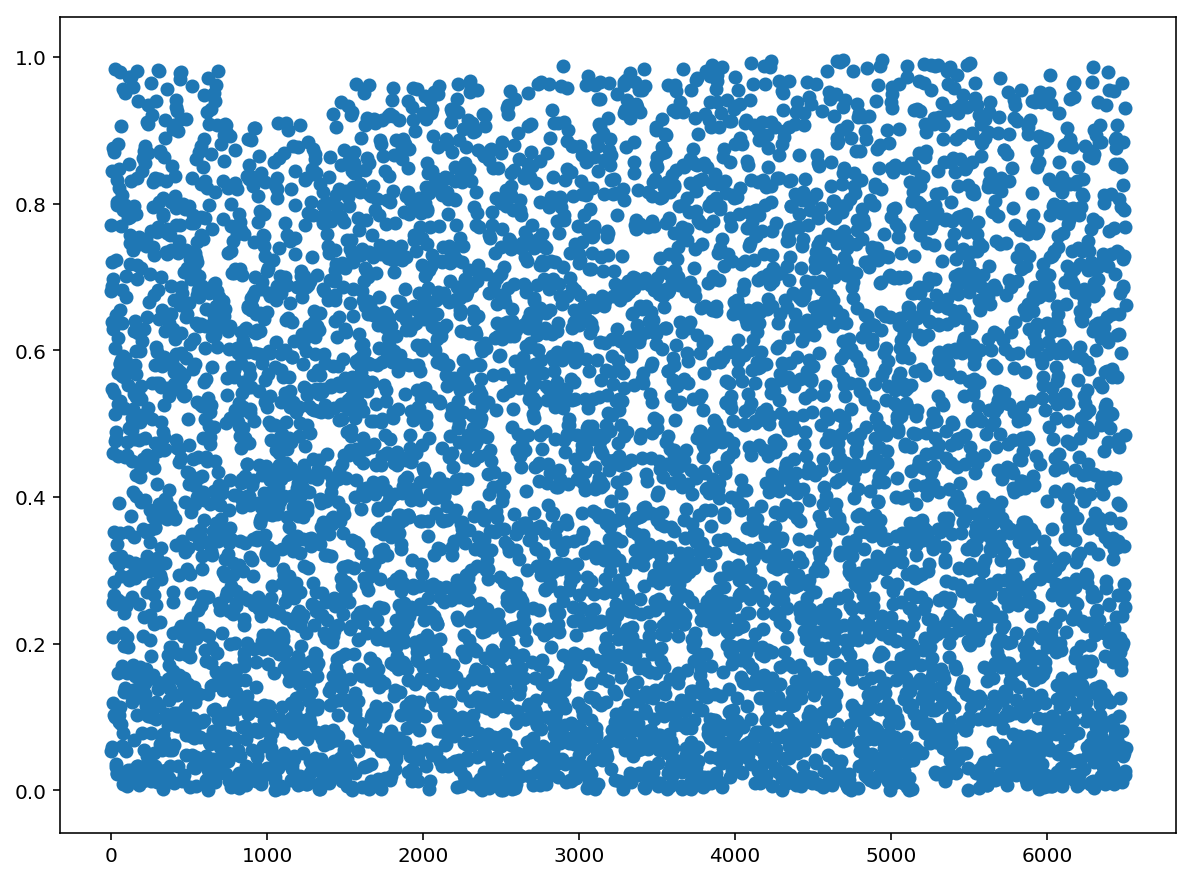

In [253]:
plt.figure(figsize=(10, 7.5))
plt.scatter(range(p_0_1.shape[0]),(p_0_1[:, 0]-p_0_1[:, 1]))
plt.show()

In [205]:
t2.loc[t2.t2 == (0, 1)].index.tolist()

[37,
 136,
 248,
 257,
 334,
 373,
 419,
 495,
 546,
 565,
 612,
 625,
 627,
 737,
 739,
 745,
 809,
 866,
 971,
 990,
 991,
 1066,
 1068,
 1075,
 1079,
 1118,
 1133,
 1150,
 1187,
 1199,
 1202,
 1281,
 1315,
 1328,
 1346,
 1402,
 1443,
 1483,
 1588,
 1627,
 1637,
 1654,
 1675,
 1715,
 1787,
 1797,
 1882,
 1901,
 1982,
 1985,
 2018,
 2046,
 2053,
 2073,
 2098,
 2124,
 2133,
 2261,
 2284,
 2291,
 2319,
 2343,
 2439,
 2694,
 2699,
 2754,
 2797,
 2830,
 2885,
 2912,
 2965,
 2971,
 2980,
 2981,
 2982,
 3000,
 3004,
 3029,
 3034,
 3052,
 3081,
 3133,
 3146,
 3190,
 3236,
 3275,
 3333,
 3341,
 3345,
 3358,
 3384,
 3409,
 3443,
 3522,
 3537,
 3576,
 3597,
 3631,
 3660,
 3666,
 3691,
 3719,
 3740,
 3773,
 3791,
 3868,
 3904,
 3982,
 4074,
 4120,
 4140,
 4153,
 4226,
 4269,
 4314,
 4343,
 4350,
 4365,
 4416,
 4433,
 4496,
 4513,
 4573,
 4672,
 4697,
 4709,
 4714,
 4747,
 4783,
 4966,
 4975,
 5014,
 5035,
 5038,
 5181,
 5204,
 5284,
 5554,
 5558,
 5711,
 5764,
 5884,
 5909,
 5919,
 5957,
 6002,


In [239]:
t2.t2.value_counts()

(9, 9)    351674
(0, 1)      9354
(1, 0)      6504
(0, 5)      5812
(5, 0)      4072
(5, 1)      1914
(1, 5)      1824
(0, 6)      1386
(2, 0)      1374
(2, 5)      1198
(2, 1)      1186
(6, 0)      1111
(0, 8)       962
(0, 2)       912
(1, 2)       878
(5, 2)       805
(8, 0)       605
(0, 7)       599
(2, 6)       573
(7, 0)       564
(6, 5)       531
(6, 2)       427
(5, 6)       372
(8, 1)       363
(7, 5)       347
(1, 8)       318
(2, 7)       256
(5, 7)       253
(4, 5)       247
(5, 4)       218
           ...  
(1, 6)       116
(6, 1)       107
(8, 7)       106
(5, 3)       104
(3, 5)        98
(1, 4)        70
(1, 3)        66
(3, 1)        59
(2, 3)        48
(3, 6)        45
(2, 8)        41
(6, 3)        35
(3, 2)        33
(8, 2)        33
(4, 7)        30
(4, 3)        29
(6, 8)        26
(7, 4)        24
(3, 4)        23
(3, 7)        22
(8, 6)        22
(3, 8)        20
(7, 3)        19
(8, 3)        17
(7, 6)        17
(4, 6)        16
(6, 4)        11
(6, 7)        

In [240]:
t2.t1.value_counts()

(9, 9)    92604
(0, 1)    58226
(1, 0)    50107
(5, 0)    27110
(0, 5)    26543
(2, 0)    17850
(1, 5)    11661
(2, 1)     9448
(5, 1)     9400
(2, 5)     9198
(4, 0)     7935
(6, 0)     7376
(0, 6)     6185
(1, 2)     5030
(8, 1)     4699
(8, 0)     4393
(2, 6)     3416
(0, 8)     3386
(5, 2)     3367
(6, 5)     3235
(4, 5)     3003
(0, 2)     2953
(7, 0)     2749
(4, 1)     2276
(3, 0)     2070
(0, 7)     2018
(6, 2)     1937
(7, 5)     1896
(2, 7)     1631
(5, 6)     1347
          ...  
(3, 1)      477
(1, 6)      431
(8, 7)      408
(7, 8)      396
(0, 4)      333
(3, 6)      297
(4, 3)      290
(5, 3)      286
(1, 4)      276
(4, 7)      218
(3, 2)      187
(2, 8)      180
(2, 3)      179
(1, 3)      171
(3, 8)      156
(4, 6)      153
(8, 2)      146
(8, 6)      120
(6, 8)      105
(3, 7)      101
(6, 3)      100
(3, 4)       91
(8, 3)       84
(7, 6)       70
(7, 4)       69
(7, 3)       68
(4, 8)       56
(6, 7)       51
(6, 4)       44
(8, 4)       19
Name: t1, Length: 73, dt

In [207]:
y_pred

array([[0.10992906, 0.40810094, 0.00207566, ..., 0.00336228, 0.01222288,
        0.03009286],
       [0.81948579, 0.06167358, 0.00060704, ..., 0.00370882, 0.00287854,
        0.0897192 ],
       [0.49096943, 0.05371368, 0.0111682 , ..., 0.22921039, 0.01985252,
        0.063434  ],
       ...,
       [0.00181432, 0.99651068, 0.00049706, ..., 0.00022271, 0.00007493,
        0.00019172],
       [0.09496004, 0.75743027, 0.00137386, ..., 0.00480141, 0.07867398,
        0.01791653],
       [0.71326859, 0.04275361, 0.00071899, ..., 0.02091646, 0.00343322,
        0.00435631]])

In [208]:
y_pred[t2.loc[t2.t2 == (0, 1)].index.tolist()]

array([[0.72889898, 0.17387012, 0.00941863, ..., 0.01206814, 0.01050611,
        0.01702775],
       [0.81758897, 0.11920263, 0.00866875, ..., 0.01585348, 0.00516296,
        0.00716639],
       [0.45865418, 0.25274509, 0.00924584, ..., 0.01981416, 0.03205305,
        0.05578867],
       ...,
       [0.56001332, 0.32323006, 0.00746462, ..., 0.01128116, 0.0206107 ,
        0.02448993],
       [0.76794892, 0.09468002, 0.06178987, ..., 0.0097861 , 0.00592469,
        0.00482682],
       [0.61446175, 0.18286098, 0.01087381, ..., 0.0545508 , 0.00800942,
        0.02876119]])

In [191]:
diff_prob = []
for i in diff_idx:
    i_0 = y_pred_top2[i][0]
    i_1 = y_pred_top2[i][1]
    diff_prob.append(y_pred[i][i_0] - y_pred[i][i_1])

In [197]:
sum(np.array(diff_prob)<0.1)

8472

In [252]:
print("acc:",accuracy_score(y_true, np.argmax(y_pred, axis=1)))

acc: 0.760465


In [198]:
print("acc:",accuracy_score(y_true, np.argmax(y_pred, axis=1)))

acc: 0.76849


In [101]:
np.bincount(y_true.astype(int))

array([120370,  91053,  51015,   6588,  16494,  62684,  21135,  13181,
        17480])

In [204]:
np.bincount(np.argmax(y_pred, 1))

array([136556,  86555,  53538,   5822,  16838,  58678,  18039,  10209,
        13765])

In [205]:
np.bincount(np.argmax(result, 1))

array([34379, 21542, 13479,  1450,  4132, 14721,  4588,  2421,  3288])

In [ ]:
 # bbox_inches='tight'

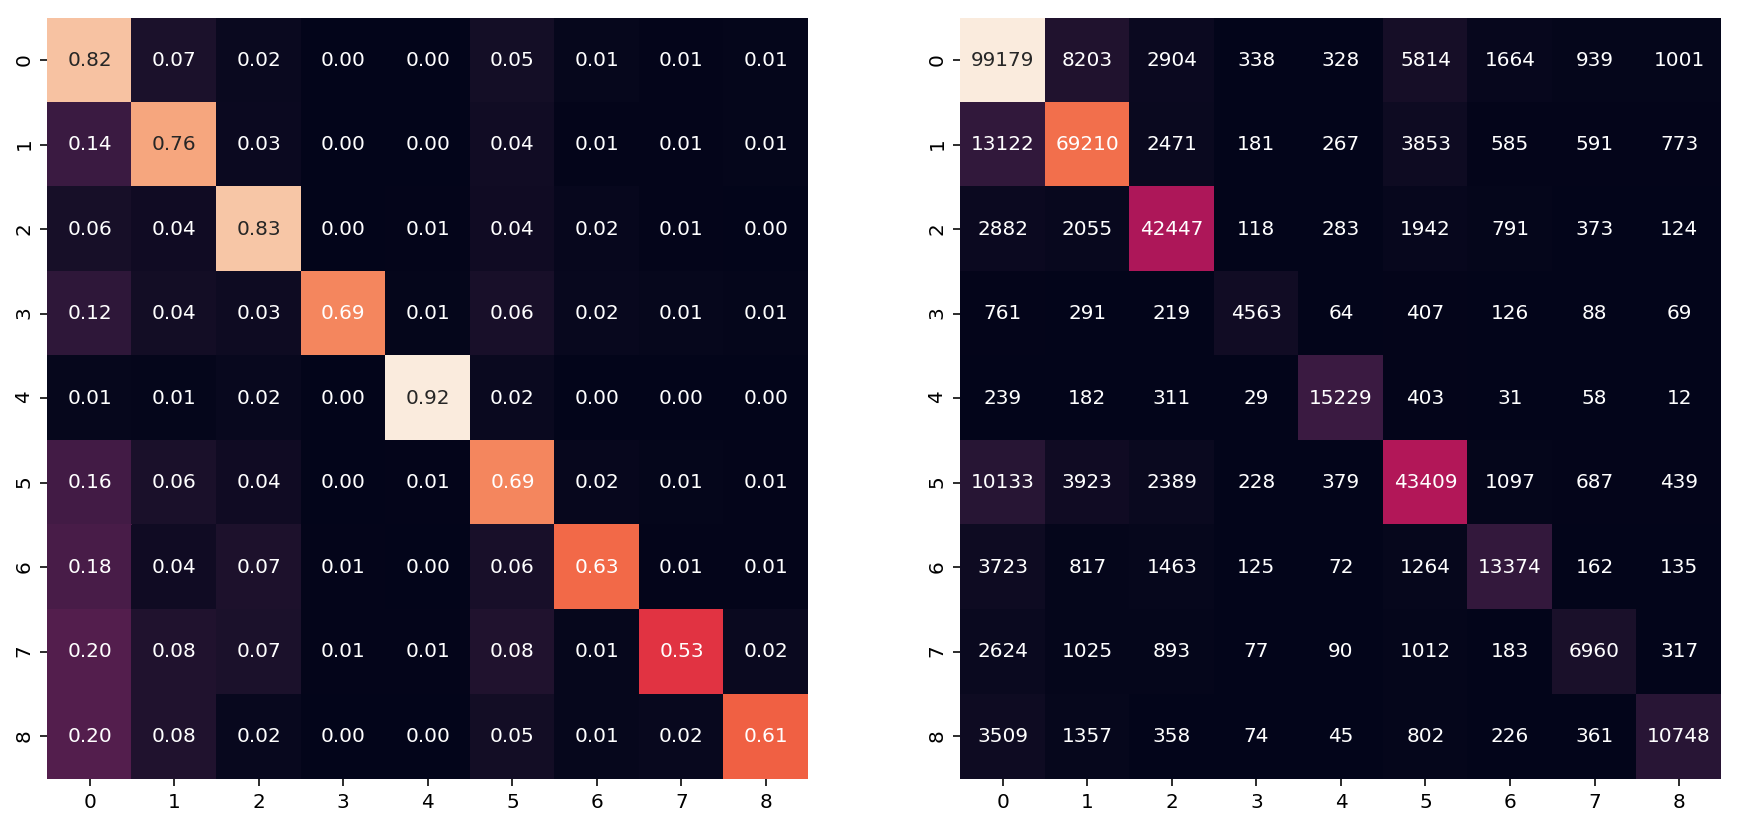

In [84]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, 1))
f, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.show()

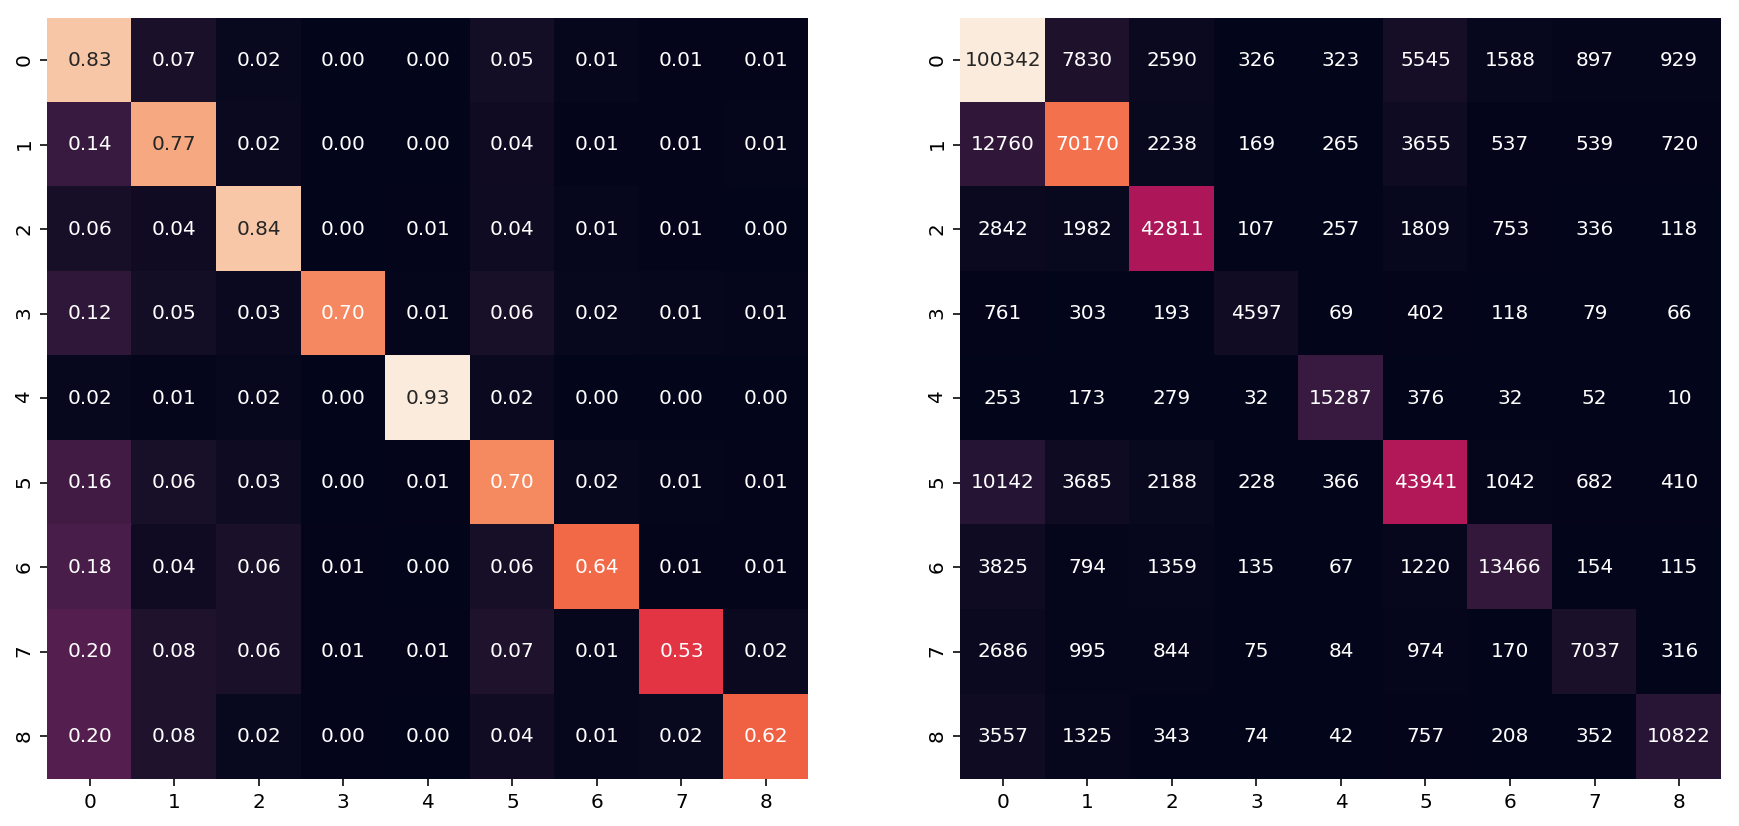

In [93]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, 1))
f, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
plt.savefig('./confusionmat.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.show()

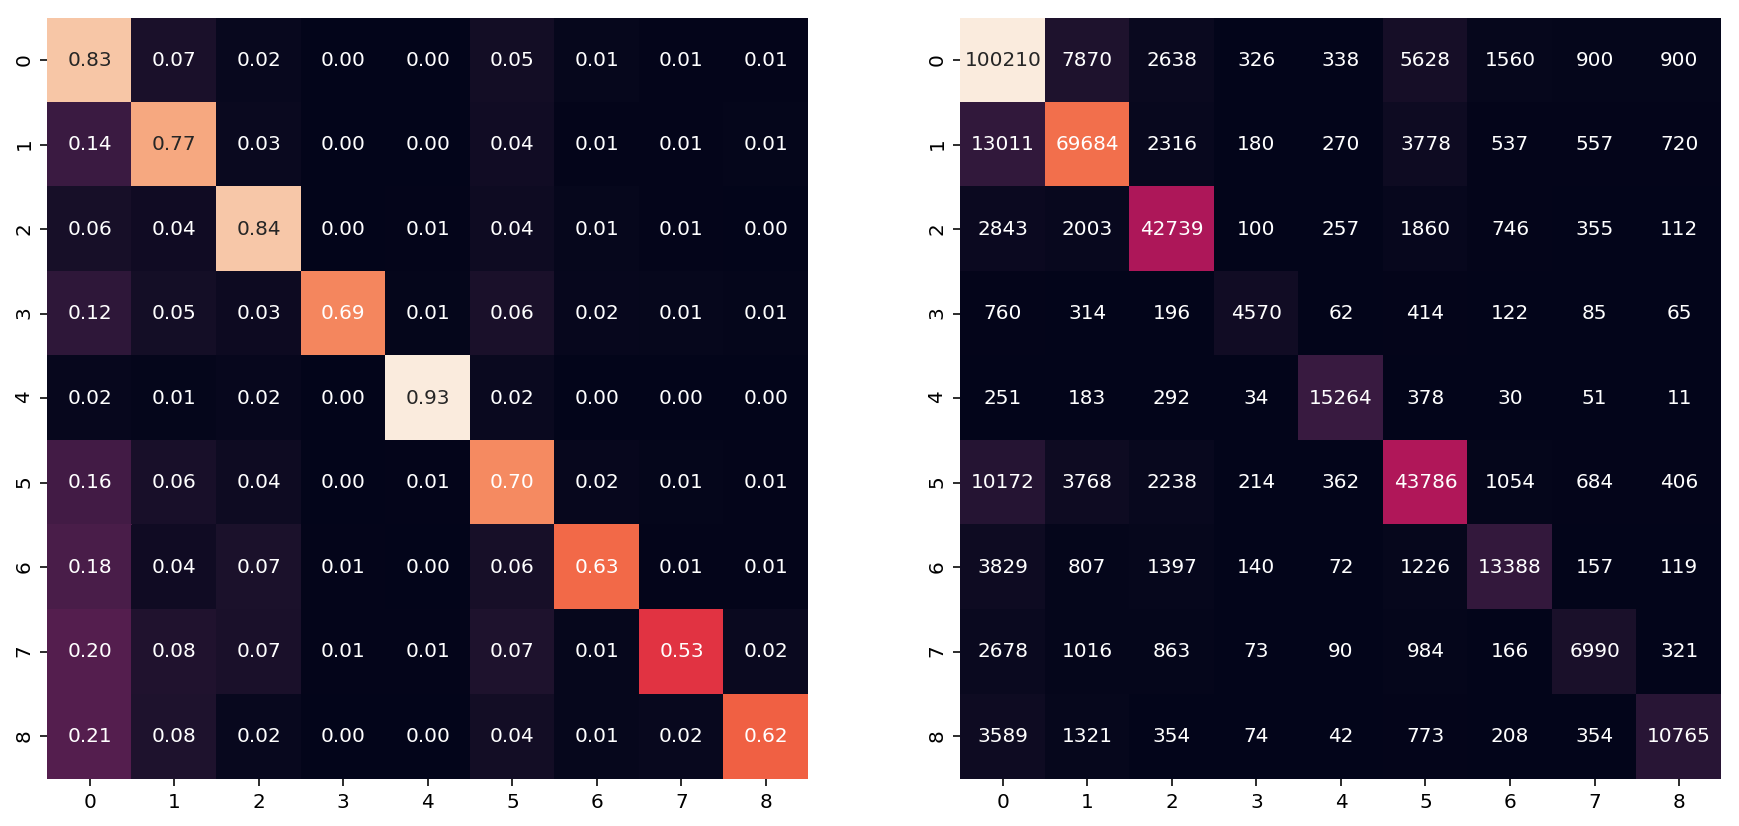

In [310]:
conf_mat = confusion_matrix(y_true, np.argmax(y_pred, 1))
f, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(conf_mat/conf_mat.sum(axis=1).reshape(-1, 1), square=True, ax=axes[0], annot=True, fmt='0.2f', cbar=False)
sns.heatmap(conf_mat, square=True, ax=axes[1], annot=True, fmt='0.0f', cbar=False)
plt.savefig('./confusionmat_new.png', format='png', bbox_inches='tight', transparent=False, dpi=150)
plt.show()

In [270]:
np.arange(0, -0.5, -0.0001)

array([ 0.    , -0.0001, -0.0002, ..., -0.4997, -0.4998, -0.4999])

In [282]:
 in y_pred_top2[0]

True

In [285]:
np.where(y_pred_top2==np.array([5, 1]))[0]

array([     0,      0,      3, ..., 399988, 399992, 399996])

In [297]:
(t2.t1==(0, 1)).values.sum()

58226

In [298]:
(t2.t2==(0, 1)).values.sum()

9354

In [306]:
((t2.t1==(0, 5)).values | (t2.t2==(0, 5)).values).sum()

32355

In [307]:
_01idx = ((t2.t1==(0, 5)).values | (t2.t2==(0, 5)).values)

In [308]:
cid_delta = []
for i in [0]:
    for delta in np.arange(0, -0.5, -0.0001):
        y_pred_adj = y_pred.copy()
        y_pred_adj[_01idx, i] = y_pred_adj[_01idx, i] + delta
        acc = accuracy_score(y_true, np.argmax(y_pred_adj, axis=1))
        if acc > 0.76849:
            cid_delta.append(tuple((i, delta, acc)))
            print("class:%s, delta:%s, acc:%s"%(i, delta, acc))

class:0, delta:-0.0045000000000000005, acc:0.7684925
class:0, delta:-0.0063, acc:0.7684975
class:0, delta:-0.0064, acc:0.7684975
class:0, delta:-0.006500000000000001, acc:0.7685
class:0, delta:-0.0066, acc:0.7684975
class:0, delta:-0.0067, acc:0.7685
class:0, delta:-0.0068000000000000005, acc:0.7684975
class:0, delta:-0.006900000000000001, acc:0.7685025
class:0, delta:-0.007, acc:0.768505
class:0, delta:-0.0071, acc:0.7685025
class:0, delta:-0.007200000000000001, acc:0.7684975
class:0, delta:-0.0073, acc:0.7685
class:0, delta:-0.0074, acc:0.768505
class:0, delta:-0.007500000000000001, acc:0.768505
class:0, delta:-0.0076, acc:0.768505
class:0, delta:-0.0077, acc:0.768505
class:0, delta:-0.0078000000000000005, acc:0.7684975
class:0, delta:-0.0079, acc:0.7684975
class:0, delta:-0.008, acc:0.7685
class:0, delta:-0.0081, acc:0.7685
class:0, delta:-0.0082, acc:0.7685025
class:0, delta:-0.0083, acc:0.7685075
class:0, delta:-0.008400000000000001, acc:0.7685075
class:0, delta:-0.0085, acc:0.768

In [304]:
len(cid_delta)

0

In [309]:
sorted(cid_delta, key=lambda x:x[2], reverse=True)

[(0, -0.009000000000000001, 0.7685225),
 (0, -0.0089, 0.76852),
 (0, -0.0091, 0.7685175),
 (0, -0.0213, 0.7685175),
 (0, -0.021400000000000002, 0.7685175),
 (0, -0.0099, 0.768515),
 (0, -0.0212, 0.768515),
 (0, -0.0088, 0.7685125),
 (0, -0.0098, 0.7685125),
 (0, -0.018500000000000003, 0.7685125),
 (0, -0.0196, 0.7685125),
 (0, -0.02, 0.7685125),
 (0, -0.0201, 0.7685125),
 (0, -0.020200000000000003, 0.7685125),
 (0, -0.020300000000000002, 0.7685125),
 (0, -0.0204, 0.7685125),
 (0, -0.020900000000000002, 0.7685125),
 (0, -0.0211, 0.7685125),
 (0, -0.021500000000000002, 0.7685125),
 (0, -0.0216, 0.7685125),
 (0, -0.0217, 0.7685125),
 (0, -0.008700000000000001, 0.76851),
 (0, -0.009300000000000001, 0.76851),
 (0, -0.01, 0.76851),
 (0, -0.0184, 0.76851),
 (0, -0.0187, 0.76851),
 (0, -0.0194, 0.76851),
 (0, -0.0195, 0.76851),
 (0, -0.0198, 0.76851),
 (0, -0.0199, 0.76851),
 (0, -0.0205, 0.76851),
 (0, -0.020800000000000003, 0.76851),
 (0, -0.021, 0.76851),
 (0, -0.0218, 0.76851),
 (0, -0.021

In [192]:
result_adj = result.copy()
result_adj[:, 5] = result_adj[:, 5] + 0.036000000000000004

In [193]:
ID_values[:, 1] = np.argmax(result_adj, 1)
ID_values

array([[    0,     0],
       [    1,     2],
       [    2,     2],
       ...,
       [99997,     0],
       [99998,     0],
       [99999,     0]])

In [194]:
with open("./submit/0716stacking_lgb_calibrate.txt", "w") as f:
    for ID, pred in ID_values:
        f.write("%s \t %03d\n"%(str(ID).zfill(6), pred+1))